In [1]:
from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

import datetime

In [2]:
class WebScrapingToDF(object):
    def __init__(self, url):
        self._url = url
    
    def start(self, table_class="sortable wikitable"):
        """
            1. make initial request
            2. turn the request into soup object
            3. get table
            4. from table get columns and rows
            5. return pandas dataframe of data obtained
        """
        url_html = self._make_request()
        soup = BS(url_html, 'html.parser')
        
        table = WebScrapingToDF._get_table(soup, table_class=table_class)
        
        columns = WebScrapingToDF._get_headers(table)
        rows = WebScrapingToDF._get_rows(table)
        
        return pd.DataFrame(data=rows, columns=columns)
    
    def _make_request(self):
        request = urllib.request.Request(self._url)
        result = urllib.request.urlopen(request)
        return result.read()
    
    @staticmethod
    def _get_table(soup, table_class):
        table_html = soup.find_all('table', class_=table_class)
        return table_html[0]
    
    @staticmethod
    def _get_headers(table):
        table_headers = table.find_all("th")
        return [th.text for th in table_headers]
    
    @staticmethod
    def _get_rows(table):
        rows = []
        for tr in table.find_all("tr")[1:]:
            row_data = [td.text for td in tr.find_all("td")]
            rows.append(row_data)
            
        return rows
    

# We are using data from multiple resources. Here is all the links we used to gather this info!!! Results are all dataframes :D 

In [3]:
# Gather earthquakes info
earthquakes_scraping = WebScrapingToDF(url="https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
earthquakes = earthquakes_scraping.start()

In [4]:
# Gather volcano info
volcanoes_scraping = WebScrapingToDF(url="http://volcano.oregonstate.edu/volcano_table")
volcanoes = volcanoes_scraping.start(table_class="views-table cols-6")

In [5]:
# Gather vents info
vents_scraping = WebScrapingToDF(url="http://vents-data.interridge.org/ventfields_list_all")
vents = vents_scraping.start(table_class="views-table cols-8")

In [6]:
class CleanData(object):
    def __init__(self, df):
        self._df = df
        
    def clean_col_by_regex(self, regex, column):
        self._df[column] = self._df[column].str.replace(regex, "")
        
    def nan_to_float32(self, columns, value=0, inplace=True):    
        for col in columns:        
            self._df[col].fillna(value=value, inplace=inplace)
            self._df[col] = pd.to_numeric(self._df[col], downcast='float')
            
    def strip_columns(self, columns):
        for column in columns:
            self._df[column] = self._df[column].str.strip()      

## Cleaning the Earthquake Data

In [7]:
class CleanEarthquakes(CleanData):
    def __init__(self, df):
        super(CleanEarthquakes, self).__init__(df)
        
    def clean_cols_by_extract(self, columns, regex):
        for col in columns:
            self._df[col] = self._df[col].str.extract(regex, expand=True)
        
    def convert_nan_lat_lng(self, is_nan):
        """There are son lat/lng values in the dataframe that didn't exist on the wiki page, so we looked up the coords
            and assigned them to their appropriate location

            First index is LNG, second is LAT
        """
        for loc, coords in is_nan.items():
            self._df.iloc[loc, self._df.columns.get_loc('lng')] = coords[0]
            self._df.iloc[loc, self._df.columns.get_loc('lat')] = coords[1]

        assert self._df[self._df["lat"].isnull()].empty == True
        assert self._df[self._df["lng"].isnull()].empty == True
        
    def convert_values_in_row_by_index(self, index, **kwargs):
        """There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
        for key, value in kwargs.items():
            self._df.iloc[index, self._df.columns.get_loc(key)] = value    
            
    def get_mean_deaths(self, column):
        """There can potentially be multiple values within the Other Source Deaths column. So, this is grabbing the 
            values and determining the mean
        """
        means = []
        for row in self._df[column]:
            if isinstance(row, str):
                int_list = row.strip().split(" ")
                total = 0
                total = sum(list(map(int, map(float, int_list))))

                mean = total / len(int_list)
                means.append(mean)
            else:
                means.append(row)

        self._df[column] = means
        
    def assign_mag_units_and_values(self):
        Mag = self._df['Mag'].str.split(" ")
        # print(Mag)
        values = [row[0] for row in Mag]

        units = [self._return_empty(row) for row in Mag]

        #print(units)
        self._df['Mag_Value'] = values
        self._df['Mag_Units'] = units
        
    def _return_empty(self, row):
        if len(row) < 2:
            return ''

        val= row [1]
        if val =="Mb":
            val = "mb"
        return val

In [8]:
# rename columns
earthquakes.columns = ["UTC", "Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]

In [9]:
clean_earthquakes = CleanEarthquakes(earthquakes)

clean_earthquakes.clean_col_by_regex(regex=r"(\[\d+\]|\(.*\)|\*|\+|\,)", column="Other_Deaths")
clean_earthquakes.clean_col_by_regex("(\s\(.*)", column="Country")

is_nan = {439: [69.13, 41.16], 1319: [90.302, 29.759], 1320: [67.484, 30.569], 1323: [101.086, 25.619], 1324: [138.276, 34.778], 1325: [107.328, -7.778], 1326: [-171.87, -15.53], 1327: [99.97, 0.71], 1330: [40.03, 38.79], 1331: [-72.13, -34.301], 1332: [96.629, 33.165], 1333: [172.7012, -43.5834], 1334: [97.994, 24.71], 1336: [99.949, 20.705]}
clean_earthquakes.convert_nan_lat_lng(is_nan)

"""There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
question_index = earthquakes[earthquakes["lat"] == "?"].index
clean_earthquakes.convert_values_in_row_by_index(question_index, lat=21.4, lng=42.1, Depth_km=6)

"""There are some bad characters in this column, so this regex just grabs the int"""
clean_earthquakes.clean_cols_by_extract(columns=['EM-DAT_Deaths'], regex='(\d+\.\d*)')

"""We want to extract the units and values from the magnitude column. The types of units in theis column
    represent different measurements, and so can't be compared overall.
"""
clean_earthquakes.assign_mag_units_and_values()

"""Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to 0.
"""
columns_to_convert = ['PDE_Deaths', 'PDE_Shaking_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths', 'Mag_Value', 'lat', 'lng', 'Depth_km']
clean_earthquakes.nan_to_float32(columns=columns_to_convert)

In [10]:
# Create the apropriate datetime columns with padding for javascript visuals
earthquakes["UTC"] = pd.to_datetime(earthquakes["UTC"])
earthquakes["Year"] = pd.DatetimeIndex(earthquakes["UTC"]).year
earthquakes["Month"] = pd.DatetimeIndex(earthquakes["UTC"]).month.map("{:02}".format)
earthquakes["Day"] = pd.DatetimeIndex(earthquakes["UTC"]).day.map("{:02}".format)

In [11]:
# Creating a new column 'deaths' that is the max of these four columns
subdf = earthquakes[["PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]]
earthquakes["Max_Deaths"] = subdf.max(axis = 1)

In [12]:
# Import plates and countries geojson to plot
plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")

## magnitude

Categories:
1. local magnitude (ML), commonly referred to as "Richter magnitude"

The magnitude is a number that characterizes the relative size of an earthquake. Magnitude is based on measurement of the maximum motion recorded by a seismograph. Several scales have been defined, but the most commonly used are (1) local magnitude (ML), commonly referred to as "Richter magnitude", (2) surface-wave magnitude (Ms), (3) body-wave magnitude (Mb), and (4) moment magnitude (Mw). Scales `1-3` have limited range and applicability and do not satisfactorily measure the size of the largest earthquakes. The moment magnitude (Mw) scale, based on the concept of seismic moment, is uniformly applicable to all sizes of earthquakes but is more difficult to compute than the other types. All magnitude scales should yield approximately the same value for any given earthquake.

Where the details of how a magnitude has been determined are unknown catalogs will specify the scale as unknown (variously Unk, Ukn, or UK). In such cases the magnitude is considered generic and approximate.

In Japan, for shallow (depth < 60 km) earthquakes within 600 km, the Japanese Meteorological Agency calculates a magnitude labeled MJMA, MJMA, or MJ. (These should not be confused with moment magnitudes JMA calculates, which are labeled Mw(JMA) or M(JMA).) The magnitudes are based (as typical with local scales) on the maximum amplitude of the ground motion; they agree "rather well" with the seismic moment magnitude Mw in the range of 4.5 to 7.5, but underestimate larger magnitudes.

In [13]:
earthquakes['Mag_Units'].value_counts()

Mw      822
Muk     201
mb      145
Ms      122
ML       31
MJMA      8
Md        5
Lg        4
          2
Name: Mag_Units, dtype: int64

In [14]:
Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)

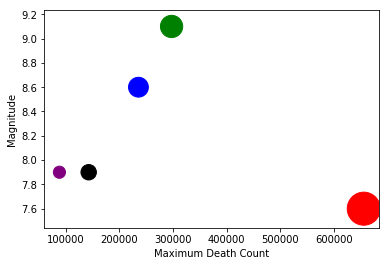

In [15]:
# Base size of dots based on frequency
np_death = np.array(Death_top5['Max_Deaths'])
np_death = np_death / 600

plt.scatter(Death_top5['Max_Deaths'], Death_top5['Mag_Value'], s=np_death, c=['red', 'green', 'blue', 'black', 'purple'], label='Country')

plt.xlabel('Maximum Death Count')
plt.ylabel('Magnitude')

plt.show()

In [16]:
Death_top5[['Country', 'Mag_Value', 'Mag_Units', 'Max_Deaths']]

,Country,Mag_Value,Mag_Units,Max_Deaths
583,China,7.6,Mw,655237.0
1238,Indonesia,9.1,Mw,297200.0
102,China,8.6,Ms,235502.0
116,Japan,7.9,Muk,142807.0
1308,China,7.9,Mw,88287.0


## 1976 Tangshan Earthquake
There is an obvious outlier in this data. China is really skewing our dataset. 

On further investigation, we saw that in 1976, this Tangshan Earthquake death count was overly reported at approximately 655,000 deaths, but this number has since been stated to be around 240,000 to 255,000. 
You can check out the link to this data [here](https://en.wikipedia.org/wiki/1976_Tangshan_earthquake).

With this being noted, we are changing the values to the more accurate values.

In [17]:
earthquakes.loc[583, 'Max_Deaths'] = 255000.0

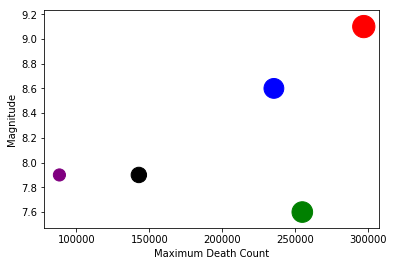

In [18]:
Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)

np_death = np.array(Death_top5['Max_Deaths'])
np_death = np_death / 600

plt.scatter(Death_top5['Max_Deaths'], Death_top5['Mag_Value'], s=np_death, c=['red', 'green', 'blue', 'black', 'purple'], label='Country')

plt.xlabel('Maximum Death Count')
plt.ylabel('Magnitude')

plt.show()

With this being shown, I think we are able to determine that Magnitude has correlation with death count.

In [19]:
def create_gdf(df):
    geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
        
    crs = {"init": "epsg:4326"} 
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [20]:
earthquakes_Mag_top5 = earthquakes.sort_values('Mag_Value',ascending=False).head(5)
earthquakes_Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)
earthquakes_Depth_km_top5 = earthquakes.sort_values('Depth_km',ascending=False).head(5)

earthquakes_Mag_top5_sum = earthquakes_Mag_top5['Mag_Value'].sum()
earthquakes_Death_top5_sum = earthquakes_Death_top5['Max_Deaths'].sum()
earthquakes_Depth_km_top5_sum = earthquakes_Depth_km_top5['Depth_km'].sum()

earthquakes_Mag_top5['norm'] = earthquakes_Mag_top5['Mag_Value'] / earthquakes_Mag_top5_sum
earthquakes_Death_top5['norm'] = earthquakes_Death_top5['Max_Deaths'] / earthquakes_Death_top5_sum
earthquakes_Depth_km_top5['norm'] = earthquakes_Depth_km_top5['Depth_km'] / earthquakes_Depth_km_top5_sum

earthquakes_Mag_top5['cat'] = 'Mag'
earthquakes_Death_top5['cat'] = 'Death'
earthquakes_Depth_km_top5['cat'] = 'Depth'

In [21]:
earthquakes_Mag_top5

,UTC,Country,lat,lng,Depth_km,Mag,Secondary_Effects,PDE_Shaking_Deaths,PDE_Deaths,Utsu_Deaths,EM-DAT_Deaths,Other_Deaths,Mag_Value,Mag_Units,Year,Month,Day,Max_Deaths,norm,cat
396,1960-05-22 19:11:00,Chile,-38.235001,-73.046997,35.000000,9.5 Muk,T,NaN,NaN,5700.0,0.0,,9.5,Muk,1960,05,22,5700.0,0.207424,Mag
416,1964-03-28 03:36:00,United States,61.016998,-147.647995,6.600000,9.2 Muk,T,NaN,NaN,131.0,0.0,,9.2,Muk,1964,03,28,131.0,0.200873,Mag
1238,2004-12-26 00:58:00,Indonesia,3.287000,95.972000,30.000000,9.1 Mw,"T,L",NaN,297200.0,NaN,0.0,231000 283000 227898,9.1,Mw,2004,12,26,297200.0,0.198690,Mag
1335,2011-03-11 14:46:00,Japan,38.321999,142.369003,24.400000,9.0 Mw,T,NaN,NaN,NaN,0.0,15894,9.0,Mw,2011,03,11,0.0,0.196507,Mag
332,1952-11-04 16:58:00,Russian Federation,52.755001,160.057007,22.200001,9.0 Muk,T,NaN,NaN,NaN,0.0,,9.0,Muk,1952,11,04,0.0,0.196507,Mag


In [22]:
earthquakes_mag_death_depth = pd.concat([earthquakes_Mag_top5, earthquakes_Death_top5, earthquakes_Depth_km_top5], ignore_index=False)
earthquakes_mag_death_depth = earthquakes_mag_death_depth[['lng', 'lat', 'Country', 'Mag_Units', 'Mag_Value', 'Depth_km', 'Max_Deaths', 'norm', 'cat']].sort_index()

earthquakes_mag_death_depth_gdf = create_gdf(df=earthquakes_mag_death_depth)

In [23]:
earthquakes_mag_death_depth_gdf.sort_values('cat')

,lng,lat,Country,Mag_Units,Mag_Value,Depth_km,Max_Deaths,norm,cat,geometry
102,105.317001,36.601002,China,Ms,8.6,25.000000,235502.0,0.231157,Death,POINT (105.3170013427734 36.60100173950195)
116,139.084000,35.404999,Japan,Muk,7.9,35.000000,142807.0,0.140172,Death,POINT (139.0839996337891 35.40499877929688)
583,117.888000,39.605000,China,Mw,7.6,16.700001,255000.0,0.250295,Death,POINT (117.8880004882812 39.60499954223633)
1238,95.972000,3.287000,Indonesia,Mw,9.1,30.000000,297200.0,0.291717,Death,POINT (95.97200012207031 3.286999940872192)
1308,103.321999,31.002001,China,Mw,7.9,19.000000,88287.0,0.086658,Death,POINT (103.3219985961914 31.00200080871582)
501,-72.563004,-1.486000,Colombia,Muk,8.0,644.599976,1.0,0.247182,Depth,POINT (-72.56300354003906 -1.485999941825867)
738,138.871002,29.372000,Japan,Mw,7.4,459.100006,1.0,0.176049,Depth,POINT (138.8710021972656 29.37199974060059)
953,137.925995,32.029999,Japan,Mw,6.9,351.000000,1.0,0.134596,Depth,POINT (137.9259948730469 32.02999877929688)
970,-67.512001,-13.860000,Bolivia,Mw,8.2,631.000000,10.0,0.241966,Depth,POINT (-67.51200103759766 -13.85999965667725)
1242,123.337997,5.321000,Philippines,Mw,7.1,522.099976,2.0,0.200207,Depth,POINT (123.3379974365234 5.321000099182129)


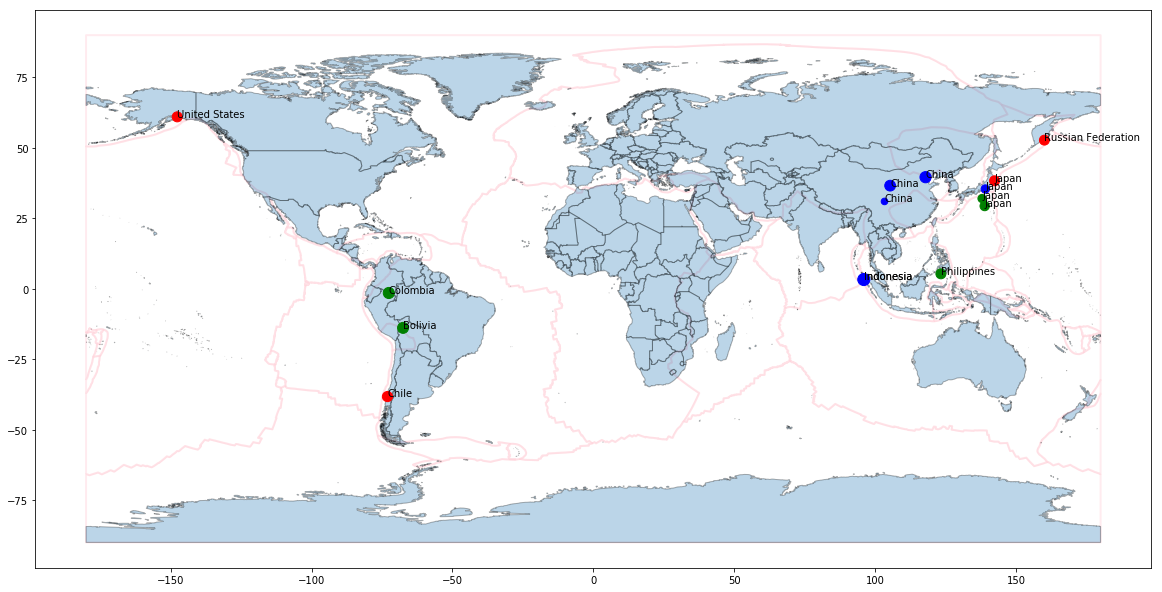

In [24]:
norm_size = np.array(earthquakes_mag_death_depth_gdf['norm'])
norm_size = norm_size * 500

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='white', edgecolor='pink', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

colors = {'Mag':'red', 'Death':'blue', 'Depth':'green', 'G':'black'}
earthquakes_mag_death_depth_gdf.plot(
    ax=ax, 
    markersize=norm_size, 
    color=earthquakes_mag_death_depth_gdf['cat'].apply(lambda x: colors[x]),
    label=earthquakes_mag_death_depth_gdf['cat'].apply(lambda x: x)
)

for row in earthquakes_mag_death_depth_gdf.iterrows():
    plt.text(row[1].lng, row[1].lat, row[1].Country)

[Text(0,0,'China'),
 Text(0,0,'Indonesia'),
 Text(0,0,'Turkey'),
 Text(0,0,'Iran'),
 Text(0,0,'Japan'),
 Text(0,0,'Peru'),
 Text(0,0,'Taiwan'),
 Text(0,0,'Mexico'),
 Text(0,0,'Chile'),
 Text(0,0,'Greece'),
 Text(0,0,'Philippines'),
 Text(0,0,'Italy'),
 Text(0,0,'United States'),
 Text(0,0,'Afghanistan'),
 Text(0,0,'Pakistan'),
 Text(0,0,'India'),
 Text(0,0,'Colombia'),
 Text(0,0,'Algeria'),
 Text(0,0,'Ecuador'),
 Text(0,0,'Papua New Guinea'),
 Text(0,0,'Guatemala'),
 Text(0,0,'South Africa'),
 Text(0,0,'Russian Federation'),
 Text(0,0,'Argentina'),
 Text(0,0,'Burma')]

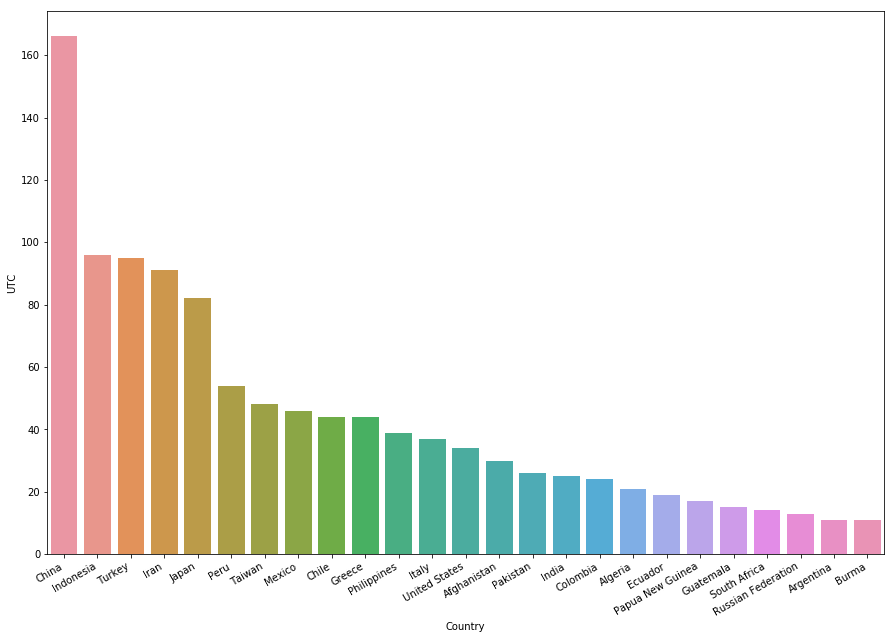

In [25]:
quakes_country_25 = earthquakes.groupby("Country").agg(len).reset_index().nlargest(25, columns="UTC")

f, ax = plt.subplots(figsize=(15, 10))
#plt.ylabel('Number of Quakes')
quake_count = sns.barplot(x='Country', y='UTC', data=quakes_country_25)
quake_count.set_xticklabels(quake_count.get_xticklabels(), rotation=30, ha="right")

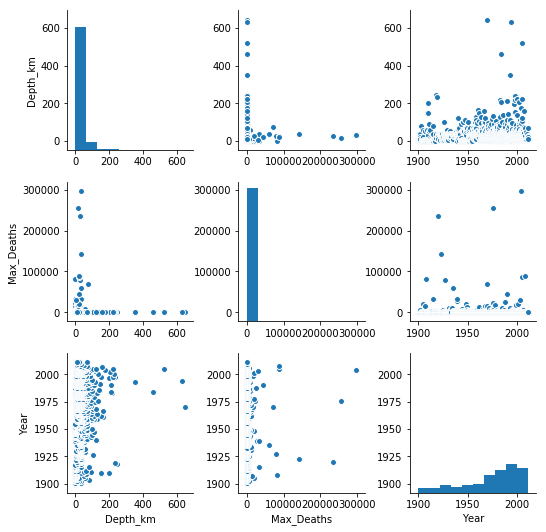

In [26]:
"""Trying to find any correlation between these columns. Most interesting find is between Depth and Mag"""
earthquakes_cont = earthquakes[["Depth_km", "Mag", "Max_Deaths", "Year"]]
earthquakes_cont = earthquakes_cont.replace("?", np.nan)
earthquakes_cont = earthquakes_cont.dropna()

sns.pairplot(earthquakes_cont, dropna=True)

In [27]:
# Total deaths by country
occurrence_death = earthquakes[['Country', 'Max_Deaths']].groupby(['Country']).agg(['sum', 'count'])
occurrence_death.columns=['Total Deaths', 'Frequency of Earthquakes']

EQ_Casualities = occurrence_death.sort_values(['Frequency of Earthquakes'], ascending=False)
EQ_Casualities.head()

,Total Deaths,Frequency of Earthquakes
Country,,
China,738151.0,166
Indonesia,342112.0,96
Turkey,90836.0,95
Iran,152664.0,91
Japan,166997.0,82


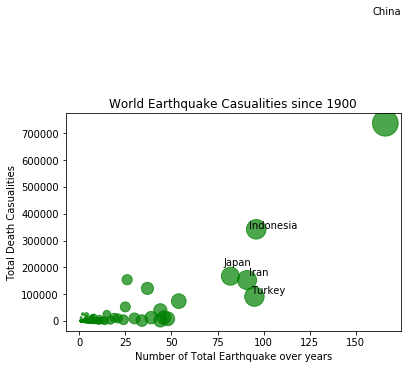

In [28]:
# Base size of dots based on frequency
np_death = np.array(EQ_Casualities['Frequency of Earthquakes'])
np_death = np_death*4

# Find correlation between Frequency and Total Deaths
plt.scatter(EQ_Casualities['Frequency of Earthquakes'], EQ_Casualities['Total Deaths'], s=np_death, color='green', alpha=0.7)

# Hard code some labels
plt.text(159, 1143382.0, 'China')
plt.text(93, 103304.0, 'Turkey')
plt.text(92, 167960.0, 'Iran')
plt.text(92, 343574.0, 'Indonesia')
plt.text(78, 205148.0, 'Japan')

plt.xlabel('Number of Total Earthquake over years')
plt.ylabel('Total Death Casualities')

plt.title('World Earthquake Casualities since 1900')

plt.show()

In [29]:
earthquakes.drop("UTC", inplace=True, axis=1)
earthquakes.to_json("JSONs_for_TP/earthquakes_original.json")

## Cleaning the Volcano Data

In [30]:
class CleanVolcanoes(CleanData):
    def __init__(self, df):
        super(CleanVolcanoes, self).__init__(df)
        
    def replace_all_rows_by_regex(self, regex):
        self._df.replace(to_replace=regex, value="", regex=True, inplace=True)     

In [31]:
volcanoes.columns = ["Name", "Country", "Type", "lat", "lng", "Elevation"]

In [32]:
clean_volcanos = CleanVolcanoes(volcanoes)

# Replacing new lines and spaces with empty strings
clean_volcanos.replace_all_rows_by_regex(regex="(\n|\n\s)")

# remove extra whitespace from these columns
clean_volcanos.strip_columns(columns=['lat', 'lng', 'Elevation'])

# Convert lat and lng vals to numeric
columns_to_convert = ['lat', 'lng', 'Elevation']
clean_volcanos.nan_to_float32(columns=columns_to_convert)


## Cleaning the Vents Data

In [33]:
class CleanVents(CleanData):
    def __init__(self, df):
        super(CleanVents, self).__init__(df)
        

In [34]:
# Renaming columns
vents.columns = ["Name", "Activity", "Tectonic Setting", "Region", "lat", "lng", "Depth", "Year&Discovered"]

In [35]:
# Some basic cleaning of the rows
vents = vents.replace(to_replace="(\n|\n\s)", value="", regex=True)

clean_vents = CleanVents(df=vents)

# Strip extra whitespace from these columns
clean_vents.strip_columns(columns=['lat', 'lng', 'Year&Discovered', 'Depth'])

# Turn appropriate columns to numeric
clean_vents.nan_to_float32(["lat", "lng", "Depth"])

## Create GeoPandas DFs to Graph Later On

In [36]:
earthquakes_gdf = create_gdf(df=earthquakes)
volcanoes_gdf = create_gdf(df=volcanoes)
vents_gdf = create_gdf(df=vents)

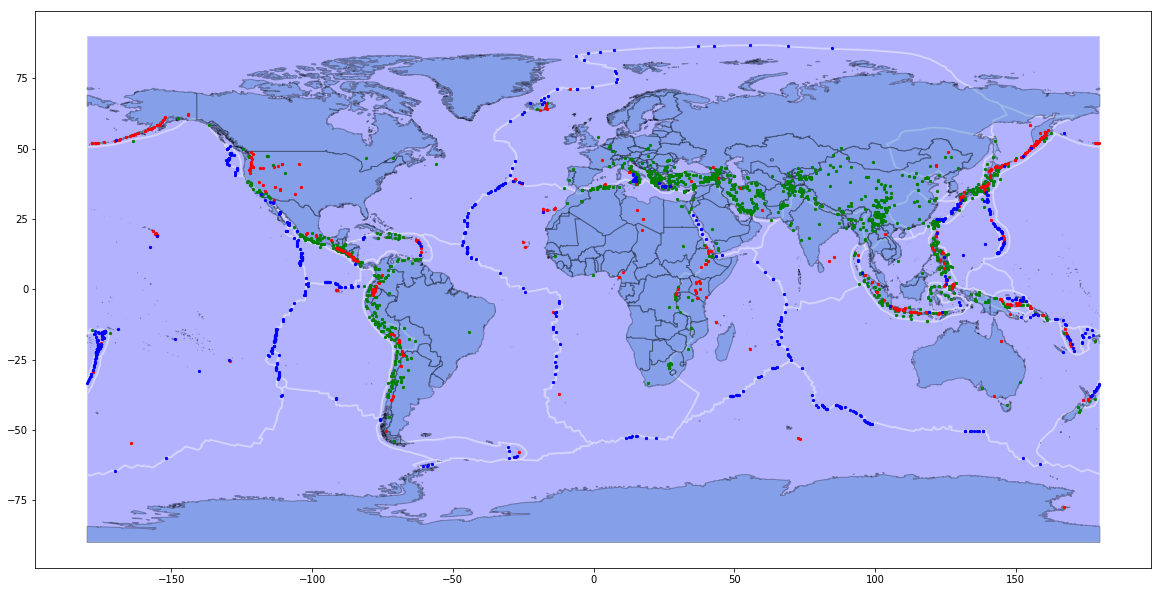

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
earthquakes_gdf.plot(ax=ax, markersize=5, color="green")
volcanoes_gdf.plot(ax=ax, markersize=5, color="red")
vents_gdf.plot(ax=ax, markersize=5, color="blue")

In [38]:
# Now that we have our data plotted out, we want to categorize the earthquakes based on location. 
# How close are they to the plates, and which plates are they closest to?
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

In [39]:
class ClosestPointLogic(object):
    def __init__(self, from_df, to_df, categories, extra_column_name):
        self._from_df = from_df
        self._to_df = to_df
        self._categories = categories
        self._extra_column_name = extra_column_name
    
    # We are wanting to grab the geometry columns per type of volcano
    def get_geometries_from_gdf(self, column):
        geometry_types = list()
        for df_type in self._categories:
            if df_type == 'None':
                df_type_geometry = self._to_df[self._to_df[column].str.contains("")].geometry
            else: 
                df_type_geometry = self._to_df[self._to_df[column].str.contains(df_type)].geometry

            geometry_types.append(df_type_geometry)
            
        # Add on the geometry from the overall df to compare against        
        geometry_types.extend([self._to_df.geometry]) 
        
        return geometry_types
    
    def calculate_nearest(self, to_column, dist_df):
        # Determine closest point based on category
        conditions = list()
        for col in self._categories:
            if not col == self._extra_column_name:
                dist_bool = (dist_df[self._extra_column_name] == dist_df[col])
                conditions.append(dist_bool)

        dist_df[to_column] = np.select(conditions, self._categories, default=np.nan)
        
        return dist_df
    
    def create_total_dist_df(self, series_geometry_list):
        total_dist_list = self._calculate_total_dist_list(series_geometry_list)
        
        dist_pd = pd.DataFrame(total_dist_list)
        dist_pd = dist_pd.transpose()

        dist_pd.columns = self._categories + [self._extra_column_name]

        return pd.concat([self._from_df, dist_pd], axis=1)
    
    def _calculate_total_dist_list(self, series_geometry_list):
        total_dist_list = []

        for geoseries in series_geometry_list:
            dist_list = self._quake_distance(geoseries)
            total_dist_list.append(dist_list)
            
        return total_dist_list
    
    def _quake_distance(self, geoseries):
        dist_list = []
        for quake in self._from_df.geometry:
            print(quake)
            dist = np.min([quake.distance(series) for series in geoseries if series])
            print(dist)
            dist_list.append(dist)

        return dist_list

In [40]:
vol_types = ["Stratovolcano", "Caldera", "Shield", "Complex Volcano", "Submarine", "Volcanic Field", "Cinder Cone", "Dome",
        "Fissure vents", "Somma Volcano", "Maar", "Pyroclastic Cone", "Tuff Ring", "Plug", "None"]

volcanoes_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=volcanoes_gdf,
    categories=vol_types,
    extra_column_name='vol'
)

In [41]:
vol_series_geometry_list = volcanoes_to_earthquake_logic.get_geometries_from_gdf(column='Type')

quake_vol_dist = volcanoes_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=vol_series_geometry_list
)

quake_vol_dist = volcanoes_to_earthquake_logic.calculate_nearest(
    to_column='closest_vol',
    dist_df=quake_vol_dist
)

POINT (141.1000061035156 38.70000076293945)
1.10163363025
POINT (43.09999847412109 40.29999923706055)
1.3416407865
POINT (-66 11)
5.35362463221
POINT (100.0999984741211 26)
7.38312448136
POINT (28.70000076293945 43.40000152587891)
6.98195685493
POINT (142.5 40.5)
1.82187269177
POINT (173 -43)
3.86005428375
POINT (141.3000030517578 40.5)
0.763682013248
POINT (48.59999847412109 40.70000076293945)
4.41474726782
POINT (33.59999847412109 40.70000076293945)
7.63974393086
POINT (-91 14)
0.48507825162
POINT (129.6000061035156 43.20000076293945)
7.88156355242
POINT (77 40)
20.8086520467
POINT (138 -35)
27.9575550797
POINT (72.30000305175781 40.79999923706055)
17.751902871
POINT (35.29999923706055 32.20000076293945)
9.24833415835
POINT (42.65000152587891 39.13999938964844)
1.74243909076
POINT (42.70000076293945 40.90000152587891)
1.99999923706
POINT (22.96999931335449 36.36000061035156)
1.50880869981
POINT (58.20000076293945 35.20000076293945)
6.13600862601
POINT (120.5 23.5)
3.38541143917
POINT

14.8365255896
POINT (103 26.60000038146973)
7.1170573673
POINT (94.75900268554688 5.296000003814697)
7.42928055348
POINT (-95.87799835205078 18.52300071716309)
2.78668204892
POINT (115.1529998779297 35.25199890136719)
10.7066381576
POINT (121.5469970703125 14.31799983978271)
1.09577566579
POINT (-98.28700256347656 17.43099975585938)
1.62351851009
POINT (34.01499938964844 39.43899917602539)
7.42346375755
POINT (119.5250015258789 -0.3659999966621399)
5.41023290568
POINT (142.0449981689453 37.00899887084961)
1.86499431458
POINT (-72.19999694824219 -36.20000076293945)
1.94509381066
POINT (159.2339935302734 -9.295000076293945)
0.608799765198
POINT (139.968994140625 39.8390007019043)
0.80020134212
POINT (-0.1299999952316284 5.179999828338623)
9.35149193272
POINT (102.5 24.39999961853027)
5.01662238793
POINT (39.53300094604492 39.77000045776367)
4.60244475356
POINT (102.3000030517578 23.89999961853027)
4.58415682928
POINT (43.79999923706055 41.70000076293945)
2.06155281281
POINT (-115.6969985

0.3756235323
POINT (-70.46099853515625 18.29100036621094)
7.26114791402
POINT (-99.6510009765625 17.17099952697754)
2.11701719225
POINT (-99.76399993896484 17.00799942016602)
2.31449297935
POINT (-76.62599945068359 5.096000194549561)
1.32214654916
POINT (22.73699951171875 37.87400054931641)
2.06845062317
POINT (49.81000137329102 35.55599975585938)
2.33350236427
POINT (122.0599975585938 24.35600090026855)
3.8863231821
POINT (41.52700042724609 43.16299819946289)
0.937987117531
POINT (-78.21199798583984 -10.69400024414062)
8.14508616207
POINT (42.09999847412109 21.39999961853027)
6.87479416884
POINT (119.4189987182617 -3.736999988555908)
4.73082724962
POINT (120.6559982299805 23.14999961853027)
3.00262022472
POINT (-147.6479949951172 61.01699829101562)
4.61069838532
POINT (95.40399932861328 5.986999988555908)
7.25748836553
POINT (35.11199951171875 -3.930000066757202)
1.77354043946
POINT (38.47499847412109 38.08000183105469)
6.04607562205
POINT (139.2259979248047 38.43399810791016)
1.20807

3.8120484159
POINT (-71.39299774169922 -29.90999984741211)
3.98330431585
POINT (-69.66600036621094 10.0649995803833)
7.66474594796
POINT (94.59799957275391 21.45199966430664)
9.22864578775
POINT (5.241000175476074 36.31999969482422)
9.86033352097
POINT (78.60500335693359 31.9370002746582)
19.0169955848
POINT (40.76800155639648 38.51499938964844)
3.72548464913
POINT (125.9970016479492 12.53499984741211)
1.91542324917
POINT (-92.81800079345703 16.89999961853027)
2.48745163986
POINT (-155.0339965820312 19.45199966430664)
36.3413576327
POINT (40.5260009765625 38.59500122070312)
3.9324403185
POINT (21.7140007019043 38.5260009765625)
3.28105956439
POINT (-16.57799911499023 66.22599792480469)
1.20830387755
POINT (-89.14499664306641 15.29599952697754)
1.5251685549
POINT (-90.46900177001953 14.8120002746582)
0.436351793907
POINT (-76.89900207519531 19.86400032043457)
12.046449765
POINT (-91.00599670410156 14.72500038146973)
0.216986815415
POINT (67.75800323486328 36.58700180053711)
11.572519782

3.49054908816
POINT (-77.53800201416016 -12.34099960327148)
6.64681172921
POINT (-76.01000213623047 -12.74300003051758)
5.15063080229
POINT (26.78300094604492 -27.92600059509277)
26.5209907954
POINT (-98.34700012207031 16.51799964904785)
2.51685090536
POINT (99.87200164794922 31.87100028991699)
12.9167269362
POINT (-89.31300354003906 13.33699989318848)
0.393672255672
POINT (-89.10199737548828 14.49400043487549)
0.786792663299
POINT (1.360999941825867 35.58499908447266)
13.8066415015
POINT (19.66600036621094 40.77999877929688)
4.88016704853
POINT (44.22299957275391 14.67500019073486)
2.6507650248
POINT (68.93299865722656 36.13600158691406)
12.0827557632
POINT (122.9700012207031 -8.430000305175781)
0.219546924846
POINT (75.17299652099609 39.99399948120117)
19.3410404834
POINT (21.54000091552734 41.95899963378906)
6.00558630869
POINT (137.5800018310547 34.79700088500977)
1.28041190743
POINT (52.29499816894531 36.04199981689453)
0.206610557848
POINT (-76.65899658203125 2.438999891281128)
0

12.6006767207
POINT (2.437000036239624 36.70600128173828)
12.6046634436
POINT (106.8259963989258 29.88299942016602)
10.8571408539
POINT (57.71599960327148 29.89800071716309)
2.96969098302
POINT (126.6859970092773 8.364999771118164)
2.15439581
POINT (151.6020050048828 -33.02000045776367)
22.2439171424
POINT (124.6309967041016 9.767000198364258)
0.571183398682
POINT (120.9820022583008 31.7450008392334)
8.91578506332
POINT (66.35399627685547 28.9060001373291)
6.41826338935
POINT (125.5640029907227 9.282999992370605)
0.867983566572
POINT (122.8160018920898 1.195000052452087)
1.91588794399
POINT (100.2779998779297 36.05899810791016)
16.88307774
POINT (100.2779998779297 36.05899810791016)
16.88307774
POINT (15.85099983215332 40.66500091552734)
1.98154125264
POINT (15.80500030517578 40.71200180053711)
2.01199222656
POINT (-77.19699859619141 -6.021999835968018)
4.18125896329
POINT (26.64900016784668 45.85499954223633)
9.27908046967
POINT (-77.13300323486328 -6.099999904632568)
4.27397140476
PO

8.40140948371
POINT (48.06900024414062 38.10800170898438)
4.09143368261
POINT (76.81700134277344 39.45000076293945)
20.3448777739
POINT (71.52300262451172 34.79000091552734)
13.3747411907
POINT (76.83000183105469 39.52500152587891)
20.3979072898
POINT (76.89199829101562 39.5359992980957)
20.4552899288
POINT (59.81000137329102 33.84799957275391)
5.8510852396
POINT (59.88000106811523 33.39899826049805)
5.40033165283
POINT (70.96800231933594 36.46699905395508)
13.855942691
POINT (80.08300018310547 23.07200050354004)
12.819846559
POINT (-7.230999946594238 42.83000183105469)
17.3355966298
POINT (-63.53200149536133 10.44999980926514)
3.71837467959
POINT (26.61899948120117 -26.85700035095215)
25.4732359837
POINT (12.7810001373291 43.07799911499023)
4.92818111242
POINT (119.6579971313477 -3.773000001907349)
4.7741474077
POINT (-71.16699981689453 -30.87800025939941)
4.57943574152
POINT (-71.38700103759766 46.77099990844727)
30.2611070183
POINT (92.71499633789062 22.26000022888184)
11.2464067494

34.3528200244
POINT (101.2559967041016 25.88199996948242)
6.79638913417
POINT (100.9779968261719 38.38600158691406)
19.0600005916
POINT (100.9940032958984 38.37099838256836)
19.0429284636
POINT (103.8649978637695 34.7130012512207)
15.2049749323
POINT (103.9739990234375 27.46199989318848)
7.95987512623
POINT (125.4160003662109 12.11299991607666)
1.48453034909
POINT (80.54599761962891 42.8849983215332)
25.3712670795
POINT (-121.0749969482422 35.62900161743164)
5.88754429154
POINT (-82.84200286865234 8.369000434875488)
2.2976300974
POINT (58.26800155639648 28.95000076293945)
1.97542908206
POINT (115.7580032348633 -8.348999977111816)
0.248164344265
POINT (135.5970001220703 -3.66100001335144)
9.03305795406
POINT (73.17800140380859 34.75099945068359)
14.8066105028
POINT (73.16899871826172 34.77199935913086)
14.8081903878
POINT (100.5479965209961 -0.515999972820282)
0.482411693433
POINT (29.44599914550781 -3.359999895095825)
1.85000423245
POINT (-3.984999895095825 35.18399810791016)
14.420553

4.66400017723
POINT (26.89999961853027 38.59999847412109)
7.62005988931
POINT (50 33)
16.4516042509
POINT (38 40)
3.76235267974
POINT (122.5 25)
9.72214855199
POINT (-8.800000190734863 38.90000152587891)
21.685453391
POINT (103 24.39999961853027)
20.7797982474
POINT (101 -2)
5.06806583959
POINT (5.400000095367432 43.70000076293945)
7.56114413515
POINT (136.3000030517578 35.40000152587891)
5.76944777677
POINT (68 30)
34.5594453676
POINT (131.1000061035156 32.29999923706055)
0.580087936604
POINT (122 35)
9.31558649335
POINT (24.5 36)
10.3443369824
POINT (123 25)
9.32524395973
POINT (3.400000095367432 36.09999847412109)
10.8713801656
POINT (77.5 43.5)
43.2618222416
POINT (73 40)
38.5065613324
POINT (56 32)
22.4623079029
POINT (-102.5 17.5)
9.27105374764
POINT (130 28)
2.80717003314
POINT (20.5 38)
8.64597591719
POINT (-20 64)
2.7028316391
POINT (97 21)
18.5106809576
POINT (27 40.5)
7.7637174126
POINT (-99.91999816894531 19.82999992370605)
7.13140429318
POINT (126.5 4.5)
3.39166660628
POIN

7.07097595462
POINT (-72.91999816894531 -37.25400161743164)
2.2146464528
POINT (20.76600074768066 38.04600143432617)
8.86748065674
POINT (32.5 35)
4.10186538911
POINT (178.1999969482422 -18.29999923706055)
9.7712112214
POINT (-80.84700012207031 -3.596999883651733)
11.1788997639
POINT (101.2119979858398 38.87599945068359)
30.2006117727
POINT (22.23900032043457 39.1870002746582)
9.87215153991
POINT (123.9000015258789 13)
3.07703125
POINT (52 27.5)
20.6904634371
POINT (1.600000023841858 36.20000076293945)
12.4012451687
POINT (122.8779983520508 7.386000156402588)
6.87819306031
POINT (101.6129989624023 29.98100090026855)
25.1169360432
POINT (74.63999938964844 39.81600189208984)
40.1393427421
POINT (-71.59999847412109 -29.89999961853027)
9.07035442287
POINT (23 39.5)
10.5386385215
POINT (27.20000076293945 37.59999847412109)
7.38398929444
POINT (29.60000038146973 32.20000076293945)
8.04880656638
POINT (-84.5 10)
2.58379765955
POINT (101.6999969482422 26.60000038146973)
23.0404892512
POINT (19

3.63275218736
POINT (49.63399887084961 32.12799835205078)
16.4296174432
POINT (122.0090026855469 23.21699905395508)
9.27315708847
POINT (59.47100067138672 33.90900039672852)
25.3826185827
POINT (-72.55300140380859 -16.53700065612793)
22.4567721003
POINT (-101.2210006713867 17.75799942016602)
8.00090251985
POINT (101.1060028076172 23.16200065612793)
20.7074608437
POINT (19.1560001373291 41.99900054931641)
6.46160210612
POINT (115.8639984130859 -8.345000267028809)
15.0586629982
POINT (74.29100036621094 34.52500152587891)
39.9761734525
POINT (119.2699966430664 31.47200012207031)
11.0610462043
POINT (135.9739990234375 -1.682000041007996)
8.99525446385
POINT (13.01000022888184 42.77299880981445)
1.08809362296
POINT (115.7819976806641 -8.36299991607666)
15.1333801293
POINT (-90.84100341796875 13.82900047302246)
1.30137176116
POINT (108.1650009155273 -7.745999813079834)
13.9200746575
POINT (20.375 39.52000045776367)
7.98684692987
POINT (59.72600173950195 33.95600128173828)
25.6248215988
POINT

15.9681614716
POINT (31.70100021362305 15.40100002288818)
10.3632665906
POINT (-92.64600372314453 14.75800037384033)
2.6667322331
POINT (-122.0039978027344 42.30500030517578)
0.643785262003
POINT (76.47799682617188 18.05999946594238)
27.1890145751
POINT (137.9259948730469 32.02999877929688)
6.86879040881
POINT (146.1309967041016 -5.843999862670898)
4.05775447518
POINT (146.2799987792969 -5.876999855041504)
3.91938575581
POINT (-86.08399963378906 11.7180004119873)
0.272800580227
POINT (75.50499725341797 39.32600021362305)
40.9919687149
POINT (-118.5630035400391 34.16400146484375)
9.46569143813
POINT (127.7730026245117 1.042999982833862)
0.366958932057
POINT (30.08099937438965 0.5580000281333923)
12.659519474
POINT (104.254997253418 -4.999000072479248)
9.32050515127
POINT (60.53200149536133 30.78800010681152)
27.1511273351
POINT (52.63800048828125 29.14299964904785)
20.4237669143
POINT (-72.81400299072266 19.94099998474121)
15.5400534737
POINT (67.12400054931641 36.93399810791016)
32.645

11.9558013702
POINT (115.6630020141602 29.7140007019043)
14.6864650253
POINT (55.83300018310547 26.7859992980957)
24.1680090851
POINT (29.78899955749512 -6.245999813079834)
18.011437996
POINT (71.12000274658203 36.28499984741211)
36.6712611161
POINT (79.20099639892578 30.45999908447266)
34.0968064114
POINT (88.38800048828125 27.38199996948242)
26.9104923462
POINT (33.58300018310547 -21.32399940490723)
30.7367984935
POINT (73.88700103759766 33.12900161743164)
39.4384937981
POINT (127.213996887207 -3.595000028610229)
4.85175880439
POINT (5.328000068664551 36.62300109863281)
8.9681555115
POINT (55.68500137329102 27.57399940490723)
23.8509808211
POINT (48.77999877929688 33.5)
15.1344788161
POINT (146.8630065917969 -41.16400146484375)
32.5888843496
POINT (110.4459991455078 -7.960999965667725)
15.6857920513
POINT (55.84299850463867 26.75900077819824)
24.1546084041
POINT (107.411003112793 -9.253999710083008)
14.6176992146
POINT (104.1380004882812 27.9950008392334)
21.9054756633
POINT (68.8280

42.30425428
POINT (54.5 39.75)
29.2921919968
POINT (-77.5 -8.5)
15.831278366
POINT (122.5 22.5)
15.0602161699
POINT (134.5 32.5)
3.52277796627
POINT (102 25)
31.0871414145
POINT (59 33)
26.6692699052
POINT (123 24.75)
13.0008693933
POINT (22 37)
3.45253465949
POINT (-75 -10.5)
19.0068247849
POINT (122 10.5)
25.848793341
POINT (-70.25 -17.5)
26.961860366
POINT (100.5 29.5)
31.4993710991
POINT (-76.5 -13)
19.2808034099
POINT (135.25 33.75)
3.72625219817
POINT (99.69999694824219 26.39999961853027)
32.9123166958
POINT (136 36.5)
3.39329228775
POINT (20.5 38.5)
5.33104022241
POINT (-65 -24.5)
35.5192826946
POINT (58 37.5)
29.5042362275
POINT (104 27.39999961853027)
28.4986024628
POINT (-106.5 22)
20.9781815403
POINT (83.5 41)
48.5372082753
POINT (-122.5 47.25)
3.03191362491
POINT (-73.5 -38)
41.4966190942
POINT (70.5 39)
39.1560970367
POINT (26.29999923706055 38.59999847412109)
2.37696989582
POINT (-78.25 -1.5)
12.9144055489
POINT (40.59999847412109 39.5)
15.5128964333
POINT (-71 -54)
57.22

34.3408609954
POINT (117.8880004882812 39.60499954223633)
14.6314769698
POINT (118.359001159668 39.72299957275391)
14.2339009572
POINT (104.0879974365234 32.75299835205078)
27.5674198221
POINT (124.088996887207 6.291999816894531)
29.1908638752
POINT (122.9599990844727 7.258999824523926)
28.5783451559
POINT (29.01499938964844 37.74300003051758)
3.85640614156
POINT (104.181999206543 32.48099899291992)
27.4922437656
POINT (13.18099975585938 46.3390007019043)
15.7507987818
POINT (13.20600032806396 46.31399917602539)
15.7156281485
POINT (13.08699989318848 46.35400009155273)
15.8332577091
POINT (-78.73200225830078 -0.7260000109672546)
12.3915363091
POINT (139.9909973144531 -4.474999904632568)
12.2107205777
POINT (101.0210037231445 27.55400085449219)
31.3579701305
POINT (59.18000030517578 33.81999969482422)
27.3926770381
POINT (44.03099822998047 39.08200073242188)
18.8230504702
POINT (-68.89600372314453 -20.47200012207031)
29.9263746752
POINT (26.67700004577637 -27.97900009155273)
23.28885328

25.9293351817
POINT (122.8160018920898 1.195000052452087)
29.3122551169
POINT (100.2779998779297 36.05899810791016)
31.3607804287
POINT (100.2779998779297 36.05899810791016)
31.3607804287
POINT (15.85099983215332 40.66500091552734)
10.4581841977
POINT (15.80500030517578 40.71200180053711)
10.5193801239
POINT (-77.19699859619141 -6.021999835968018)
15.0040163509
POINT (26.64900016784668 45.85499954223633)
9.53713740393
POINT (-77.13300323486328 -6.099999904632568)
15.0925496248
POINT (122.0449981689453 11.39000034332275)
25.0074041188
POINT (85.06400299072266 47.87699890136719)
48.4204882805
POINT (65.66500091552734 27.38999938964844)
28.5204366247
POINT (49.21599960327148 37.00099945068359)
23.8235818839
POINT (49.78499984741211 36.63100051879883)
24.3860943305
POINT (70.77500152587891 36.44800186157227)
37.7695226674
POINT (121.1800003051758 15.7209997177124)
21.476204796
POINT (-78.48300170898438 -0.1720000058412552)
12.6396344577
POINT (26.83699989318848 -28.09000015258789)
23.25223

24.242115452
POINT (3.592000007629395 36.8650016784668)
21.8129565206
POINT (49.4630012512207 33.02399826049805)
21.3091968681
POINT (54.16500091552734 28.31100082397461)
19.9429126039
POINT (101.2600021362305 25.95800018310547)
31.5195431694
POINT (92.31700134277344 22.86800003051758)
40.9689868843
POINT (92.16799926757812 22.74300003051758)
41.1474204707
POINT (92.31600189208984 22.83600044250488)
40.9790418697
POINT (119.7180023193359 43.77899932861328)
15.0758695427
POINT (-70.69300079345703 19.76600074768066)
18.1809073546
POINT (143.8780059814453 41.86399841308594)
6.77318990861
POINT (87.81700134277344 50.03099822998047)
46.4560374106
POINT (101.2559967041016 25.88199996948242)
31.5440775893
POINT (100.9779968261719 38.38600158691406)
30.8675956387
POINT (100.9940032958984 38.37099838256836)
30.8498304102
POINT (103.8649978637695 34.7130012512207)
27.7358261386
POINT (103.9739990234375 27.46199989318848)
28.5084147699
POINT (125.4160003662109 12.11299991607666)
23.2254106469
POI

POINT (-90.91300201416016 13.77999973297119)
0.676736044437
POINT (-74.91999816894531 -14.97500038146973)
6.96827535142
POINT (20.39999961853027 41.70000076293945)
42.5705692681
POINT (36.45000076293945 40.67100143432617)
38.3511892368
POINT (30.5 40.79999923706055)
38.9558114114
POINT (-101.5 17.75)
10.7863316351
POINT (-72 -30.75)
9.71695423773
POINT (30.5 40.59999847412109)
38.7582660162
POINT (110 -9.5)
2.30217301092
POINT (134 35.25)
4.46813811063
POINT (34 41)
38.7652847738
POINT (121.5 22.89999961853027)
11.7881292537
POINT (-68.75 -31.25)
9.47373658369
POINT (32.5 41.5)
39.3908276474
POINT (84 44)
40.9884990831
POINT (54.5 36.79999923706055)
38.8632893993
POINT (26.70000076293945 39.40000152587891)
38.3711271274
POINT (136 33.75)
3.66379610655
POINT (136.75 34.75)
2.42711777417
POINT (142.5 41.25)
6.26764667889
POINT (35.79999923706055 37.40000152587891)
35.0884512688
POINT (-70.5 -33.25)
11.680718671
POINT (119 39.5)
13.1488239408
POINT (63 24.5)
34.5035841485
POINT (5 36)
46.

6.57056928806
POINT (-10.56799983978271 35.92300033569336)
57.8891409175
POINT (28.46699905395508 38.53499984741211)
37.1104410937
POINT (41.21900177001953 11.93900012969971)
10.6835567614
POINT (33.93600082397461 27.51099967956543)
25.3283323231
POINT (119.4530029296875 38.42100143432617)
12.2265005717
POINT (111.8089981079102 21.61199951171875)
16.2269548329
POINT (137.0930023193359 35.7859992980957)
1.56267640977
POINT (19.33600044250488 -33.18999862670898)
39.4711379106
POINT (-75.19499969482422 -11.83500003814697)
9.23590828802
POINT (-122.7639999389648 38.29999923706055)
39.4912102296
POINT (17.35300064086914 44.80699920654297)
46.6308713181
POINT (17.23399925231934 44.83700180053711)
46.7073480396
POINT (102.4619979858398 24.14699935913086)
20.1906792124
POINT (143.0240020751953 42.52299880981445)
7.59520647268
POINT (122.0579986572266 12.60000038146973)
2.67831502952
POINT (29.54999923706055 39.17200088500977)
37.514668872
POINT (121.6589965820312 15.77200031280518)
5.130427574

POINT (15.85099983215332 40.66500091552734)
43.584585069
POINT (15.80500030517578 40.71200180053711)
43.6478064401
POINT (-77.19699859619141 -6.021999835968018)
15.0952572994
POINT (26.64900016784668 45.85499954223633)
44.6511189397
POINT (-77.13300323486328 -6.099999904632568)
14.995058613
POINT (122.0449981689453 11.39000034332275)
2.45746493667
POINT (85.06400299072266 47.87699890136719)
44.4194297304
POINT (65.66500091552734 27.38999938964844)
38.0222653266
POINT (49.21599960327148 37.00099945068359)
36.9146724381
POINT (49.78499984741211 36.63100051879883)
36.7679342664
POINT (70.77500152587891 36.44800186157227)
40.5919155946
POINT (121.1800003051758 15.7209997177124)
5.37021755524
POINT (-78.48300170898438 -0.1720000058412552)
12.9533217326
POINT (26.83699989318848 -28.09000015258789)
31.9296005355
POINT (27.34900093078613 -26.38999938964844)
30.1544504066
POINT (103.7180023193359 37.09600067138672)
26.9234399793
POINT (70.42900085449219 35.09000015258789)
39.7705201124
POINT (5

37.7690399813
POINT (73.16899871826172 34.77199935913086)
37.7911508164
POINT (100.5479965209961 -0.515999972820282)
6.87262346223
POINT (29.44599914550781 -3.359999895095825)
9.11118992649
POINT (-3.984999895095825 35.18399810791016)
52.1991414466
POINT (-4.079999923706055 35.22499847412109)
52.2987705206
POINT (-4.177999973297119 35.24599838256836)
52.3881747233
POINT (38.27700042724609 38.05799865722656)
35.7787423521
POINT (-4.160999774932861 35.17399978637695)
52.3297202759
POINT (40.72100067138672 39.80400085449219)
37.7131427247
POINT (71.04199981689453 36.47999954223633)
40.4493254159
POINT (121.5999984741211 24.0580005645752)
12.2979988126
POINT (67.06800079345703 30.16699981689453)
38.6546342912
POINT (51.56499862670898 36.25699996948242)
37.1021557922
POINT (43.90800094604492 39.73500061035156)
38.1277921998
POINT (13.62800025939941 46.30500030517578)
49.608624208
POINT (176.4320068359375 -38.01300048828125)
43.2026361036
POINT (69.47899627685547 33.34400177001953)
39.108425

POINT (-71 -54)
64.9235723744
POINT (-71 -54)
64.9235723744
POINT (121 18)
24.1515473977
POINT (-72 -13.5)
27.802331242
POINT (112 -6.25)
42.4531473913
POINT (-68 10.5)
6.60981152911
POINT (96.5 28.5)
49.198040411
POINT (-67.5 -23.5)
36.2764334081
POINT (-96.80000305175781 16.10000038146973)
35.3647544735
POINT (33.40000152587891 40.79999923706055)
59.3663076693
POINT (121.5 23.75)
23.7644638493
POINT (122.5 23)
22.6772406743
POINT (41.70000076293945 39.90000152587891)
67.619127499
POINT (143 42.5)
11.1542076414
POINT (-68.46700286865234 -31.58099937438965)
44.4088966237
POINT (135.8000030517578 34.40000152587891)
16.7521121552
POINT (-119.0459976196289 34.94900131225586)
15.524566244
POINT (91.64800262451172 30.79700088500977)
54.3812436347
POINT (-118.9169998168945 35.33300018310547)
15.3477553528
POINT (35.5 36.5)
61.3898549731
POINT (160.0570068359375 52.75500106811523)
8.80403001226
POINT (-73.40000152587891 18.39999961853027)
13.2479297727
POINT (55.09999847412109 35.400001525878

16.7966215012
POINT (-77.96099853515625 -8.166000366210938)
26.1769400791
POINT (-118.1370010375977 34.02000045776367)
16.824257834
POINT (-115.7559967041016 33.25699996948242)
19.0788862106
POINT (124.1490020751953 -8.258999824523926)
33.8095604285
POINT (140.3220062255859 35.42100143432617)
15.7224436914
POINT (26.69400024414062 -26.90500068664551)
83.2161061944
POINT (91.57900238037109 24.71299934387207)
53.6231186966
POINT (-118.0500030517578 34.08000183105469)
16.8433756031
POINT (121.0849990844727 12.35499954223633)
25.2667220668
POINT (121.6790008544922 23.98600006103516)
23.6217158559
POINT (95.12599945068359 25.10499954223633)
50.1234313369
POINT (160.9329986572266 -10.31999969482422)
3.25396638154
POINT (51.58499908447266 29.94400024414062)
77.8424065791
POINT (51.65499877929688 29.88599967956543)
77.9177879753
POINT (86.61799621582031 26.76300048828125)
58.7553886695
POINT (18.48900032043457 49.88600158691406)
46.0386140913
POINT (146.2259979248047 -6.061999797821045)
12.091

37.3678986332
POINT (108.2259979248047 9.972999572753906)
38.2579965291
POINT (115.6630020141602 29.7140007019043)
30.8025801944
POINT (55.83300018310547 26.7859992980957)
82.4254623278
POINT (29.78899955749512 -6.245999813079834)
70.862606388
POINT (71.12000274658203 36.28499984741211)
75.5935561493
POINT (79.20099639892578 30.45999908447266)
66.5902330262
POINT (88.38800048828125 27.38199996948242)
57.0682522328
POINT (33.58300018310547 -21.32399940490723)
83.7131161588
POINT (73.88700103759766 33.12900161743164)
72.2692524373
POINT (127.213996887207 -3.595000028610229)
29.9020091876
POINT (5.328000068664551 36.62300109863281)
31.2232884203
POINT (55.68500137329102 27.57399940490723)
82.1788900476
POINT (48.77999877929688 33.5)
74.7724901277
POINT (146.8630065917969 -41.16400146484375)
31.5906617244
POINT (110.4459991455078 -7.960999965667725)
44.7385090727
POINT (55.84299850463867 26.75900077819824)
82.4389202893
POINT (107.411003112793 -9.253999710083008)
47.9138299271
POINT (104.1

41.0002531308
POINT (22.73699951171875 37.87400054931641)
38.6277316791
POINT (49.81000137329102 35.55599975585938)
40.8109866343
POINT (122.0599975585938 24.35600090026855)
24.6999626263
POINT (41.52700042724609 43.16299819946289)
44.7736457112
POINT (-78.21199798583984 -10.69400024414062)
52.3736611414
POINT (42.09999847412109 21.39999961853027)
24.692969536
POINT (119.4189987182617 -3.736999988555908)
52.8832717488
POINT (120.6559982299805 23.14999961853027)
26.1472814513
POINT (-147.6479949951172 61.01699829101562)
31.9734324676
POINT (95.40399932861328 5.986999988555908)
52.6268207313
POINT (35.11199951171875 -3.930000066757202)
6.46369543413
POINT (38.47499847412109 38.08000183105469)
39.1072082511
POINT (139.2259979248047 38.43399810791016)
16.6604012451
POINT (-100.5100021362305 18.19400024414062)
16.4491984192
POINT (28.20800018310547 40.25)
40.3663206583
POINT (125.9649963378906 -2.454999923706055)
51.175235897
POINT (-70.70999908447266 -25.66699981689453)
69.0639191073
POINT

POINT (55.45700073242188 28.24200057983398)
38.1349461682
POINT (97.40499877929688 3.938999891281128)
53.1967060344
POINT (15.40200042724609 37.2859992980957)
40.0872824874
POINT (121.6449966430664 23.88299942016602)
25.2369241007
POINT (22.34600067138672 40.97700119018555)
41.7497642337
POINT (-84.22899627685547 9.982000350952148)
32.1950329501
POINT (95.88999938964844 23.55900001525879)
39.3310193692
POINT (70.40299987792969 35.94400024414062)
54.1904222755
POINT (6.760000228881836 44.8849983215332)
50.579014095
POINT (113.9889984130859 39.94699859619141)
14.9708664141
POINT (-77.08100128173828 -5.97700023651123)
49.0975854312
POINT (68.26899719238281 37.4640007019043)
53.6674721631
POINT (-83.07199859619141 9.673000335693359)
33.2112932284
POINT (41.16899871826172 39.61299896240234)
41.2562011937
POINT (43.66699981689453 42.42599868774414)
44.6737050865
POINT (43.24499893188477 42.68000030517578)
44.7880923957
POINT (-82.44000244140625 9.546999931335449)
33.7407903602
POINT (116.652

116.641705245
POINT (-70.62799835205078 -13.73099994659424)
30.7717277559
POINT (25.66699981689453 42.40200042724609)
116.274991455
POINT (25.08699989318848 42.38600158691406)
115.710449485
POINT (-78.55899810791016 -5.261000156402588)
19.5469771784
POINT (57.90000152587891 37.29999923706055)
98.9610395062
POINT (-71.68299865722656 -35.08599853515625)
49.9088102044
POINT (124.8560028076172 6.97700023651123)
33.0418811979
POINT (-64.38099670410156 9.49899959564209)
22.5211877287
POINT (57.69300079345703 37.95700073242188)
99.0805350425
POINT (37.90000152587891 40.20000076293945)
118.522771214
POINT (-67.59799957275391 -34.76800155639648)
50.9911340974
POINT (172.2920074462891 -41.83100128173828)
39.6086011149
POINT (58 37.5)
98.8353358838
POINT (-68.73699951171875 -23.03800010681152)
39.8287534926
POINT (-56.00799942016602 44.53900146484375)
44.3605188477
POINT (96.54299926757812 17.66500091552734)
63.288376823
POINT (44.68500137329102 38.15200042724609)
111.973485993
POINT (103 26.7999

109.145993138
POINT (47.07099914550781 43.10200119018555)
109.153402732
POINT (-78.83999633789062 -9.248000144958496)
23.1341779595
POINT (78.71900177001953 42.49200057983398)
77.67012462
POINT (55.88700103759766 37.83599853515625)
100.887326952
POINT (-72.56300354003906 -1.485999941825867)
19.893280358
POINT (145.4709930419922 -4.907000064849854)
9.80187561774
POINT (121.3629989624023 22.8390007019043)
44.334456635
POINT (-80.66200256347656 -4.078999996185303)
17.6536768028
POINT (-118.3919982910156 34.4010009765625)
5.55462068995
POINT (95.02799987792969 32.17800140380859)
63.6510630865
POINT (55.60800170898438 28.26399993896484)
102.806598576
POINT (100.9929962158203 22.95299911499023)
61.5018347729
POINT (29.74600028991699 37.55500030517578)
119.108867435
POINT (40.54199981689453 38.86800003051758)
116.017639234
POINT (-69.052001953125 -25.42300033569336)
41.8373548301
POINT (-71.08499908447266 -32.55799865722656)
47.6964640396
POINT (153.906005859375 -5.519000053405762)
1.41844061

106.009180773
POINT (26.65999984741211 -6.151000022888184)
114.885690162
POINT (31.14399909973145 29.7140007019043)
119.093177961
POINT (-76.76399993896484 7.092999935150146)
11.3167101558
POINT (31.53499984741211 29.7549991607666)
119.486001086
POINT (-4.290999889373779 31.27499961853027)
84.5184476806
POINT (45.09600067138672 42.56100082397461)
111.161450573
POINT (121.8320007324219 -8.498000144958496)
33.4540517219
POINT (100.7519989013672 26.32799911499023)
60.2970403092
POINT (26.79999923706055 -28.02799987792969)
120.52210829
POINT (-76.59400177001953 18.05200004577637)
11.5258362175
POINT (144.1940002441406 43.02199935913086)
13.9765868924
POINT (144.1410064697266 43.02399826049805)
14.0201928488
POINT (101.4150009155273 25.82600021362305)
59.8959446541
POINT (86.14399719238281 42.20000076293945)
70.3234904785
POINT (-178.1620025634766 -14.40900039672852)
79.4586351219
POINT (87.35600280761719 29.00900077819824)
71.9158911009
POINT (21.52599906921387 37.61299896240234)
111.09917

POINT (138 -35)
38.6262138105
POINT (72.30000305175781 40.79999923706055)
45.3484601677
POINT (35.29999923706055 32.20000076293945)
9.3041106141
POINT (42.65000152587891 39.13999938964844)
15.7054472173
POINT (42.70000076293945 40.90000152587891)
16.1247192576
POINT (22.96999931335449 36.36000061035156)
1.31320081911
POINT (58.20000076293945 35.20000076293945)
31.0947676898
POINT (120.5 23.5)
14.6667350155
POINT (27 37.75)
1.0890380086
POINT (101 30)
30.6062550182
POINT (120.3000030517578 23.5)
14.8163775989
POINT (76 33)
48.9976381696
POINT (19.60000038146973 42.09999847412109)
5.8359227365
POINT (132.5 34.09999847412109)
1.34807832613
POINT (16 39)
7.46860128726
POINT (24 40)
2.46981879554
POINT (-81.5 1)
92.6272827928
POINT (120.4000015258789 23.60000038146973)
14.6752537882
POINT (120.4000015258789 23.60000038146973)
14.6752537882
POINT (-123 38)
37.1784087922
POINT (-72 -33)
108.751041889
POINT (85 43.5)
47.54148341
POINT (94.5 2)
48.3969284425
POINT (-76.69999694824219 18.2000007

42.5460227228
POINT (73.32099914550781 35.94900131225586)
46.1866276634
POINT (-86.12799835205078 12.34700012207031)
82.0961671143
POINT (-102.9599990844727 18.45499992370605)
64.9649084836
POINT (100.5449981689453 31.35300064086914)
30.945051422
POINT (122.8040008544922 13.41499996185303)
21.6570060931
POINT (-84.86000061035156 10.67300033569336)
84.09677644
POINT (-78.11399841308594 4.907000064849854)
90.8031763057
POINT (101.0780029296875 23.00300025939941)
32.0446560307
POINT (-96.60800170898438 18.23299980163574)
70.1439152953
POINT (52.95100021362305 30.53499984741211)
26.5300955132
POINT (-28.32900047302246 38.48600006103516)
32.1376702594
POINT (4.473000049591064 36.20100021362305)
9.69619629464
POINT (-76.30699920654297 -12.35099983215332)
98.3059286477
POINT (27.26300048828125 38.54000091552734)
1.87404363409
POINT (119.2799987792969 31.53300094604492)
12.2749481919
POINT (138.77099609375 34.56999969482422)
7.45348465784
POINT (104.0070037841797 28.19499969482422)
27.89045599

77.1622622633
POINT (140.2630004882812 -3.664999961853027)
37.9862469718
POINT (119.9049987792969 0.7139999866485596)
34.5451843486
POINT (100.2620010375977 27.27099990844727)
31.7419559918
POINT (136.9730072021484 -0.9179999828338623)
34.6443087588
POINT (-79.86799621582031 -9.722000122070312)
99.7126145673
POINT (76.62100219726562 40.04299926757812)
49.5958342531
POINT (-78.65899658203125 -1.031000018119812)
94.0986859423
POINT (155.1159973144531 -6.51800012588501)
38.1570687998
POINT (109.7129974365234 40.77700042724609)
22.9746145981
POINT (35.29299926757812 40.69699859619141)
9.09330190033
POINT (100.3320007324219 27.21199989318848)
31.6844711711
POINT (32.14300155639648 34.5620002746582)
5.42896728695
POINT (-75.56199645996094 -14.95899963378906)
99.2799093508
POINT (-102.7949981689453 18.19300079345703)
65.2581377503
POINT (76.87899780273438 39.5359992980957)
49.8215006359
POINT (35.90200042724609 36.19900131225586)
8.77465100285
POINT (57.30500030517578 37.7239990234375)
30.183

POINT (34.01499938964844 39.43899917602539)
21.6956195454
POINT (119.5250015258789 -0.3659999966621399)
107.745966578
POINT (142.0449981689453 37.00899887084961)
126.785479617
POINT (-72.19999694824219 -36.20000076293945)
86.9074551978
POINT (159.2339935302734 -9.295000076293945)
148.416262282
POINT (139.968994140625 39.8390007019043)
124.951125725
POINT (-0.1299999952316284 5.179999828338623)
27.0230373775
POINT (102.5 24.39999961853027)
86.9945194596
POINT (39.53300094604492 39.77000045776367)
26.6885587612
POINT (102.3000030517578 23.89999961853027)
86.8168701674
POINT (43.79999923706055 41.70000076293945)
31.3697048464
POINT (-115.6969985961914 33.22200012207031)
101.317762543
POINT (-77.62899780273438 -11.11900043487549)
74.8645180761
POINT (102.5 24.39999961853027)
86.9945194596
POINT (139.8289947509766 44.50799942016602)
125.340842348
POINT (26.65500068664551 45.77299880981445)
20.9412303505
POINT (43.5 16.39999961853027)
30.2338620277
POINT (58.59999847412109 33.5)
43.370154199

POINT (15.98999977111816 38.04600143432617)
10.0543644599
POINT (66.23400115966797 29.92799949645996)
50.6906798462
POINT (-99.78199768066406 16.93199920654297)
86.5200519171
POINT (15.07299995422363 38.38100051879883)
10.3933738863
POINT (142.1049957275391 38.23500061035156)
126.93829131
POINT (142.0090026855469 38.2239990234375)
126.841723795
POINT (23.25699996948242 40.73199844360352)
14.8674178683
POINT (23.30299949645996 40.7599983215332)
14.9151694448
POINT (23.11199951171875 40.71799850463867)
14.78101836
POINT (-90.98999786376953 14.75800037384033)
78.1626183742
POINT (57.38199996948242 33.24200057983398)
42.1293932772
POINT (-96.60299682617188 16.01099967956543)
83.5011922859
POINT (49.63399887084961 32.12799835205078)
34.3032828558
POINT (122.0090026855469 23.21699905395508)
106.536424414
POINT (59.47100067138672 33.90900039672852)
44.2869758769
POINT (-72.55300140380859 -16.53700065612793)
73.7689156927
POINT (-101.2210006713867 17.75799942016602)
87.8431378509
POINT (101.10

85.5750294974
POINT (138.4600067138672 37.52000045776367)
123.248231133
POINT (70.48500061035156 38.93600082397461)
55.9835262771
POINT (141.8099975585938 47.11000061035156)
127.668337603
POINT (-76.61000061035156 -13.38000011444092)
75.2312154601
POINT (101.370002746582 -4.440000057220459)
91.7184724473
POINT (100.8300018310547 -2.660000085830688)
90.5957969801
POINT (99.61000061035156 -2.150000095367432)
89.2752122436
POINT (76.75299835205078 35.30400085449219)
61.6075008842
POINT (70.7239990234375 21.18099975585938)
55.5640117436
POINT (124.6470031738281 9.720999717712402)
110.588123455
POINT (-69.88999938964844 -22.24699974060059)
75.3825262589
POINT (118.370002746582 -8.291999816894531)
109.008687411
POINT (-61.27399826049805 14.94400024414062)
49.1215774804
POINT (-44.23099899291992 -15.04800033569336)
52.8862834639
POINT (178.2910003662109 -39.01100158691406)
175.969724665
POINT (-0.5699999928474426 35.61600112915039)
14.6266539237
POINT (97.44200134277344 1.011000037193298)
86.

POINT (-81.01899719238281 -5.881999969482422)
106.261883552
POINT (-77.52300262451172 -12.25399971008301)
106.170636998
POINT (72.89800262451172 35.0260009765625)
58.7543846565
POINT (78.4739990234375 32.37300109863281)
64.5986498087
POINT (122.6460037231445 40.66699981689453)
30.2991384884
POINT (106.6340026855469 -6.77400016784668)
70.6072400675
POINT (56.2239990234375 27.47699928283691)
43.8722462253
POINT (-71.39299774169922 -29.90999984741211)
111.212948118
POINT (-69.66600036621094 10.0649995803833)
89.5433267249
POINT (94.59799957275391 21.45199966430664)
63.1078389716
POINT (5.241000175476074 36.31999969482422)
10.2317018811
POINT (78.60500335693359 31.9370002746582)
64.7868713197
POINT (40.76800155639648 38.51499938964844)
26.4386712283
POINT (125.9970016479492 12.53499984741211)
43.4205260694
POINT (-92.81800079345703 16.89999961853027)
109.883120375
POINT (-155.0339965820312 19.45199966430664)
170.805847869
POINT (40.5260009765625 38.59500122070312)
26.190682871
POINT (21.71

POINT (-80.31300354003906 -0.593999981880188)
103.399014245
POINT (77.29799652099609 39.57199859619141)
62.880382115
POINT (15.97500038146973 40)
1.74912113224
POINT (112.3399963378906 -8.177000045776367)
68.1950620518
POINT (20.0939998626709 44.20299911499023)
6.59739161064
POINT (53.64199829101562 27.79100036621094)
41.3199178308
POINT (100.9550018310547 27.26300048828125)
55.004338232
POINT (124.818000793457 -1.939000010490417)
56.2076503485
POINT (71 36.51800155639648)
56.7333416384
POINT (-75.65899658203125 4.443999767303467)
97.1557550064
POINT (69.16500091552734 34.32300186157227)
55.119245937
POINT (46.90900039672852 43.26200103759766)
32.5706741948
POINT (57.20700073242188 28.27099990844727)
44.5796944941
POINT (79.4010009765625 30.47500038146973)
65.7894363788
POINT (-72.51799774169922 -16.60199928283691)
104.198082185
POINT (26.67900085449219 -27.95299911499023)
69.8553031613
POINT (51.90700149536133 29.51899909973145)
39.1438147433
POINT (47.48300170898438 40.76699829101562

62.9858276777
POINT (92.47799682617188 12.14900016784668)
54.2829808173
POINT (43.29999923706055 39.5)
31.8371637486
POINT (102.3000030517578 31.70000076293945)
68.1830302388
POINT (39.40000152587891 39.70000076293945)
31.667412945
POINT (132 32)
96.6639812788
POINT (120.390998840332 23.25099945068359)
83.4373784319
POINT (99.14499664306641 21.07600021362305)
62.1748219053
POINT (100.3000030517578 23.10000038146973)
63.7519064257
POINT (-79.90200042724609 0.01200000010430813)
52.7204338053
POINT (-90.91300201416016 13.77999973297119)
35.2747747522
POINT (-74.91999816894531 -14.97500038146973)
67.1735134442
POINT (20.39999961853027 41.70000076293945)
38.1382353738
POINT (36.45000076293945 40.67100143432617)
32.6762867143
POINT (30.5 40.79999923706055)
33.6776619375
POINT (-101.5 17.75)
25.0147020828
POINT (-72 -30.75)
81.5994802964
POINT (30.5 40.59999847412109)
33.4832027186
POINT (110 -9.5)
73.7680501664
POINT (134 35.25)
99.4422585299
POINT (34 41)
33.2358988769
POINT (121.5 22.89999

POINT (-70.38400268554688 -20.27599906921387)
74.1487651801
POINT (-74.46299743652344 -13.1850004196167)
66.094056012
POINT (57.76699829101562 29.97599983215332)
29.2876995028
POINT (73.59700012207031 35.68500137329102)
44.7888871879
POINT (-73.03299713134766 -33.17800140380859)
83.070026713
POINT (-72.50099945068359 8.111000061035156)
53.4428917628
POINT (-102.0090026855469 18.11499977111816)
24.4094931283
POINT (67.08000183105469 29.91200065612793)
36.1020796802
POINT (121.7519989013672 23.95100021362305)
84.9042724307
POINT (-77.53800201416016 -12.34099960327148)
63.4781510966
POINT (-76.01000213623047 -12.74300003051758)
64.7582379904
POINT (26.78300094604492 -27.92600059509277)
37.7897878316
POINT (-98.34700012207031 16.51799964904785)
28.0224289615
POINT (99.87200164794922 31.87100028991699)
65.9726982944
POINT (-89.31300354003906 13.33699989318848)
36.7773695878
POINT (-89.10199737548828 14.49400043487549)
36.208144896
POINT (1.360999941825867 35.58499908447266)
46.1124947981
PO

66.2817711609
POINT (-122.5810012817383 47.09000015258789)
4.01516311969
POINT (132.5399932861328 34.10800170898438)
97.7280643716
POINT (99.05100250244141 24.80599975585938)
62.9712268538
POINT (100.9010009765625 27.61899948120117)
65.54062593
POINT (69.32399749755859 35.10499954223633)
41.1261669186
POINT (6.869999885559082 49.14699935913086)
51.7682687733
POINT (-73.50499725341797 -16.38500022888184)
69.1610952525
POINT (-71.93099975585938 -17.5319995880127)
71.0485736267
POINT (11.23400020599365 46.72299957275391)
47.2321738149
POINT (-69.23400115966797 -19.5580005645752)
74.3360777118
POINT (-72.68000030517578 -14.34799957275391)
68.1397389675
POINT (100.5859985351562 26.28899955749512)
64.8535334542
POINT (-72.43499755859375 -15.35299968719482)
69.0599834509
POINT (69.84400177001953 38.64400100708008)
43.9074609782
POINT (142.4470062255859 -3.263999938964844)
104.710045467
POINT (28.99600028991699 -1.769999980926514)
13.5620678881
POINT (27.88699913024902 38.63299942016602)
32.32

42.2263612338
POINT (8.899999618530273 36.20000076293945)
4.97200067667
POINT (121.5169982910156 23.91699981689453)
20.7313407737
POINT (22.60700035095215 39.26699829101562)
18.6188386932
POINT (28.60899925231934 36.38700103759766)
24.5507411525
POINT (31.04199981689453 40.67200088500977)
27.1574107732
POINT (52.70100021362305 36.09000015258789)
47.562062679
POINT (-99.2969970703125 16.88100051879883)
105.39759927
POINT (99.20600128173828 45.15299987792969)
33.2917870111
POINT (47.71200180053711 34.27799987792969)
43.7449853245
POINT (-72.50299835205078 -16.77899932861328)
93.8215697729
POINT (-79.48000335693359 1.054000020027161)
91.1304557743
POINT (103.9120025634766 31.57699966430664)
21.7400434237
POINT (124.3509979248047 24.4330005645752)
18.0856670151
POINT (-79.57499694824219 0.7059999704360962)
91.3568616217
POINT (-136.6649932861328 58.36999893188477)
142.295662779
POINT (47.86899948120117 34.25899887084961)
43.9029429402
POINT (-70.11199951171875 -33.78499984741211)
102.83289

POINT (-102.379997253418 18.42000007629395)
108.14217922
POINT (-101.6230010986328 17.83099937438965)
107.502806005
POINT (69.80999755859375 40.33700180053711)
36.959426368
POINT (6.846000194549561 36.38600158691406)
2.9529487686
POINT (15.06799983978271 37.6879997253418)
10.9912677608
POINT (-77.43699645996094 -9.51200008392334)
94.0618581542
POINT (-115.8000030517578 47.47000122070312)
120.30053065
POINT (-71.75700378417969 -13.40200042724609)
91.2914381128
POINT (76.39700317382812 32.11800003051758)
26.4349138207
POINT (37.78099822998047 37.99900054931641)
33.7059717349
POINT (43.70399856567383 41.40399932861328)
39.8237810061
POINT (121.6429977416992 24.14599990844727)
20.503553149
POINT (37.90999984741211 38.00699996948242)
33.8350922261
POINT (-62.9109992980957 10.57299995422363)
72.1703213924
POINT (51.55699920654297 29.9109992980957)
45.8446919641
POINT (-117.8399963378906 33.06600189208984)
121.997716257
POINT (-69.42400360107422 10.74300003051758)
78.1952732833
POINT (100.753

POINT (99.97000122070312 0.7099999785423279)
13.0837512945
POINT (-72.53299713134766 18.45700073242188)
78.9249427592
POINT (-72.71900177001953 -35.84600067138672)
106.141383292
POINT (40.02999877929688 38.79000091552734)
35.9760938019
POINT (-72.12999725341797 -34.30099868774414)
104.651158904
POINT (96.62899780273438 33.16500091552734)
21.0552290141
POINT (172.7012023925781 -43.58340072631836)
85.373794698
POINT (97.99400329589844 24.70999908447266)
13.0836319087
POINT (142.3690032958984 38.32199859619141)
4.73248418836
POINT (99.94899749755859 20.70499992370605)
10.3752102784
POINT (140 38.20000076293945)
3.4205239333
POINT (88.06400299072266 27.72299957275391)
16.492521525
POINT (43.5 38.59999847412109)
39.4376572166
POINT (141.1000061035156 38.70000076293945)
253.109395767
POINT (43.09999847412109 40.29999923706055)
155.097269006
POINT (-66 11)
56.4057759963
POINT (100.0999984741211 26)
212.797397991
POINT (28.70000076293945 43.40000152587891)
140.660319766
POINT (142.5 40.5)
254.

POINT (136.0930023193359 -4.064000129699707)
252.60976087
POINT (-102.379997253418 18.42000007629395)
27.0343276188
POINT (-101.6230010986328 17.83099937438965)
27.8578312185
POINT (69.80999755859375 40.33700180053711)
181.801104072
POINT (6.846000194549561 36.38600158691406)
119.030920557
POINT (15.06799983978271 37.6879997253418)
127.170187808
POINT (-77.43699645996094 -9.51200008392334)
63.4299199459
POINT (-115.8000030517578 47.47000122070312)
5.38131340105
POINT (-71.75700378417969 -13.40200042724609)
69.8349437677
POINT (76.39700317382812 32.11800003051758)
188.712752724
POINT (37.78099822998047 37.99900054931641)
149.849483416
POINT (43.70399856567383 41.40399932861328)
155.680929426
POINT (121.6429977416992 24.14599990844727)
234.419963048
POINT (37.90999984741211 38.00699996948242)
149.978087859
POINT (-62.9109992980957 10.57299995422363)
59.1878582365
POINT (51.55699920654297 29.9109992980957)
164.097365279
POINT (-117.8399963378906 33.06600189208984)
12.1513908539
POINT (-69

234.601254189
POINT (33.73799896240234 -2.918999910354614)
152.974631422
POINT (49.02000045776367 35.59700012207031)
161.183804621
POINT (13.72799968719482 38.33499908447266)
125.802449413
POINT (142.9400024414062 -3.26200008392334)
259.189969523
POINT (93.09300231933594 13.01299953460693)
207.336502886
POINT (134.2299957275391 -1.700000047683716)
250.34111452
POINT (29.01300048828125 -1.962000012397766)
148.183686428
POINT (14.85200023651123 41.73799896240234)
126.8271762
POINT (74.62699890136719 35.39300155639648)
186.771823499
POINT (96.08799743652344 2.836999893188477)
212.023002753
POINT (74.59500122070312 35.34799957275391)
186.741864783
POINT (74.55599975585938 35.33700180053711)
186.703394653
POINT (97.39099884033203 39.75400161743164)
209.388183146
POINT (-90.84999847412109 13.6230001449585)
36.7458581604
POINT (-104.0630035400391 18.89999961853027)
26.0269590116
POINT (39.85100173950195 39.50299835205078)
151.869005397
POINT (77.20400238037109 39.51499938964844)
189.21028959


192.4564948
POINT (21.75699996948242 39.04399871826172)
126.578991949
POINT (103.1709976196289 26.15999984741211)
208.687287423
POINT (114.9629974365234 37.38800048828125)
219.781355026
POINT (122.6949996948242 24.30699920654297)
228.298686631
POINT (29.87299919128418 0.8420000076293945)
141.508493455
POINT (114.9909973144531 37.55099868774414)
219.804052188
POINT (69.12999725341797 41.15999984741211)
173.864028697
POINT (80.85399627685547 29.55400085449219)
186.163010413
POINT (68.62899780273438 30.05100059509277)
173.938534433
POINT (78.89199829101562 28.61599922180176)
184.28648607
POINT (41.58000183105469 39.1609992980957)
146.381080591
POINT (100.088996887207 27.45700073242188)
205.505266034
POINT (-78.68399810791016 -10.80700016021729)
61.2108462066
POINT (21.17600059509277 38.87400054931641)
126.006165761
POINT (-70.65499877929688 -25.50200080871582)
77.931715006
POINT (-74.79900360107422 2.888999938964844)
51.3213094333
POINT (112.9459991455078 -9.168000221252441)
224.189155178

237.145887663
POINT (121.0589981079102 13.54300022125244)
227.885192562
POINT (143.4299926757812 40.52299880981445)
248.163481756
POINT (135.0249938964844 34.58000183105469)
239.934306776
POINT (-72.93599700927734 5.044000148773193)
50.7309441627
POINT (-109.7850036621094 41.48799896240234)
5.96169726177
POINT (-76.58899688720703 4.052000045776367)
49.3393200295
POINT (121.7060012817383 24.23299980163574)
227.320238143
POINT (32.26900100708008 35.06000137329102)
137.300830098
POINT (-77.30699920654297 1.281999945640564)
51.2525640509
POINT (-79.50900268554688 -2.132999897003174)
53.0901057514
POINT (21.7180004119873 40.14400100708008)
126.496505762
POINT (125.0390014648438 -8.461999893188477)
235.787156271
POINT (122.9440002441406 -8.288000106811523)
233.706931544
POINT (142.822998046875 52.60400009155273)
247.652371467
POINT (22.30900001525879 38.44400024414062)
127.158096965
POINT (121.6790008544922 24.6200008392334)
227.258995315
POINT (99.10299682617188 21.94799995422363)
205.05797

1.58028659201
POINT (173 -43)
3.86005428375
POINT (141.3000030517578 40.5)
0.381187142649
POINT (48.59999847412109 40.70000076293945)
4.41474726782
POINT (33.59999847412109 40.70000076293945)
2.32019572452
POINT (-91 14)
0.48507825162
POINT (129.6000061035156 43.20000076293945)
6.52539871717
POINT (77 40)
20.8086520467
POINT (138 -35)
5.28421257483
POINT (72.30000305175781 40.79999923706055)
17.751902871
POINT (35.29999923706055 32.20000076293945)
6.41757621598
POINT (42.65000152587891 39.13999938964844)
1.74243909076
POINT (42.70000076293945 40.90000152587891)
1.99999923706
POINT (22.96999931335449 36.36000061035156)
1.31320081911
POINT (58.20000076293945 35.20000076293945)
6.13600862601
POINT (120.5 23.5)
3.38541143917
POINT (27 37.75)
1.0890380086
POINT (101 30)
10.8122388796
POINT (120.3000030517578 23.5)
3.47922419944
POINT (76 33)
16.7630546142
POINT (19.60000038146973 42.09999847412109)
5.32609591201
POINT (132.5 34.09999847412109)
0.984880822442
POINT (16 39)
0.817434740641
POI

0.813937467917
POINT (-77.59999847412109 1.100000023841858)
0.259418649736
POINT (103.2649993896484 35.63299942016602)
16.1269070285
POINT (103.4970016479492 28.73299980163574)
9.22381972879
POINT (103.6839981079102 28.67499923706055)
9.1652224319
POINT (105.6999969482422 34.20000076293945)
14.8365255896
POINT (103 26.60000038146973)
7.1170573673
POINT (94.75900268554688 5.296000003814697)
1.61772508045
POINT (-95.87799835205078 18.52300071716309)
2.78668204892
POINT (115.1529998779297 35.25199890136719)
10.7066381576
POINT (121.5469970703125 14.31799983978271)
0.641382892032
POINT (-98.28700256347656 17.43099975585938)
1.62351851009
POINT (34.01499938964844 39.43899917602539)
1.00508018443
POINT (119.5250015258789 -0.3659999966621399)
5.41023290568
POINT (142.0449981689453 37.00899887084961)
1.86499431458
POINT (-72.19999694824219 -36.20000076293945)
1.94509381066
POINT (159.2339935302734 -9.295000076293945)
0.608799765198
POINT (139.968994140625 39.8390007019043)
0.80020134212
POINT 

2.15419173872
POINT (-68.88099670410156 -20.36899948120117)
1.55888568845
POINT (120.9700012207031 21.95199966430664)
1.81050461047
POINT (-110.6360015869141 44.54800033569336)
0.122799734495
POINT (-94.41699981689453 18.15999984741211)
1.43141865827
POINT (19.79999923706055 40.90000152587891)
4.8259738394
POINT (-72.78800201416016 -15.81400012969971)
0.938619554507
POINT (-75.16200256347656 -14.96100044250488)
3.41176360929
POINT (4.099999904632568 36)
1.42013900694
POINT (-9.5 30.5)
4.38381100488
POINT (54.5 28)
5.5
POINT (-73.17299652099609 -37.9630012512207)
1.91517090903
POINT (-73.0469970703125 -38.23500061035156)
1.62846583851
POINT (29 -3.599999904632568)
2.0949700911
POINT (-80.60600280761719 -6.72700023651123)
5.24207178097
POINT (131.5480041503906 31.63199996948242)
0.749768678447
POINT (39.85800170898438 10.4399995803833)
0.915730396825
POINT (54.55799865722656 27.86499977111816)
5.4436755668
POINT (136.6999969482422 36.06999969482422)
0.902551589296
POINT (-75.541999816894

1.86137420165
POINT (-16.57799911499023 66.22599792480469)
0.535551347967
POINT (-89.14499664306641 15.29599952697754)
1.48933676607
POINT (-90.46900177001953 14.8120002746582)
0.436351793907
POINT (-76.89900207519531 19.86400032043457)
12.046449765
POINT (-91.00599670410156 14.72500038146973)
0.216986815415
POINT (67.75800323486328 36.58700180053711)
11.5725197824
POINT (42.95399856567383 40.93899917602539)
1.82943567118
POINT (43.68899917602539 39.80099868774414)
0.619291252481
POINT (112.2220001220703 40.22999954223633)
10.0345279367
POINT (-79.56400299072266 0.8500000238418579)
1.40346170604
POINT (42.875 40.93500137329102)
1.88569598111
POINT (13.26599979400635 46.3849983215332)
4.68928242037
POINT (-74.41899871826172 -11.65999984741211)
4.85532298734
POINT (63.42800140380859 40.37300109863281)
12.1515461539
POINT (98.93000030517578 24.50099945068359)
6.84880983328
POINT (98.61000061035156 24.58099937438965)
7.12847485363
POINT (140.1089935302734 -4.531000137329102)
4.60991807856


POINT (70.83999633789062 36.44699859619141)
13.7425363703
POINT (138.8710021972656 29.37199974060059)
4.75389947084
POINT (10.19400024414062 43.61600112915039)
3.13640491746
POINT (13.88899993896484 41.73799896240234)
1.06555340153
POINT (13.90100002288818 41.75500106811523)
1.07427597326
POINT (17.82900047302246 42.9739990234375)
4.02404215295
POINT (121.6019973754883 32.60400009155273)
8.5937701823
POINT (-80.80000305175781 46.58000183105469)
23.9818706849
POINT (-69.37100219726562 17.98100090026855)
6.15102559174
POINT (-69.23300170898438 18.03899955749512)
6.01691917334
POINT (137.4660034179688 35.80099868774414)
0.436963804928
POINT (-115.9869995117188 47.45999908447266)
4.58324994019
POINT (42.24100112915039 40.89199829101562)
2.37914508076
POINT (42.44699859619141 40.71099853515625)
2.11085950989
POINT (92.86399841308594 24.68400001525879)
11.9357405724
POINT (-68.59300231933594 -33.10900115966797)
5.39610629478
POINT (52.97200012207031 28.35199928283691)
7.03680934652
POINT (-7

0.402011665789
POINT (-118.0110015869141 34.23699951171875)
1.47320822361
POINT (124.5869979858398 -8.145999908447266)
1.08411078599
POINT (20.98100090026855 45.39300155639648)
7.98923994025
POINT (-71.72100067138672 -15.70699977874756)
0.148220870416
POINT (44.06100082397461 36.59799957275391)
3.11119456566
POINT (-90.93199920654297 14.60400009155273)
0.116276490194
POINT (78.77500152587891 30.72500038146973)
18.9717239432
POINT (-77.35600280761719 4.552000045776367)
2.06386834709
POINT (44.06800079345703 13.88700008392334)
2.28608833798
POINT (49.58200073242188 36.82600021362305)
2.67547349462
POINT (27.43000030517578 -26.42000007629395)
21.6705197579
POINT (50.75799942016602 31.60499954223633)
4.55048819647
POINT (-84.302001953125 10.22799968719482)
0.0772514790642
POINT (39.6510009765625 39.72700119018555)
4.56245695018
POINT (5.843999862670898 51.18099975585938)
6.11806232356
POINT (98.84799957275391 22.4069995880127)
5.58252806333
POINT (72.44899749755859 41.00099945068359)
18.00

POINT (29.35000038146973 40.73600006103516)
4.62779383403
POINT (-96.90499877929688 16.05500030517578)
3.42526853147
POINT (120.443000793457 23.5310001373291)
3.43878165236
POINT (30.72400093078613 40.69499969482422)
4.35031463331
POINT (30.24699974060059 40.7400016784668)
4.79243609638
POINT (31.2189998626709 40.80300140380859)
3.98533581535
POINT (102.8450012207031 24.58600044250488)
5.13482283373
POINT (168.2389984130859 -16.31599998474121)
0.136080058864
POINT (42.35400009155273 40.48199844360352)
2.09724415529
POINT (119.7760009765625 15.7790002822876)
0.866414649616
POINT (124.515998840332 11.29599952697754)
0.204626869901
POINT (105.4980010986328 -6.822999954223633)
0.727195660568
POINT (-1.315999984741211 35.20999908447266)
5.83103000895
POINT (101.1179962158203 25.54899978637695)
6.53678455629
POINT (101.0709991455078 25.5669994354248)
6.57150353773
POINT (103.6539993286133 24.14800071716309)
4.63812508422
POINT (58.2130012512207 35.23799896240234)
6.14439284115
POINT (123.522

4.34024022126
POINT (29.78899955749512 -6.245999813079834)
4.7481169428
POINT (71.12000274658203 36.28499984741211)
13.8670719172
POINT (79.20099639892578 30.45999908447266)
19.3579404433
POINT (88.38800048828125 27.38199996948242)
16.0602145907
POINT (33.58300018310547 -21.32399940490723)
13.6982732834
POINT (73.88700103759766 33.12900161743164)
14.8039000068
POINT (127.213996887207 -3.595000028610229)
3.91941614193
POINT (5.328000068664551 36.62300109863281)
1.48077975807
POINT (55.68500137329102 27.57399940490723)
4.3359762056
POINT (48.77999877929688 33.5)
4.13417657258
POINT (146.8630065917969 -41.16400146484375)
5.52766400536
POINT (110.4459991455078 -7.960999965667725)
0.421042710033
POINT (55.84299850463867 26.75900077819824)
4.33828773838
POINT (107.411003112793 -9.253999710083008)
1.96013146763
POINT (104.1380004882812 27.9950008392334)
8.50079743425
POINT (68.8280029296875 37.25500106811523)
12.7901790643
POINT (104.1510009765625 28.01199913024902)
8.5185646936
POINT (-61.75

2.76403308166
POINT (139.8000030517578 35.20000076293945)
0.624825483515
POINT (122.0400009155273 24.50600051879883)
4.03611269133
POINT (122 24.5)
4.03001309887
POINT (-70.75499725341797 -28.55299949645996)
2.62973089516
POINT (130.1000061035156 32.70000076293945)
0.19923563084
POINT (130.1000061035156 32.70000076293945)
0.19923563084
POINT (160.7610015869141 53.85300064086914)
0.816635135008
POINT (101.2580032348633 30.55299949645996)
11.2927797516
POINT (162.5850067138672 55.41500091552734)
1.73950178535
POINT (59.20000076293945 35.20000076293945)
7.12955834282
POINT (139.0839996337891 35.40499877929688)
0.186333408822
POINT (90.31999969482422 24.94300079345703)
13.1442768025
POINT (57.70000076293945 37.20000076293945)
5.72805391961
POINT (56.92800140380859 29.1200008392334)
3.26979773914
POINT (-77.5 1)
0.255537274159
POINT (139.1999969482422 35.5)
0.324495932991
POINT (-78.59999847412109 -1.600000023841858)
0.206152199224
POINT (125.9540023803711 7.02299976348877)
1.6038865247
POI

6.1482442041
POINT (122 10.5)
1.13357567908
POINT (-70.25 -17.5)
1.28798165565
POINT (100.5 29.5)
10.4658737125
POINT (-76.5 -13)
5.41764826341
POINT (135.25 33.75)
3.40242397294
POINT (99.69999694824219 26.39999961853027)
7.92707619797
POINT (136 36.5)
1.61446203762
POINT (20.5 38.5)
2.97321421135
POINT (-65 -24.5)
2.88173840297
POINT (58 37.5)
6.09053285394
POINT (104 27.39999961853027)
7.89914478164
POINT (-106.5 22)
4.97393468445
POINT (83.5 41)
26.856098004
POINT (-122.5 47.25)
0.841188480121
POINT (-73.5 -38)
2.11690666813
POINT (70.5 39)
15.2069063257
POINT (26.29999923706055 38.59999847412109)
2.10487563393
POINT (-78.25 -1.5)
0.192356247686
POINT (40.59999847412109 39.5)
3.70540226574
POINT (-71 -54)
4.58599897079
POINT (-71 -54)
4.58599897079
POINT (121 18)
1.18802242376
POINT (-72 -13.5)
2.28492871664
POINT (112 -6.25)
1.17953637827
POINT (-68 10.5)
6.60981152911
POINT (96.5 28.5)
11.4679786796
POINT (-67.5 -23.5)
0.233240143122
POINT (-96.80000305175781 16.10000038146973)
3

POINT (-80.66200256347656 -4.078999996185303)
3.11672165838
POINT (-118.3919982910156 34.4010009765625)
1.7962316039
POINT (95.02799987792969 32.17800140380859)
15.3068862628
POINT (55.60800170898438 28.26399993896484)
4.39992556256
POINT (100.9929962158203 22.95299911499023)
4.33075104831
POINT (29.74600028991699 37.55500030517578)
2.75217540744
POINT (40.54199981689453 38.86800003051758)
3.84899790344
POINT (-69.052001953125 -25.42300033569336)
1.76969308243
POINT (-71.08499908447266 -32.55799865722656)
5.29268239236
POINT (153.906005859375 -5.519000053405762)
1.41844061039
POINT (77.24600219726562 39.84799957275391)
20.9236632946
POINT (-77.36199951171875 -2.825000047683716)
1.27949320853
POINT (103.6719970703125 28.87899971008301)
9.36914375428
POINT (-91.13700103759766 15.79699993133545)
1.11621639774
POINT (-73.39900207519531 -14.18299961090088)
2.22481944122
POINT (167.3200073242188 -15.57800006866455)
0.540165305486
POINT (122.3249969482422 22.54899978637695)
2.10272791831
POIN

2.96761780719
POINT (67.83599853515625 36.19800186157227)
11.3406396453
POINT (-70.38400268554688 -20.27599906921387)
2.04197687557
POINT (-74.46299743652344 -13.1850004196167)
3.68263289154
POINT (57.76699829101562 29.97599983215332)
2.9817565241
POINT (73.59700012207031 35.68500137329102)
15.6185037192
POINT (-73.03299713134766 -33.17800140380859)
5.02974370708
POINT (-72.50099945068359 8.111000061035156)
4.28037435626
POINT (-102.0090026855469 18.11499977111816)
1.39810745023
POINT (67.08000183105469 29.91200065612793)
7.33363296305
POINT (121.7519989013672 23.95100021362305)
3.49054908816
POINT (-77.53800201416016 -12.34099960327148)
6.64681172921
POINT (-76.01000213623047 -12.74300003051758)
5.15063080229
POINT (26.78300094604492 -27.92600059509277)
23.1759230303
POINT (-98.34700012207031 16.51799964904785)
2.51685090536
POINT (99.87200164794922 31.87100028991699)
12.9167269362
POINT (-89.31300354003906 13.33699989318848)
0.393672255672
POINT (-89.10199737548828 14.49400043487549)

1.79143523052
POINT (106.8259963989258 29.88299942016602)
10.8571408539
POINT (57.71599960327148 29.89800071716309)
2.96969098302
POINT (126.6859970092773 8.364999771118164)
2.15439581
POINT (151.6020050048828 -33.02000045776367)
10.2668882875
POINT (124.6309967041016 9.767000198364258)
0.571183398682
POINT (120.9820022583008 31.7450008392334)
8.91578506332
POINT (66.35399627685547 28.9060001373291)
6.41826338935
POINT (125.5640029907227 9.282999992370605)
0.867983566572
POINT (122.8160018920898 1.195000052452087)
1.91588794399
POINT (100.2779998779297 36.05899810791016)
16.88307774
POINT (100.2779998779297 36.05899810791016)
16.88307774
POINT (15.85099983215332 40.66500091552734)
1.42942795455
POINT (15.80500030517578 40.71200180053711)
1.37923476797
POINT (-77.19699859619141 -6.021999835968018)
4.18125896329
POINT (26.64900016784668 45.85499954223633)
8.87494879723
POINT (-77.13300323486328 -6.099999904632568)
4.27397140476
POINT (122.0449981689453 11.39000034332275)
1.46206155318
PO

8.40140948371
POINT (48.06900024414062 38.10800170898438)
4.09143368261
POINT (76.81700134277344 39.45000076293945)
20.3448777739
POINT (71.52300262451172 34.79000091552734)
13.3747411907
POINT (76.83000183105469 39.52500152587891)
20.3979072898
POINT (76.89199829101562 39.5359992980957)
20.4552899288
POINT (59.81000137329102 33.84799957275391)
5.8510852396
POINT (59.88000106811523 33.39899826049805)
5.40033165283
POINT (70.96800231933594 36.46699905395508)
13.855942691
POINT (80.08300018310547 23.07200050354004)
12.819846559
POINT (-7.230999946594238 42.83000183105469)
10.6189868862
POINT (-63.53200149536133 10.44999980926514)
2.6461620093
POINT (26.61899948120117 -26.85700035095215)
22.5644107789
POINT (12.7810001373291 43.07799911499023)
1.35043100575
POINT (119.6579971313477 -3.773000001907349)
4.7741474077
POINT (-71.16699981689453 -30.87800025939941)
4.57943574152
POINT (-71.38700103759766 46.77099990844727)
30.2611070183
POINT (92.71499633789062 22.26000022888184)
10.0378350483


1.10219125745
POINT (80.54599761962891 42.8849983215332)
25.3712670795
POINT (-121.0749969482422 35.62900161743164)
3.13107822341
POINT (-82.84200286865234 8.369000434875488)
2.2976300974
POINT (58.26800155639648 28.95000076293945)
1.97542908206
POINT (115.7580032348633 -8.348999977111816)
0.248164344265
POINT (135.5970001220703 -3.66100001335144)
9.03305795406
POINT (73.17800140380859 34.75099945068359)
14.8066105028
POINT (73.16899871826172 34.77199935913086)
14.8081903878
POINT (100.5479965209961 -0.515999972820282)
0.482411693433
POINT (29.44599914550781 -3.359999895095825)
1.85000423245
POINT (-3.984999895095825 35.18399810791016)
8.36922447723
POINT (-4.079999923706055 35.22499847412109)
8.45006634116
POINT (-4.177999973297119 35.24599838256836)
8.53936984619
POINT (38.27700042724609 38.05799865722656)
3.79172702514
POINT (-4.160999774932861 35.17399978637695)
8.5415797583
POINT (40.72100067138672 39.80400085449219)
3.5805092867
POINT (71.04199981689453 36.47999954223633)
13.9225

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Maar'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Tuff Ring'),
 Text(0,0,'Plug')]

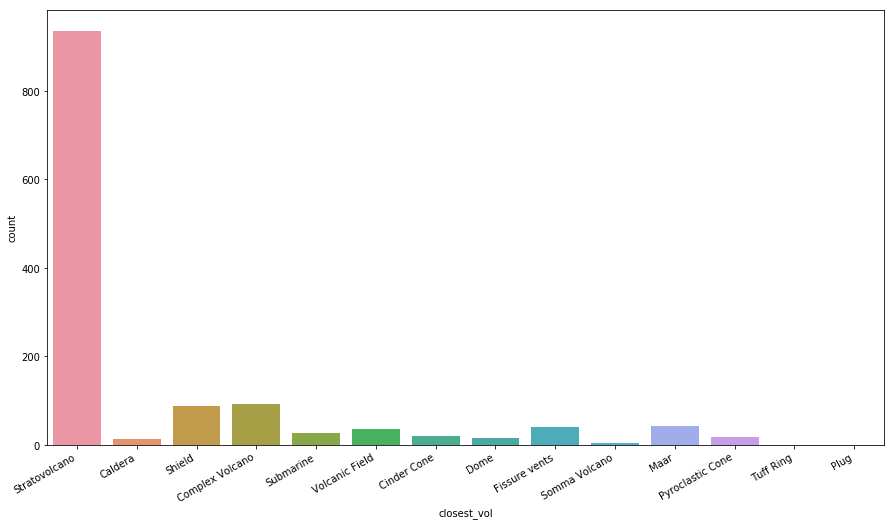

In [42]:
# At this point, we are wanting to visualize the distances between volcanoes and earthquakes. Notice here 
# how strato is way higher than the rest. This, we found, is a normalization issue. 
plt.subplots(figsize=(15, 8))
closest_vol_plot = sns.countplot(quake_vol_dist["closest_vol"])
closest_vol_plot.set_xticklabels(labels=vol_types, rotation=30, ha='right')

In [43]:
# The count between the volcano types and the dist df do not always match up. So, you need a way to make up for 
# the missing data.
quakes_closest = dict(quake_vol_dist["closest_vol"].value_counts())
volcanoe_types = dict(volcanoes_gdf['Type'].value_counts())

type_counts = list()
for key, value in volcanoe_types.items():
    key = key.strip()
    compare = {'type': key, 'volcanoes': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 936, 'type': 'Stratovolcano', 'volcanoes': 275},
 {'earthquakes': 92, 'type': 'Caldera', 'volcanoes': 40},
 {'earthquakes': 36, 'type': 'Shield', 'volcanoes': 34},
 {'earthquakes': 41, 'type': 'Complex Volcano', 'volcanoes': 16},
 {'earthquakes': 13, 'type': 'Submarine', 'volcanoes': 11},
 {'earthquakes': 27, 'type': 'Volcanic Field', 'volcanoes': 11},
 {'earthquakes': 0, 'type': '', 'volcanoes': 10},
 {'earthquakes': 19, 'type': 'Cinder Cone', 'volcanoes': 9},
 {'earthquakes': 89, 'type': 'Dome', 'volcanoes': 8},
 {'earthquakes': 5, 'type': 'Fissure vents', 'volcanoes': 4},
 {'earthquakes': 21, 'type': 'Somma Volcano', 'volcanoes': 3},
 {'earthquakes': 44, 'type': 'Pyroclastic Cone', 'volcanoes': 3},
 {'earthquakes': 1, 'type': 'Maar', 'volcanoes': 3},
 {'earthquakes': 0, 'type': 'Flood Basalt', 'volcanoes': 2},
 {'earthquakes': 0, 'type': 'Tuff Ring', 'volcanoes': 1},
 {'earthquakes': 1, 'type': 'Plug', 'volcanoes': 1}]

In [44]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = [vol_type['type'] for vol_type in type_counts]

dist_count = np.array([vol_type['earthquakes'] for vol_type in type_counts])
vol_count = np.array([vol_type['volcanoes'] for vol_type in type_counts])

normalized_dist = np.divide(dist_count, vol_count)

Text(0,0.5,'normalized distance')

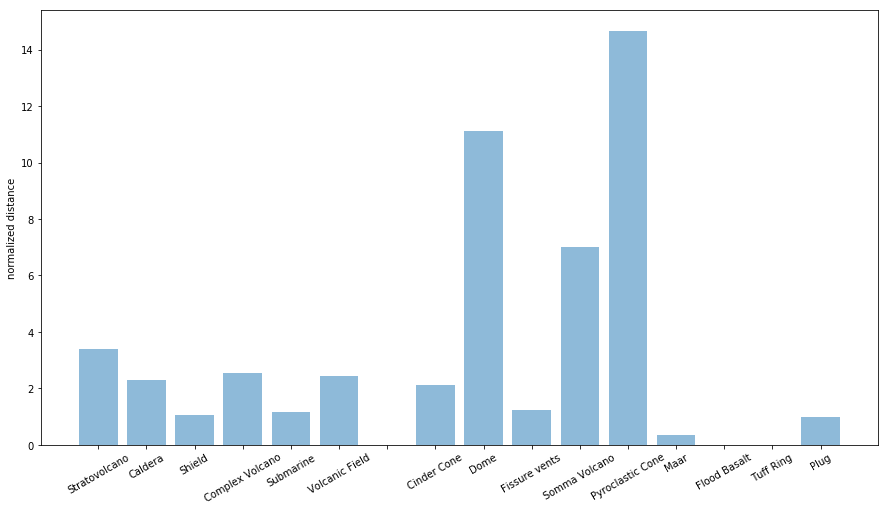

In [45]:
# Plotting out the normalized distances
# Notice the difference in the graph. Pyroclastic very obviously stands out
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,''),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Maar'),
 Text(0,0,'Flood Basalt')]

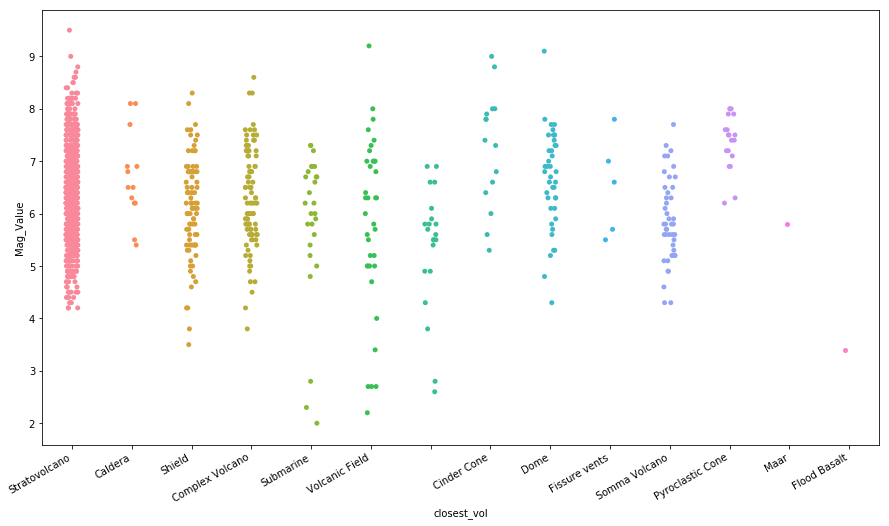

In [46]:
# Strip plot showing correlations between Magnitude and the Closest Volcano
plt.figure(figsize=(15,8))

sp = sns.stripplot(x="closest_vol", y="Mag_Value", data=quake_vol_dist, jitter=True)
sp.set_xticklabels(labels=type_list, rotation=30, ha="right")

In [47]:
# Get geometry column as series per type of plate
plate_types = ["SUB", "CCB", "CRB", "CTF", "OCB", "OSR", "OTF"]

plates_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=boundaries_gdf,
    categories=plate_types,
    extra_column_name='plates'
)

In [48]:
plates_series_geometry_list = plates_to_earthquake_logic.get_geometries_from_gdf(column='STEPCLASS')

quake_plate_dist = plates_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=plates_series_geometry_list
)

quake_plate_dist = plates_to_earthquake_logic.calculate_nearest(
    to_column='closest_plate',
    dist_df=quake_plate_dist
)

boundary_distances_gdf = create_gdf(df=quake_plate_dist)

POINT (141.1000061035156 38.70000076293945)
2.87796912655
POINT (43.09999847412109 40.29999923706055)
10.2164176862
POINT (-66 11)
5.51961484164
POINT (100.0999984741211 26)
14.6776777621
POINT (28.70000076293945 43.40000152587891)
8.00104201674
POINT (142.5 40.5)
1.83482369725
POINT (173 -43)
2.67404001466
POINT (141.3000030517578 40.5)
3.00886722376
POINT (48.59999847412109 40.70000076293945)
15.2904280841
POINT (33.59999847412109 40.70000076293945)
5.9830792049
POINT (-91 14)
1.15906900969
POINT (129.6000061035156 43.20000076293945)
12.1209832785
POINT (77 40)
30.2976211772
POINT (138 -35)
29.0769332117
POINT (72.30000305175781 40.79999923706055)
33.5316400884
POINT (35.29999923706055 32.20000076293945)
2.61377725821
POINT (42.65000152587891 39.13999938964844)
9.24059221888
POINT (42.70000076293945 40.90000152587891)
10.2290398461
POINT (22.96999931335449 36.36000061035156)
0.83852832951
POINT (58.20000076293945 35.20000076293945)
23.7036339365
POINT (120.5 23.5)
1.86861660059
POINT

4.25206531647
POINT (-85.69999694824219 13.19999980926514)
2.74435237384
POINT (46 39.20000076293945)
12.3183696866
POINT (1.5 54.08000183105469)
17.7364139624
POINT (89.96499633789062 46.57099914550781)
32.9232335024
POINT (67.1719970703125 29.47299957275391)
29.4639697327
POINT (139.3809967041016 36.02099990844727)
1.21408943611
POINT (161.0160064697266 -10.93200016021729)
0.0831590896778
POINT (131.9450073242188 32.00299835205078)
1.45071626282
POINT (-75.84999847412109 19.77000045776367)
6.96258624074
POINT (-71.9739990234375 8.14900016784668)
4.61003162537
POINT (115 31.39999961853027)
11.1865151208
POINT (126.1689987182617 0.257999986410141)
0.181158072069
POINT (-87.89399719238281 12.36400032043457)
0.790896209336
POINT (-104.1460037231445 19.45700073242188)
1.21211298048
POINT (-103.6320037841797 19.45199966430664)
1.42796074424
POINT (-104.3789978027344 19.02799987792969)
0.731513734834
POINT (23.73200035095215 40.33300018310547)
4.26315239407
POINT (96.69000244140625 39.77099

9.05932030115
POINT (70 23)
23.9417595218
POINT (140.3099975585938 35.64199829101562)
1.74532230078
POINT (54.40499877929688 27.28300094604492)
21.2717880351
POINT (8.899999618530273 36.20000076293945)
2.88876294147
POINT (121.5169982910156 23.91699981689453)
2.52100089708
POINT (22.60700035095215 39.26699829101562)
2.7313855569
POINT (28.60899925231934 36.38700103759766)
1.08590423118
POINT (31.04199981689453 40.67200088500977)
5.40636243732
POINT (52.70100021362305 36.09000015258789)
18.247724082
POINT (-99.2969970703125 16.88100051879883)
0.738915890617
POINT (99.20600128173828 45.15299987792969)
31.6958971603
POINT (47.71200180053711 34.27799987792969)
13.2217260863
POINT (-72.50299835205078 -16.77899932861328)
1.31442503732
POINT (-79.48000335693359 1.054000020027161)
0.929205145238
POINT (103.9120025634766 31.57699966430664)
19.2995993099
POINT (124.3509979248047 24.4330005645752)
1.59574940555
POINT (-79.57499694824219 0.7059999704360962)
1.03997059291
POINT (-136.6649932861328 

4.18801242945
POINT (103.6719970703125 28.87899971008301)
18.2780607045
POINT (-91.13700103759766 15.79699993133545)
2.690380964
POINT (-73.39900207519531 -14.18299961090088)
2.84921320371
POINT (167.3200073242188 -15.57800006866455)
1.05466566616
POINT (122.3249969482422 22.54899978637695)
2.08542709687
POINT (-76.77999877929688 -6.809999942779541)
4.64721891921
POINT (52.78900146484375 28.40800094604492)
19.3688846224
POINT (121.5339965820312 23.60400009155273)
2.24933344896
POINT (69.68399810791016 36.25500106811523)
31.7662586537
POINT (73.32099914550781 35.94900131225586)
29.0826555767
POINT (-86.12799835205078 12.34700012207031)
1.82881428859
POINT (-102.9599990844727 18.45499992370605)
0.856401227743
POINT (100.5449981689453 31.35300064086914)
19.5693271362
POINT (122.8040008544922 13.41499996185303)
2.43304065405
POINT (-84.86000061035156 10.67300033569336)
1.62923066954
POINT (-78.11399841308594 4.907000064849854)
0.0513162208122
POINT (101.0780029296875 23.00300025939941)
12.

15.9648688872
POINT (81.10299682617188 29.62299919128418)
19.3208626327
POINT (-88.48999786376953 15.91199970245361)
3.78417060267
POINT (-80.00199890136719 -1.986999988555908)
1.56935326363
POINT (75.69300079345703 32.92200088500977)
25.2398391835
POINT (75.7760009765625 32.89300155639648)
25.1639618478
POINT (139.7400054931641 35.99700164794922)
1.43657226947
POINT (140.0619964599609 35.52500152587891)
1.47228280954
POINT (1.404000043869019 36.14300155639648)
9.32226991137
POINT (1.577000021934509 36.2130012512207)
9.13676055438
POINT (-98.23500061035156 18.17499923706055)
2.36508022351
POINT (-74.54499816894531 -13.34700012207031)
2.6369133324
POINT (88.79499816894531 27.39200019836426)
14.0631744429
POINT (15.3100004196167 40.78799819946289)
2.17396834914
POINT (15.29500007629395 40.76599884033203)
2.14801244833
POINT (50.64300155639648 34.47200012207031)
16.1460356798
POINT (50.63399887084961 34.42699813842773)
16.1379702843
POINT (139.2830047607422 -4.513000011444092)
2.903404223

12.5475292185
POINT (131.7850036621094 32.05099868774414)
1.6002966976
POINT (98.90499877929688 2.404999971389771)
2.77570449603
POINT (10.68000030517578 44.80899810791016)
5.75867918918
POINT (125.3239974975586 8.267000198364258)
1.79348934956
POINT (125.4789962768555 8.02299976348877)
1.70925616693
POINT (48.28499984741211 34.05899810791016)
13.8041044454
POINT (121.3529968261719 17.32399940490723)
2.14528252592
POINT (115.5660018920898 25.00200080871582)
5.93547664145
POINT (-70.00499725341797 -19.09199905395508)
1.64720809289
POINT (-70.90899658203125 -17.89999961853027)
1.5585180406
POINT (-78.03099822998047 -1.008999943733215)
3.19819125633
POINT (-118.1350021362305 34.06100082397461)
9.09614833151
POINT (-77.96099853515625 -8.166000366210938)
2.97757320082
POINT (-118.1370010375977 34.02000045776367)
9.12293015056
POINT (-115.7559967041016 33.25699996948242)
11.4252086049
POINT (124.1490020751953 -8.258999824523926)
4.59412012008
POINT (140.3220062255859 35.42100143432617)
1.692

POINT (139.2469940185547 42.89199829101562)
5.59418709922
POINT (-71.20600128173828 6.380000114440918)
5.96118028742
POINT (31.70100021362305 15.40100002288818)
18.9408109525
POINT (-92.64600372314453 14.75800037384033)
1.08312068653
POINT (-122.0039978027344 42.30500030517578)
3.19947166295
POINT (76.47799682617188 18.05999946594238)
16.1730593707
POINT (137.9259948730469 32.02999877929688)
1.35041363169
POINT (146.1309967041016 -5.843999862670898)
2.90474673861
POINT (146.2799987792969 -5.876999855041504)
2.76162616449
POINT (-86.08399963378906 11.7180004119873)
1.44340411059
POINT (75.50499725341797 39.32600021362305)
30.5001047855
POINT (-118.5630035400391 34.16400146484375)
8.71723466689
POINT (127.7730026245117 1.042999982833862)
1.42408726065
POINT (30.08099937438965 0.5580000281333923)
33.833785623
POINT (104.254997253418 -4.999000072479248)
2.80616129413
POINT (60.53200149536133 30.78800010681152)
26.3370672247
POINT (52.63800048828125 29.14299964904785)
18.9952422905
POINT (-

23.7173277669
POINT (123.5220031738281 -1.139999985694885)
1.87422141939
POINT (38.77700042724609 38.16400146484375)
5.45072321386
POINT (-66.77700042724609 -23.75399971008301)
4.61871881834
POINT (121.0780029296875 24.16699981689453)
2.61114988839
POINT (102.0309982299805 -4.760000228881836)
1.304895
POINT (101.9530029296875 -4.151000022888184)
1.60684903975
POINT (33.00500106811523 40.73699951171875)
6.13688194394
POINT (101.8479995727539 -4.651000022888184)
1.23227149564
POINT (121.1809997558594 23.86800003051758)
2.35183689496
POINT (139.1710052490234 34.22200012207031)
0.72870789931
POINT (-86.06600189208984 11.92800045013428)
1.59621842132
POINT (29.3439998626709 40.85699844360352)
5.43188540312
POINT (70.94300079345703 36.24499893188477)
30.8847283191
POINT (102.2399978637695 25.72599983215332)
15.7395570938
POINT (-80.52200317382812 -1.945999979972839)
1.0567137696
POINT (30.80599975585938 -7.965000152587891)
42.3172785516
POINT (-77.81099700927734 7.091000080108643)
0.71483133

3.06647944475
POINT (56.79399871826172 30.69099998474121)
22.6667866045
POINT (26.77499961853027 -26.88899993896484)
59.3211366528
POINT (130.2089996337891 33.80199813842773)
3.94789988736
POINT (97.09700012207031 2.069000005722046)
1.15113685268
POINT (48.66899871826172 33.65499877929688)
14.2139870352
POINT (146.8459930419922 -6.355000019073486)
2.02798056898
POINT (-69.197998046875 -20.00699996948242)
2.17749132441
POINT (27.43499946594238 -26.4680004119873)
60.1035820855
POINT (125.0299987792969 46.88399887084961)
17.5007467304
POINT (-76.41400146484375 -5.721000194549561)
5.37405194796
POINT (73.58399963378906 34.46500015258789)
27.7888606436
POINT (73.92900085449219 33.97700119018555)
27.1950727565
POINT (26.75300025939941 38.15800094604492)
3.48535997973
POINT (107.7979965209961 23.60400009155273)
12.6888080951
POINT (108.2259979248047 9.972999572753906)
12.8442509085
POINT (115.6630020141602 29.7140007019043)
9.39431940345
POINT (55.83300018310547 26.7859992980957)
22.783347187

POINT (143.6000061035156 42.09999847412109)
5.46687087971
POINT (-115.5 32.79999923706055)
1.69946047178
POINT (-89 14)
4.43927122397
POINT (91.5 29.5)
2.47770289754
POINT (120.5 23.89999961853027)
0.02633810676
POINT (121 24)
0.370747260356
POINT (120.9000015258789 21.89999961853027)
0.464586900973
POINT (116 -7)
4.68127984637
POINT (114 31)
3.60088117834
POINT (125 6)
4.41957882609
POINT (104 29)
6.65677436902
POINT (-74 4)
0.219404869467
POINT (117.2429962158203 23.54000091552734)
1.89567455441
POINT (-117.4400024414062 33.8120002746582)
0.454818732271
POINT (123.5630035400391 5.652999877929688)
5.1179308997
POINT (150.2530059814453 46.8120002746582)
7.61382795886
POINT (-67.63099670410156 18.47299957275391)
2.69715898801
POINT (152.6289978027344 -5.47700023651123)
2.63589960653
POINT (122.0800018310547 23.8129997253418)
1.35650380385
POINT (-97.08000183105469 19.27000045776367)
13.8006483715
POINT (44.09999847412109 42)
4.19499629371
POINT (10.30000019073486 44.29999923706055)
5.61

1.12183852018
POINT (-68.75 -31.25)
11.1689726027
POINT (32.5 41.5)
5.93552895705
POINT (84 44)
14.2491432023
POINT (54.5 36.79999923706055)
7.52371620291
POINT (26.70000076293945 39.40000152587891)
6.54537720186
POINT (136 33.75)
2.90746298343
POINT (136.75 34.75)
1.77593149225
POINT (142.5 41.25)
4.96608034571
POINT (35.79999923706055 37.40000152587891)
0.990002786222
POINT (-70.5 -33.25)
13.7678592744
POINT (119 39.5)
0.767259161163
POINT (63 24.5)
2.03143003818
POINT (5 36)
1.05465793234
POINT (31.79999923706055 38.20000076293945)
5.05403925963
POINT (-163.5 52.75)
18.9050010579
POINT (41.20000076293945 39.29999923706055)
0.483401052267
POINT (-124.5 49.75)
6.61736684792
POINT (-70.5 -26.5)
8.64346278988
POINT (-69 19.25)
1.12302626862
POINT (72.5 41.5)
6.81812327551
POINT (54.5 39.75)
9.6217093076
POINT (-77.5 -8.5)
6.35018054861
POINT (122.5 22.5)
2.09782525616
POINT (134.5 32.5)
4.8532299554
POINT (102 25)
5.27376952473
POINT (59 33)
6.0822878919
POINT (123 24.75)
1.67856903343


5.90489096719
POINT (114.9629974365234 37.38800048828125)
3.27012555034
POINT (122.6949996948242 24.30699920654297)
1.50994576424
POINT (29.87299919128418 0.8420000076293945)
22.8090433492
POINT (114.9909973144531 37.55099868774414)
3.42231855539
POINT (69.12999725341797 41.15999984741211)
7.28331938815
POINT (80.85399627685547 29.55400085449219)
0.649621076771
POINT (68.62899780273438 30.05100059509277)
0.361999876214
POINT (78.89199829101562 28.61599922180176)
0.834513227021
POINT (41.58000183105469 39.1609992980957)
0.620247246352
POINT (100.088996887207 27.45700073242188)
2.62943574604
POINT (-78.68399810791016 -10.80700016021729)
6.82426254983
POINT (21.17600059509277 38.87400054931641)
1.17273991059
POINT (-70.65499877929688 -25.50200080871582)
8.22447842286
POINT (-74.79900360107422 2.888999938964844)
0.0284725744377
POINT (112.9459991455078 -9.168000221252441)
8.25641607858
POINT (116.6009979248047 38.51599884033203)
1.68413342159
POINT (96.23200225830078 5.084000110626221)
9.3

3.55308741539
POINT (59.18000030517578 33.81999969482422)
6.91450529163
POINT (44.03099822998047 39.08200073242188)
1.6236903334
POINT (-68.89600372314453 -20.47200012207031)
4.83626766021
POINT (26.67700004577637 -27.97900009155273)
1.21370598959
POINT (101.0240020751953 27.33600044250488)
3.57180338519
POINT (91.01399993896484 38.18500137329102)
10.9443060692
POINT (26.70199966430664 45.7760009765625)
9.9953655087
POINT (122.2850036621094 16.7549991607666)
5.21009017304
POINT (56.36299896240234 27.58300018310547)
0.223215598129
POINT (40.05699920654297 38.64699935913086)
0.160864300901
POINT (50.64300155639648 31.95400047302246)
1.56492672768
POINT (160.8159942626953 -10.00899982452393)
6.53507510091
POINT (44.32400131225586 38.89599990844727)
1.62604661803
POINT (118.370002746582 -11.18000030517578)
3.42087329643
POINT (118.379997253418 -11.12600040435791)
3.41499977481
POINT (125.3259963989258 -8.13599967956543)
1.14637555665
POINT (-76.15899658203125 7.35099983215332)
1.2952196461

5.53029908761
POINT (136.0930023193359 -4.064000129699707)
2.8382002676
POINT (-102.379997253418 18.42000007629395)
17.733864887
POINT (-101.6230010986328 17.83099937438965)
16.7913627916
POINT (69.80999755859375 40.33700180053711)
6.24469849542
POINT (6.846000194549561 36.38600158691406)
1.78384921363
POINT (15.06799983978271 37.6879997253418)
0.61340473268
POINT (-77.43699645996094 -9.51200008392334)
6.10029985202
POINT (-115.8000030517578 47.47000122070312)
11.2020847118
POINT (-71.75700378417969 -13.40200042724609)
0.898678407072
POINT (76.39700317382812 32.11800003051758)
0.725485753605
POINT (37.78099822998047 37.99900054931641)
0.110375283855
POINT (43.70399856567383 41.40399932861328)
3.49054227199
POINT (121.6429977416992 24.14599990844727)
0.818244306631
POINT (37.90999984741211 38.00699996948242)
0.0653197232928
POINT (-62.9109992980957 10.57299995422363)
6.4019769543
POINT (51.55699920654297 29.9109992980957)
0.600739327059
POINT (-117.8399963378906 33.06600189208984)
1.300

0.0119697106971
POINT (-116.5199966430664 34.18999862670898)
0.203726614512
POINT (73.58799743652344 42.11100006103516)
7.51429817871
POINT (66.81999969482422 29.21100044250488)
0.75658230004
POINT (-87.37999725341797 11.72700023651123)
1.66189189924
POINT (52.14699935913086 29.13199996948242)
1.04931762558
POINT (26.65999984741211 -6.151000022888184)
16.4191637627
POINT (31.14399909973145 29.7140007019043)
4.48695789553
POINT (-76.76399993896484 7.092999935150146)
1.16259803427
POINT (31.53499984741211 29.7549991607666)
4.11016591931
POINT (-4.290999889373779 31.27499961853027)
2.82366361713
POINT (45.09600067138672 42.56100082397461)
5.11569268215
POINT (121.8320007324219 -8.498000144958496)
1.70745276217
POINT (100.7519989013672 26.32799911499023)
3.55708198145
POINT (26.79999923706055 -28.02799987792969)
1.27640721602
POINT (-76.59400177001953 18.05200004577637)
6.27754808384
POINT (144.1940002441406 43.02199935913086)
5.30972344608
POINT (144.1410064697266 43.02399826049805)
5.277

3.98506771064
POINT (54.64799880981445 36.15700149536133)
7.21594347312
POINT (30.00300025939941 40.77299880981445)
7.57984052901
POINT (29.91200065612793 40.76699829101562)
7.65878740136
POINT (23.59799957275391 38.11899948120117)
3.3106724785
POINT (30.0890007019043 40.73600006103516)
7.48636333613
POINT (120.8769989013672 23.81900024414062)
0.359160233185
POINT (121.0869979858398 23.8129997253418)
0.545021937362
POINT (29.35000038146973 40.73600006103516)
8.1544980674
POINT (-96.90499877929688 16.05500030517578)
11.7931517208
POINT (120.443000793457 23.5310001373291)
0.00386414501951
POINT (30.72400093078613 40.69499969482422)
6.90409673276
POINT (30.24699974060059 40.7400016784668)
7.34709654308
POINT (31.2189998626709 40.80300140380859)
6.52917124068
POINT (102.8450012207031 24.58600044250488)
6.21203206386
POINT (168.2389984130859 -16.31599998474121)
2.78646175309
POINT (42.35400009155273 40.48199844360352)
2.10482022035
POINT (119.7760009765625 15.7790002822876)
4.92301582259
PO

3.10634393444
POINT (97.09700012207031 2.069000005722046)
12.3416103441
POINT (48.66899871826172 33.65499877929688)
1.42312754801
POINT (146.8459930419922 -6.355000019073486)
0.286652009387
POINT (-69.197998046875 -20.00699996948242)
4.72458297007
POINT (27.43499946594238 -26.4680004119873)
0.069618668704
POINT (125.0299987792969 46.88399887084961)
5.22811665752
POINT (-76.41400146484375 -5.721000194549561)
4.44399348604
POINT (73.58399963378906 34.46500015258789)
0.585250341629
POINT (73.92900085449219 33.97700119018555)
0.446536900882
POINT (26.75300025939941 38.15800094604492)
6.46270291887
POINT (107.7979965209961 23.60400009155273)
5.82576601499
POINT (108.2259979248047 9.972999572753906)
7.80830498234
POINT (115.6630020141602 29.7140007019043)
3.49542400875
POINT (55.83300018310547 26.7859992980957)
0.223897245548
POINT (29.78899955749512 -6.245999813079834)
15.7459790143
POINT (71.12000274658203 36.28499984741211)
2.08866516116
POINT (79.20099639892578 30.45999908447266)
0.83259

5.98542968785
POINT (152.6289978027344 -5.47700023651123)
1.87795864506
POINT (122.0800018310547 23.8129997253418)
0.997473382776
POINT (-97.08000183105469 19.27000045776367)
8.53992706459
POINT (44.09999847412109 42)
9.27635880628
POINT (10.30000019073486 44.29999923706055)
8.03224195393
POINT (105.3170013427734 36.60100173950195)
7.00423487766
POINT (-68.40000152587891 -32.70000076293945)
11.199489762
POINT (39.44499969482422 15.60999965667725)
0.249671231954
POINT (127.2570037841797 7.896999835968018)
5.66722303463
POINT (139.8000030517578 35.20000076293945)
8.5007800808
POINT (122.0400009155273 24.50600051879883)
0.331974397393
POINT (122 24.5)
0.324077454196
POINT (-70.75499725341797 -28.55299949645996)
7.08696317828
POINT (130.1000061035156 32.70000076293945)
0.675143276639
POINT (130.1000061035156 32.70000076293945)
0.675143276639
POINT (160.7610015869141 53.85300064086914)
15.9630061863
POINT (101.2580032348633 30.55299949645996)
4.49152714197
POINT (162.5850067138672 55.415000

4.1748376598
POINT (132 32)
0.366427727438
POINT (120.390998840332 23.25099945068359)
1.86425865376
POINT (99.14499664306641 21.07600021362305)
4.62577055153
POINT (100.3000030517578 23.10000038146973)
6.05095279338
POINT (-79.90200042724609 0.01200000010430813)
7.39875930442
POINT (-90.91300201416016 13.77999973297119)
0.311268535712
POINT (-74.91999816894531 -14.97500038146973)
0.299808093417
POINT (20.39999961853027 41.70000076293945)
3.22921274544
POINT (36.45000076293945 40.67100143432617)
3.94103391015
POINT (30.5 40.79999923706055)
0.135458060441
POINT (-101.5 17.75)
11.5434325917
POINT (-72 -30.75)
9.4508382697
POINT (30.5 40.59999847412109)
0.0599225993314
POINT (110 -9.5)
13.1306311755
POINT (134 35.25)
4.16955753048
POINT (34 41)
3.25058102499
POINT (121.5 22.89999961853027)
1.79257004505
POINT (-68.75 -31.25)
9.74936200983
POINT (32.5 41.5)
1.94609275216
POINT (84 44)
18.5397662607
POINT (54.5 36.79999923706055)
15.1654580032
POINT (26.70000076293945 39.40000152587891)
0.13

9.28258340326
POINT (80.85399627685547 29.55400085449219)
10.6950193369
POINT (68.62899780273438 30.05100059509277)
1.88829871103
POINT (78.89199829101562 28.61599922180176)
8.95868462494
POINT (41.58000183105469 39.1609992980957)
5.66239987244
POINT (100.088996887207 27.45700073242188)
4.87122978272
POINT (-78.68399810791016 -10.80700016021729)
5.24101606362
POINT (21.17600059509277 38.87400054931641)
0.437517310917
POINT (-70.65499877929688 -25.50200080871582)
4.04569623492
POINT (-74.79900360107422 2.888999938964844)
7.4265185751
POINT (112.9459991455078 -9.168000221252441)
10.7136001945
POINT (116.6009979248047 38.51599884033203)
1.7660099496
POINT (96.23200225830078 5.084000110626221)
0.553013186366
POINT (21.29100036621094 39.55199813842773)
1.11921002398
POINT (30.73999977111816 40.63199996948242)
0.0229173731392
POINT (40.40800094604492 39.50199890136719)
4.81906104628
POINT (-73.072998046875 6.788000106811523)
6.02882399398
POINT (-67.30999755859375 10.55500030517578)
0.653321

9.6282946524
POINT (118.379997253418 -11.12600040435791)
9.57440850311
POINT (125.3259963989258 -8.13599967956543)
4.60329861817
POINT (-76.15899658203125 7.35099983215332)
4.52845569423
POINT (-67.77999877929688 -31.08200073242188)
9.58185345453
POINT (56.57799911499023 27.6870002746582)
10.6987503189
POINT (56.41299819946289 30.9109992980957)
11.0765612311
POINT (139.2940063476562 34.80300140380859)
7.86923377086
POINT (-91.39900207519531 14.26799964904785)
0.991818229008
POINT (15.98999977111816 38.04600143432617)
0.425695171149
POINT (66.23400115966797 29.92799949645996)
1.68761882608
POINT (-99.78199768066406 16.93199920654297)
9.6443859715
POINT (15.07299995422363 38.38100051879883)
0.546313619104
POINT (142.1049957275391 38.23500061035156)
12.0598219087
POINT (142.0090026855469 38.2239990234375)
11.9752548076
POINT (23.25699996948242 40.73199844360352)
1.10345752599
POINT (23.30299949645996 40.7599983215332)
1.09433216046
POINT (23.11199951171875 40.71799850463867)
1.19670316978

2.1239607361
POINT (-69.42400360107422 10.74300003051758)
1.03601505195
POINT (100.7539978027344 29.28000068664551)
4.41644294989
POINT (26.27099990844727 45.52099990844727)
4.83343028437
POINT (22.17600059509277 37.07199859619141)
1.26751147338
POINT (-89.16500091552734 13.79100036621094)
1.05813108906
POINT (121.7269973754883 23.97400093078613)
0.732933057932
POINT (26.00300025939941 43.27799987792969)
2.78659805897
POINT (19.23500061035156 50.30400085449219)
11.4277424249
POINT (10.1540002822876 43.51499938964844)
7.56913941846
POINT (1.38699996471405 35.91899871826172)
7.53695048177
POINT (147.6649932861328 -6.025000095367432)
2.41663615412
POINT (176.9210052490234 -38.01499938964844)
0.415840734982
POINT (-70.09999847412109 -24.39500045776367)
2.89524982247
POINT (-77.66600036621094 0.03999999910593033)
7.95456131596
POINT (-77.78700256347656 0.0820000022649765)
7.86906408676
POINT (20.20599937438965 51.36899948120117)
12.0637892003
POINT (131.7850036621094 32.05099868774414)
0.29

15.1033489436
POINT (26.65999984741211 -6.151000022888184)
2.94045998095
POINT (31.14399909973145 29.7140007019043)
3.61054264241
POINT (-76.76399993896484 7.092999935150146)
3.93619276975
POINT (31.53499984741211 29.7549991607666)
3.3024508614
POINT (-4.290999889373779 31.27499961853027)
3.44221261078
POINT (45.09600067138672 42.56100082397461)
10.4152523828
POINT (121.8320007324219 -8.498000144958496)
6.16042094419
POINT (100.7519989013672 26.32799911499023)
4.46251066506
POINT (26.79999923706055 -28.02799987792969)
0.250953024245
POINT (-76.59400177001953 18.05200004577637)
7.59676315573
POINT (144.1940002441406 43.02199935913086)
11.1567203509
POINT (144.1410064697266 43.02399826049805)
11.1463898065
POINT (101.4150009155273 25.82600021362305)
3.98063839691
POINT (86.14399719238281 42.20000076293945)
19.1918497732
POINT (-178.1620025634766 -14.40900039672852)
1.54516289709
POINT (87.35600280761719 29.00900077819824)
17.2142297504
POINT (21.52599906921387 37.61299896240234)
0.809248

3.19197995601
POINT (26.67900085449219 -27.95299911499023)
0.24896095969
POINT (51.90700149536133 29.51899909973145)
15.3621534115
POINT (47.48300170898438 40.76699829101562)
11.7333576549
POINT (-97.44499969482422 18.38100051879883)
8.29957436302
POINT (-88.28500366210938 15.79100036621094)
0.176286964843
POINT (91.93299865722656 21.65800094604492)
8.79439711808
POINT (54.64799880981445 36.15700149536133)
14.6995092658
POINT (30.00300025939941 40.77299880981445)
0.00640203283599
POINT (29.91200065612793 40.76699829101562)
0.0950046249243
POINT (23.59799957275391 38.11899948120117)
0.884163114732
POINT (30.0890007019043 40.73600006103516)
0.0141073082212
POINT (120.8769989013672 23.81900024414062)
1.11695528465
POINT (121.0869979858398 23.8129997253418)
1.00450507621
POINT (29.35000038146973 40.73600006103516)
0.657778454225
POINT (-96.90499877929688 16.05500030517578)
6.65055882944
POINT (120.443000793457 23.5310001373291)
1.62080902176
POINT (30.72400093078613 40.69499969482422)
0.08

0.682748767026
POINT (119.9100036621094 -1.195999979972839)
0.202392196334
POINT (43.69100189208984 37.60300064086914)
7.27755332922
POINT (107.8160018920898 -7.004000186920166)
13.5487369395
POINT (123.3379974365234 5.321000099182129)
5.62876850815
POINT (56.79399871826172 30.69099998474121)
10.6585583788
POINT (26.77499961853027 -26.88899993896484)
1.31055904879
POINT (130.2089996337891 33.80199813842773)
1.78151202247
POINT (97.09700012207031 2.069000005722046)
0.323546603299
POINT (48.66899871826172 33.65499877929688)
12.4826653549
POINT (146.8459930419922 -6.355000019073486)
2.1705539506
POINT (-69.197998046875 -20.00699996948242)
1.49321307338
POINT (27.43499946594238 -26.4680004119873)
0.552794484226
POINT (125.0299987792969 46.88399887084961)
5.22811665752
POINT (-76.41400146484375 -5.721000194549561)
7.4582056533
POINT (73.58399963378906 34.46500015258789)
4.44711885509
POINT (73.92900085449219 33.97700119018555)
4.48957422556
POINT (26.75300025939941 38.15800094604492)
0.8089

0.167215981987
POINT (137 -2)
0.395502937983
POINT (102.5 -4.5)
10.9001479348
POINT (91.5 43.5)
16.8887431445
POINT (32.5 37.5)
3.31740222995
POINT (13.5 42)
4.75694870689
POINT (143.6000061035156 42.09999847412109)
8.32306335859
POINT (-115.5 32.79999923706055)
0.00246556915824
POINT (-89 14)
2.58799729521
POINT (91.5 29.5)
6.23532677572
POINT (120.5 23.89999961853027)
1.3090859727
POINT (121 24)
0.813767447358
POINT (120.9000015258789 21.89999961853027)
1.33404992181
POINT (116 -7)
4.41151096564
POINT (114 31)
3.65675881075
POINT (125 6)
4.87150295084
POINT (104 29)
6.65474995774
POINT (-74 4)
0.44123463146
POINT (117.2429962158203 23.54000091552734)
1.89567455441
POINT (-117.4400024414062 33.8120002746582)
0.813205805597
POINT (123.5630035400391 5.652999877929688)
4.29909108402
POINT (150.2530059814453 46.8120002746582)
10.663027472
POINT (-67.63099670410156 18.47299957275391)
2.16296042609
POINT (152.6289978027344 -5.47700023651123)
0.727172397467
POINT (122.0800018310547 23.812999

4.56450366117
POINT (102.5 24.39999961853027)
5.26629815713
POINT (139.8289947509766 44.50799942016602)
9.51262549162
POINT (26.65500068664551 45.77299880981445)
5.02010401395
POINT (43.5 16.39999961853027)
3.32938431647
POINT (58.59999847412109 33.5)
7.13846510762
POINT (-102.9570007324219 18.67700004577637)
13.3022248296
POINT (127.1999969482422 47)
9.37993168749
POINT (99.40799713134766 23.51399993896484)
3.41829543818
POINT (92.47799682617188 12.14900016784668)
2.23534013011
POINT (43.29999923706055 39.5)
2.33704888524
POINT (102.3000030517578 31.70000076293945)
6.26923285374
POINT (39.40000152587891 39.70000076293945)
0.157257451062
POINT (132 32)
2.56636182172
POINT (120.390998840332 23.25099945068359)
1.24974002428
POINT (99.14499664306641 21.07600021362305)
3.2832197727
POINT (100.3000030517578 23.10000038146973)
4.37009033888
POINT (-79.90200042724609 0.01200000010430813)
2.51679982251
POINT (-90.91300201416016 13.77999973297119)
4.03509047854
POINT (-74.91999816894531 -14.975

0.157761724421
POINT (35.11199951171875 -3.930000066757202)
9.01628567337
POINT (38.47499847412109 38.08000183105469)
1.01647395534
POINT (139.2259979248047 38.43399810791016)
3.42000746948
POINT (-100.5100021362305 18.19400024414062)
12.9337803283
POINT (28.20800018310547 40.25)
0.382561568777
POINT (125.9649963378906 -2.454999923706055)
1.64289167709
POINT (-70.70999908447266 -25.66699981689453)
3.93309248687
POINT (23.82500076293945 39.22900009155273)
0.324996698709
POINT (-71.21199798583984 -32.49200057983398)
10.7709988091
POINT (22.29899978637695 38.3390007019043)
0.433368524839
POINT (138.2779998779297 34.84199905395508)
0.971349864281
POINT (-122.3349990844727 47.31700134277344)
7.30853060645
POINT (22.42600059509277 38.39099884033203)
0.324037595713
POINT (-95.84600067138672 16.17799949645996)
8.12332868847
POINT (87.75499725341797 43.84000015258789)
16.7830908416
POINT (21.75699996948242 39.04399871826172)
1.23752191869
POINT (103.1709976196289 26.15999984741211)
5.2584918603

11.2647337016
POINT (98.93000030517578 24.50099945068359)
2.61339609531
POINT (98.61000061035156 24.58099937438965)
2.29198621519
POINT (140.1089935302734 -4.531000137329102)
0.329437867734
POINT (40.4630012512207 38.32699966430664)
0.533368584391
POINT (114.7740020751953 -8.227999687194824)
5.78314858313
POINT (98.66699981689453 24.76799964904785)
2.25821859214
POINT (117.8880004882812 39.60499954223633)
0.345173089966
POINT (118.359001159668 39.72299957275391)
0.730919130124
POINT (104.0879974365234 32.75299835205078)
8.32449634677
POINT (124.088996887207 6.291999816894531)
4.96897924555
POINT (122.9599990844727 7.258999824523926)
5.93292920744
POINT (29.01499938964844 37.74300003051758)
0.737132348692
POINT (104.181999206543 32.48099899291992)
8.23870995512
POINT (13.18099975585938 46.3390007019043)
8.98814543179
POINT (13.20600032806396 46.31399917602539)
8.95788084659
POINT (13.08699989318848 46.35400009155273)
9.02575049967
POINT (-78.73200225830078 -0.7260000109672546)
1.9062364

4.37220146169
POINT (13.90100002288818 41.75500106811523)
4.38427391685
POINT (17.82900047302246 42.9739990234375)
5.20371614693
POINT (121.6019973754883 32.60400009155273)
1.04563742053
POINT (-80.80000305175781 46.58000183105469)
27.1018354735
POINT (-69.37100219726562 17.98100090026855)
1.71556338231
POINT (-69.23300170898438 18.03899955749512)
1.66696545987
POINT (137.4660034179688 35.80099868774414)
1.93524645681
POINT (-115.9869995117188 47.45999908447266)
11.0524312774
POINT (42.24100112915039 40.89199829101562)
2.19566404692
POINT (42.44699859619141 40.71099853515625)
2.17969451113
POINT (92.86399841308594 24.68400001525879)
3.22725929505
POINT (-68.59300231933594 -33.10900115966797)
11.5654114362
POINT (52.97200012207031 28.35199928283691)
2.10120858428
POINT (-71.76200103759766 -33.13199996948242)
11.448958317
POINT (14.26299953460693 41.63100051879883)
4.15894483892
POINT (-71.68000030517578 -32.71200180053711)
11.0231816252
POINT (123.5120010375977 7.776000022888184)
6.4220

0.0625420073773
POINT (70.40299987792969 35.94400024414062)
4.94012868008
POINT (6.760000228881836 44.8849983215332)
11.2489078432
POINT (113.9889984130859 39.94699859619141)
1.27973847465
POINT (-77.08100128173828 -5.97700023651123)
4.25700322581
POINT (68.26899719238281 37.4640007019043)
6.75735933886
POINT (-83.07199859619141 9.673000335693359)
4.08928326603
POINT (41.16899871826172 39.61299896240234)
0.546159715601
POINT (43.66699981689453 42.42599868774414)
4.27823120484
POINT (43.24499893188477 42.68000030517578)
4.24211426102
POINT (-82.44000244140625 9.546999931335449)
3.52514075438
POINT (116.6520004272461 5.857999801635742)
5.76239019332
POINT (44.01100158691406 42.40599822998047)
4.48579689454
POINT (120.3160018920898 15.16499996185303)
1.0059392329
POINT (-89.63300323486328 13.40799999237061)
3.42501991243
POINT (-118.0110015869141 34.23699951171875)
1.36500186718
POINT (124.5869979858398 -8.145999908447266)
2.04377624962
POINT (20.98100090026855 45.39300155639648)
6.253165

1.15403995457
POINT (-28.56599998474121 38.62099838256836)
19.9472517426
POINT (48.52500152587891 38.72600173950195)
4.69169054963
POINT (120.7109985351562 23.50300025939941)
1.30618939621
POINT (142.5200042724609 -2.946000099182129)
1.9383789859
POINT (-71.24400329589844 -32.32699966430664)
10.6078445778
POINT (-80.31300354003906 -0.593999981880188)
2.04761955583
POINT (77.29799652099609 39.57199859619141)
7.55928475311
POINT (15.97500038146973 40)
2.4670602914
POINT (112.3399963378906 -8.177000045776367)
7.93012143041
POINT (20.0939998626709 44.20299911499023)
5.74225242814
POINT (53.64199829101562 27.79100036621094)
2.93797328522
POINT (100.9550018310547 27.26300048828125)
3.51155084401
POINT (124.818000793457 -1.939000010490417)
1.9929647962
POINT (71 36.51800155639648)
5.56171962236
POINT (-75.65899658203125 4.443999767303467)
1.74616336074
POINT (69.16500091552734 34.32300186157227)
3.49244160271
POINT (46.90900039672852 43.26200103759766)
6.80743946604
POINT (57.20700073242188 2

4.85645220632
POINT (80.54599761962891 42.8849983215332)
11.752914443
POINT (-121.0749969482422 35.62900161743164)
0.6405112577
POINT (-82.84200286865234 8.369000434875488)
3.23074530728
POINT (58.26800155639648 28.95000076293945)
2.72253716993
POINT (115.7580032348633 -8.348999977111816)
4.80730429692
POINT (135.5970001220703 -3.66100001335144)
0.548149100119
POINT (73.17800140380859 34.75099945068359)
3.57754708909
POINT (73.16899871826172 34.77199935913086)
3.59887873001
POINT (100.5479965209961 -0.515999972820282)
6.51720285243
POINT (29.44599914550781 -3.359999895095825)
7.66385347969
POINT (-3.984999895095825 35.18399810791016)
2.11713011469
POINT (-4.079999923706055 35.22499847412109)
2.03242120558
POINT (-4.177999973297119 35.24599838256836)
1.94176172746
POINT (38.27700042724609 38.05799865722656)
1.20762006345
POINT (-4.160999774932861 35.17399978637695)
1.9425523648
POINT (40.72100067138672 39.80400085449219)
0.491567761527
POINT (71.04199981689453 36.47999954223633)
5.52985

13.951871129
POINT (19.60000038146973 42.09999847412109)
3.35763191487
POINT (132.5 34.09999847412109)
7.18672490768
POINT (16 39)
1.96735863533
POINT (24 40)
4.51402968533
POINT (-81.5 1)
5.99609781441
POINT (120.4000015258789 23.60000038146973)
2.10143844912
POINT (120.4000015258789 23.60000038146973)
2.10143844912
POINT (-123 38)
21.6085110315
POINT (-72 -33)
26.0280688873
POINT (85 43.5)
27.6473996607
POINT (94.5 2)
0.281380264648
POINT (-76.69999694824219 18.20000076293945)
5.78038872805
POINT (-100 17)
5.53494832858
POINT (123 14)
9.46537642507
POINT (69 38)
14.1854400002
POINT (121.0999984741211 23)
1.54151038774
POINT (15.5 38)
2.72405947072
POINT (26.89999961853027 38.59999847412109)
6.93461293973
POINT (50 33)
11.6001065943
POINT (38 40)
18.1211606692
POINT (122.5 25)
1.35700036846
POINT (-8.800000190734863 38.90000152587891)
2.5383727887
POINT (103 24.39999961853027)
14.498742613
POINT (101 -2)
7.28664922993
POINT (5.400000095367432 43.70000076293945)
6.52592188227
POINT (13

9.26721001729
POINT (-98.28700256347656 17.43099975585938)
7.08612206826
POINT (34.01499938964844 39.43899917602539)
14.0983746002
POINT (119.5250015258789 -0.3659999966621399)
3.98228802954
POINT (142.0449981689453 37.00899887084961)
2.72039790735
POINT (-72.19999694824219 -36.20000076293945)
23.0424801294
POINT (159.2339935302734 -9.295000076293945)
4.7495470916
POINT (139.968994140625 39.8390007019043)
1.33449214104
POINT (-0.1299999952316284 5.179999828338623)
32.3346810546
POINT (102.5 24.39999961853027)
14.1414474987
POINT (39.53300094604492 39.77000045776367)
19.6215486561
POINT (102.3000030517578 23.89999961853027)
13.6477616278
POINT (43.79999923706055 41.70000076293945)
22.2418776353
POINT (-115.6969985961914 33.22200012207031)
13.3677857847
POINT (-77.62899780273438 -11.11900043487549)
18.4392291702
POINT (102.5 24.39999961853027)
14.1414474987
POINT (139.8289947509766 44.50799942016602)
1.26998409811
POINT (26.65500068664551 45.77299880981445)
10.300945527
POINT (43.5 16.39

21.7495986728
POINT (-73.0469970703125 -38.23500061035156)
21.4499650939
POINT (29 -3.599999904632568)
30.8986247401
POINT (-80.60600280761719 -6.72700023651123)
13.7741747537
POINT (131.5480041503906 31.63199996948242)
8.92373893999
POINT (39.85800170898438 10.4399995803833)
17.3188621273
POINT (54.55799865722656 27.86499977111816)
4.73594417471
POINT (136.6999969482422 36.06999969482422)
3.10374424406
POINT (-75.54199981689453 4.586999893188477)
4.98442038046
POINT (-70.46099853515625 18.29100036621094)
1.71903351717
POINT (-99.6510009765625 17.17099952697754)
5.81777342077
POINT (-99.76399993896484 17.00799942016602)
5.75671848394
POINT (-76.62599945068359 5.096000194549561)
4.15725248077
POINT (22.73699951171875 37.87400054931641)
2.73721067691
POINT (49.81000137329102 35.55599975585938)
13.7058828807
POINT (122.0599975585938 24.35600090026855)
0.838363547102
POINT (41.52700042724609 43.16299819946289)
22.1591234816
POINT (-78.21199798583984 -10.69400024414062)
17.9431153904
POINT 

0.767806965315
POINT (78.60500335693359 31.9370002746582)
15.5374724233
POINT (40.76800155639648 38.51499938964844)
20.7768702385
POINT (125.9970016479492 12.53499984741211)
10.1161672469
POINT (-92.81800079345703 16.89999961853027)
12.5676993398
POINT (-155.0339965820312 19.45199966430664)
46.5167195437
POINT (40.5260009765625 38.59500122070312)
20.5374946565
POINT (21.7140007019043 38.5260009765625)
1.82201087076
POINT (-16.57799911499023 66.22599792480469)
28.8015207823
POINT (-89.14499664306641 15.29599952697754)
9.50583658445
POINT (-90.46900177001953 14.8120002746582)
10.3208373282
POINT (-76.89900207519531 19.86400032043457)
5.63209340455
POINT (-91.00599670410156 14.72500038146973)
10.7400562095
POINT (67.75800323486328 36.58700180053711)
12.5065977233
POINT (42.95399856567383 40.93899917602539)
22.2142502798
POINT (43.68899917602539 39.80099868774414)
20.878041
POINT (112.2220001220703 40.22999954223633)
19.5137488019
POINT (-79.56400299072266 0.8500000238418579)
6.32033864576

2.05986314198
POINT (27.25399971008301 40.30899810791016)
7.64102766047
POINT (15.15100002288818 37.50199890136719)
3.2669111614
POINT (49.2130012512207 36.94200134277344)
15.1826273747
POINT (6.697999954223633 49.15000152587891)
11.7876212103
POINT (139.0449981689453 35.50699996948242)
1.18377496463
POINT (120.7850036621094 18.20599937438965)
5.69995916281
POINT (-70.50199890136719 -26.53899955749512)
31.9663829652
POINT (120.8410034179688 1.151000022888184)
4.24067348694
POINT (-113.8000030517578 44.07799911499023)
22.7787059685
POINT (42.17599868774414 40.32699966430664)
22.3027312772
POINT (115.2040023803711 35.22299957275391)
13.6873139938
POINT (5.346000194549561 50.69599914550781)
13.4510853311
POINT (72.92900085449219 39.35100173950195)
16.9262171669
POINT (151.8950042724609 -5.446000099182129)
1.88598553302
POINT (-13.51099967956543 11.86200046539307)
24.0661915025
POINT (70.677001953125 36.40499877929688)
13.2839648717
POINT (118.7259979248047 -2.865999937057495)
4.1057581480

3.17691996421
POINT (121.6449966430664 23.88299942016602)
0.889011512165
POINT (22.34600067138672 40.97700119018555)
3.85403352492
POINT (-84.22899627685547 9.982000350952148)
2.63059882982
POINT (95.88999938964844 23.55900001525879)
9.77536445165
POINT (70.40299987792969 35.94400024414062)
12.7503126759
POINT (6.760000228881836 44.8849983215332)
7.56303640085
POINT (113.9889984130859 39.94699859619141)
18.3922413327
POINT (-77.08100128173828 -5.97700023651123)
13.4875742473
POINT (68.26899719238281 37.4640007019043)
13.47749254
POINT (-83.07199859619141 9.673000335693359)
1.43637083392
POINT (41.16899871826172 39.61299896240234)
21.2375499575
POINT (43.66699981689453 42.42599868774414)
22.891821072
POINT (43.24499893188477 42.68000030517578)
23.3531321302
POINT (-82.44000244140625 9.546999931335449)
0.792722412798
POINT (116.6520004272461 5.857999801635742)
10.4682934795
POINT (44.01100158691406 42.40599822998047)
22.6647149231
POINT (120.3160018920898 15.16499996185303)
8.73006543154

6.48802717783
POINT (119.6579971313477 -3.773000001907349)
3.37607289066
POINT (-71.16699981689453 -30.87800025939941)
27.8618564448
POINT (-71.38700103759766 46.77099990844727)
26.5702276122
POINT (92.71499633789062 22.26000022888184)
7.87848857048
POINT (114.5230026245117 41.13700103759766)
19.227285675
POINT (-70.14700317382812 -23.85000038146973)
32.5886001158
POINT (70.00399780273438 37.08000183105469)
13.6381745345
POINT (71.07399749755859 36.47900009155273)
13.5237382759
POINT (57.58499908447266 30.12599945068359)
5.68836463395
POINT (12.91899967193604 43.2239990234375)
6.46889421691
POINT (60.0629997253418 32.44699859619141)
8.14889454089
POINT (13.65299987792969 46.27099990844727)
8.30508577627
POINT (-65.4010009765625 -17.78300094604492)
29.0051698003
POINT (70.07499694824219 37.18500137329102)
13.7618684182
POINT (35.32500076293945 36.90299987792969)
15.3579189225
POINT (-28.56599998474121 38.62099838256836)
1.76956035146
POINT (48.52500152587891 38.72600173950195)
17.047708

20.6814659133
POINT (13.62800025939941 46.30500030517578)
8.34712232493
POINT (176.4320068359375 -38.01300048828125)
15.7091080888
POINT (69.47899627685547 33.34400177001953)
10.0064401054
POINT (43.93500137329102 39.68999862670898)
20.6300154618
POINT (103.9169998168945 27.31800079345703)
17.2408924465
POINT (39.23199844360352 38.34700012207031)
19.2370082196
POINT (-65.84999847412109 -28.56800079345703)
29.3099487519
POINT (115.3249969482422 -8.784000396728516)
5.30776229869
POINT (138.8009948730469 37.22999954223633)
2.03081857222
POINT (124.7639999389648 -8.166000366210938)
0.507331471502
POINT (-84.16500091552734 9.623000144958496)
2.51737296595
POINT (-61.7239990234375 15.67899990081787)
3.28445449301
POINT (135.4499969482422 -3.615000009536743)
1.95364673197
POINT (135.60400390625 -3.688999891281128)
2.03576681126
POINT (95.97200012207031 3.286999940872192)
1.54451872845
POINT (119.9100036621094 -1.195999979972839)
3.23282410915
POINT (43.69100189208984 37.60300064086914)
19.317

4.99751698346
POINT (123 14)
11.1293667385
POINT (69 38)
24.9856138608
POINT (121.0999984741211 23)
3.68445563167
POINT (15.5 38)
13.389691632
POINT (26.89999961853027 38.59999847412109)
2.92940891791
POINT (50 33)
18.4355103537
POINT (38 40)
9.44926928392
POINT (122.5 25)
1.64948598054
POINT (-8.800000190734863 38.90000152587891)
6.61545866245
POINT (103 24.39999961853027)
13.7117227306
POINT (101 -2)
10.9718538999
POINT (5.400000095367432 43.70000076293945)
21.6014792111
POINT (136.3000030517578 35.40000152587891)
5.76789190189
POINT (68 30)
17.3766833717
POINT (131.1000061035156 32.29999923706055)
1.5666506115
POINT (122 35)
10.1596655457
POINT (24.5 36)
4.30416565666
POINT (123 25)
1.15013216632
POINT (3.400000095367432 36.09999847412109)
18.565858352
POINT (77.5 43.5)
33.8451492093
POINT (73 40)
28.5473137966
POINT (56 32)
17.172182884
POINT (-102.5 17.5)
2.8846134261
POINT (130 28)
3.94343430271
POINT (20.5 38)
8.44948767678
POINT (-20 64)
0.774395247919
POINT (97 21)
8.219108771

3.60481176809
POINT (102.3000030517578 29.39999961853027)
17.8277418059
POINT (43.40999984741211 40.38000106811523)
14.5481014709
POINT (66.17600250244141 28.89399909973145)
15.5438041966
POINT (138 35)
6.69473614118
POINT (-77.59999847412109 1.100000023841858)
5.58343763207
POINT (103.2649993896484 35.63299942016602)
23.4024928425
POINT (103.4970016479492 28.73299980163574)
17.7196588304
POINT (103.6839981079102 28.67499923706055)
17.7532823727
POINT (105.6999969482422 34.20000076293945)
20.58362773
POINT (103 26.60000038146973)
15.6003897207
POINT (94.75900268554688 5.296000003814697)
1.56311432579
POINT (-95.87799835205078 18.52300071716309)
9.39187833735
POINT (115.1529998779297 35.25199890136719)
13.5861373769
POINT (121.5469970703125 14.31799983978271)
11.0621301604
POINT (-98.28700256347656 17.43099975585938)
6.75655416014
POINT (34.01499938964844 39.43899917602539)
5.86930900183
POINT (119.5250015258789 -0.3659999966621399)
12.995643476
POINT (142.0449981689453 37.0089988708496

25.5772276069
POINT (120.9700012207031 21.95199966430664)
4.45214581237
POINT (-110.6360015869141 44.54800033569336)
15.0415650771
POINT (-94.41699981689453 18.15999984741211)
10.6706854457
POINT (19.79999923706055 40.90000152587891)
10.0699885585
POINT (-72.78800201416016 -15.81400012969971)
20.8757963577
POINT (-75.16200256347656 -14.96100044250488)
18.8135320065
POINT (4.099999904632568 36)
19.2700671076
POINT (-9.5 30.5)
8.6236239482
POINT (54.5 28)
13.1300914315
POINT (-73.17299652099609 -37.9630012512207)
8.179719548
POINT (-73.0469970703125 -38.23500061035156)
8.04725292814
POINT (29 -3.599999904632568)
21.4100038772
POINT (-80.60600280761719 -6.72700023651123)
8.94353720486
POINT (131.5480041503906 31.63199996948242)
0.812686896822
POINT (39.85800170898438 10.4399995803833)
4.10531135959
POINT (54.55799865722656 27.86499977111816)
12.9950028868
POINT (136.6999969482422 36.06999969482422)
6.53711503752
POINT (-75.54199981689453 4.586999893188477)
5.92933449146
POINT (-70.4609985

19.1115365728
POINT (122.8040008544922 13.41499996185303)
11.7322359162
POINT (-84.86000061035156 10.67300033569336)
4.72903701182
POINT (-78.11399841308594 4.907000064849854)
3.62440466232
POINT (101.0780029296875 23.00300025939941)
11.5223952322
POINT (-96.60800170898438 18.23299980163574)
8.60664721027
POINT (52.95100021362305 30.53499984741211)
15.7462955496
POINT (-28.32900047302246 38.48600006103516)
0.454508503447
POINT (4.473000049591064 36.20100021362305)
19.6331316299
POINT (-76.30699920654297 -12.35099983215332)
16.0068654015
POINT (27.26300048828125 38.54000091552734)
2.66021042394
POINT (119.2799987792969 31.53300094604492)
8.09121851845
POINT (138.77099609375 34.56999969482422)
7.0660184128
POINT (104.0070037841797 28.19499969482422)
17.4834432542
POINT (-63.42900085449219 10.50899982452393)
10.7725886458
POINT (-77.63099670410156 7.736999988555908)
3.17570004491
POINT (139.9010009765625 36.01599884033203)
8.81887604051
POINT (-81.01899719238281 -5.881999969482422)
8.0092

5.88105913645
POINT (23.29999923706055 38.19699859619141)
5.7879201982
POINT (23.33499908447266 38.18099975585938)
5.74965434595
POINT (20.8129997253418 39.38199996948242)
8.52895194012
POINT (-74.37300109863281 -13.11600017547607)
17.7716868557
POINT (57.68600082397461 29.85799980163574)
14.8313855023
POINT (67.83599853515625 36.19800186157227)
22.8715403244
POINT (-70.38400268554688 -20.27599906921387)
24.8071565603
POINT (-74.46299743652344 -13.1850004196167)
17.7704329088
POINT (57.76699829101562 29.97599983215332)
14.9418148942
POINT (73.59700012207031 35.68500137329102)
25.1693291441
POINT (-73.03299713134766 -33.17800140380859)
12.3669000215
POINT (-72.50099945068359 8.111000061035156)
8.31715739853
POINT (-102.0090026855469 18.11499977111816)
3.40771046792
POINT (67.08000183105469 29.91200065612793)
16.8622901225
POINT (121.7519989013672 23.95100021362305)
2.64442466078
POINT (-77.53800201416016 -12.34099960327148)
15.3335902819
POINT (-76.01000213623047 -12.74300003051758)
16.

12.1928913412
POINT (160.9329986572266 -10.31999969482422)
4.64724576553
POINT (51.58499908447266 29.94400024414062)
15.2650564841
POINT (51.65499877929688 29.88599967956543)
15.2047050758
POINT (86.61799621582031 26.76300048828125)
16.4518349974
POINT (18.48900032043457 49.88600158691406)
17.000460621
POINT (146.2259979248047 -6.061999797821045)
4.34434343893
POINT (-90.50099945068359 13.90799999237061)
9.69260554794
POINT (99.68099975585938 22.90900039672852)
10.8286223911
POINT (99.41100311279297 23.18600082397461)
10.9858409436
POINT (44.11800003051758 40.91899871826172)
15.3996045339
POINT (68.69899749755859 38.46099853515625)
25.2924739231
POINT (139.8600006103516 36.03799819946289)
8.79920118879
POINT (34.47299957275391 -13.68299961090088)
27.2855590532
POINT (152.8419952392578 -4.331999778747559)
1.6827483556
POINT (34.48500061035156 -13.70800018310547)
27.305073965
POINT (99.20200347900391 29.95499992370605)
17.4335079982
POINT (-99.27500152587891 16.77899932861328)
5.62025190

7.00334908811
POINT (-0.08399999886751175 35.4640007019043)
15.1392776528
POINT (27.40500068664551 -26.44700050354004)
19.9833972032
POINT (118.7190017700195 22.55500030517578)
5.98324704873
POINT (147.3529968261719 43.86299896240234)
19.568791546
POINT (127.9800033569336 -1.205999970436096)
4.69701218652
POINT (121.0589981079102 13.54300022125244)
11.9337193108
POINT (143.4299926757812 40.52299880981445)
14.4194458418
POINT (135.0249938964844 34.58000183105469)
4.31715688001
POINT (-72.93599700927734 5.044000148773193)
8.18203802569
POINT (-109.7850036621094 41.48799896240234)
12.3126110844
POINT (-76.58899688720703 4.052000045776367)
5.34113160423
POINT (121.7060012817383 24.23299980163574)
2.58145832274
POINT (32.26900100708008 35.06000137329102)
2.5643980003
POINT (-77.30699920654297 1.281999945640564)
5.79740510281
POINT (-79.50900268554688 -2.132999897003174)
6.20025735029
POINT (21.7180004119873 40.14400100708008)
8.01935981193
POINT (125.0390014648438 -8.461999893188477)
11.304

3.23882243883
POINT (-88.70200347900391 13.07600021362305)
8.50993843824
POINT (70.28700256347656 23.40200042724609)
13.8086292236
POINT (-89.00099945068359 13.60000038146973)
8.48894390903
POINT (-89.10600280761719 13.78699970245361)
8.49032569439
POINT (101.0790023803711 29.45899963378906)
17.4549182588
POINT (-122.5810012817383 47.09000015258789)
5.74315965929
POINT (132.5399932861328 34.10800170898438)
2.86385196995
POINT (99.05100250244141 24.80599975585938)
12.4055903504
POINT (100.9010009765625 27.61899948120117)
15.6600195493
POINT (69.32399749755859 35.10499954223633)
22.5069572743
POINT (6.869999885559082 49.14699935913086)
23.6422872394
POINT (-73.50499725341797 -16.38500022888184)
20.9184923727
POINT (-71.93099975585938 -17.5319995880127)
22.7656212838
POINT (11.23400020599365 46.72299957275391)
20.3850203069
POINT (-69.23400115966797 -19.5580005645752)
26.0122892026
POINT (-72.68000030517578 -14.34799957275391)
19.795828229
POINT (100.5859985351562 26.28899955749512)
14.30

11.9306624014
POINT (107.411003112793 -9.253999710083008)
20.6307835552
POINT (104.1380004882812 27.9950008392334)
17.373676978
POINT (68.8280029296875 37.25500106811523)
24.2342408534
POINT (104.1510009765625 28.01199913024902)
17.3948884052
POINT (-61.75799942016602 10.81400012969971)
9.37784447068
POINT (118.7770004272461 -8.25100040435791)
16.0341031226
POINT (99.85900115966797 0.6259999871253967)
8.1958271599
POINT (120.5469970703125 21.79899978637695)
4.8648396168
POINT (126.2819976806641 1.065000057220459)
6.32049223026
POINT (100.4700012207031 -0.4799999892711639)
9.44342312371
POINT (136.5399932861328 37.34000015258789)
7.43264922532
POINT (157.0599975585938 -8.430000305175781)
0.980010947345
POINT (-72.66999816894531 -45.2400016784668)
5.01812101574
POINT (101.0100021362305 23.02000045776367)
11.5045843805
POINT (138.4600067138672 37.52000045776367)
8.78581623523
POINT (70.48500061035156 38.93600082397461)
26.4547265773
POINT (141.8099975585938 47.11000061035156)
18.502655559

0.360170135541
POINT (122 24.5)
0.329772269596
POINT (-70.75499725341797 -28.55299949645996)
6.61108496373
POINT (130.1000061035156 32.70000076293945)
10.9241936425
POINT (130.1000061035156 32.70000076293945)
10.9241936425
POINT (160.7610015869141 53.85300064086914)
5.06362598906
POINT (101.2580032348633 30.55299949645996)
16.2796267034
POINT (162.5850067138672 55.41500091552734)
3.29157769672
POINT (59.20000076293945 35.20000076293945)
12.287990707
POINT (139.0839996337891 35.40499877929688)
1.98926397681
POINT (90.31999969482422 24.94300079345703)
15.2302715243
POINT (57.70000076293945 37.20000076293945)
14.7648473198
POINT (56.92800140380859 29.1200008392334)
8.74210784341
POINT (-77.5 1)
5.713104235
POINT (139.1999969482422 35.5)
1.93177410503
POINT (-78.59999847412109 -1.600000023841858)
6.32059910615
POINT (125.9540023803711 7.02299976348877)
5.61612630226
POINT (83.90299987792969 36.63199996948242)
22.5017359251
POINT (73.39700317382812 40.56499862670898)
18.2189368152
POINT (41

POINT (26.70000076293945 39.40000152587891)
8.64698180771
POINT (136 33.75)
4.93191048175
POINT (136.75 34.75)
4.12592304824
POINT (142.5 41.25)
6.91583263245
POINT (35.79999923706055 37.40000152587891)
17.8105543999
POINT (-70.5 -33.25)
11.3138178348
POINT (119 39.5)
15.4962210232
POINT (63 24.5)
1.41444447623
POINT (5 36)
13.3420575625
POINT (31.79999923706055 38.20000076293945)
13.7616226444
POINT (-163.5 52.75)
33.1607213733
POINT (41.20000076293945 39.29999923706055)
23.1398685143
POINT (-124.5 49.75)
4.50596515743
POINT (-70.5 -26.5)
4.60624293758
POINT (-69 19.25)
0.360624590784
POINT (72.5 41.5)
18.6777061761
POINT (54.5 39.75)
18.628317369
POINT (-77.5 -8.5)
12.2178238652
POINT (122.5 22.5)
1.14300043745
POINT (134.5 32.5)
6.6853377626
POINT (102 25)
11.8826674615
POINT (59 33)
10.516972378
POINT (123 24.75)
1.16692230079
POINT (22 37)
4.4194886582
POINT (-75 -10.5)
12.034245234
POINT (122 10.5)
4.91154154855
POINT (-70.25 -17.5)
4.25608329336
POINT (100.5 29.5)
15.9940547079


17.2721643214
POINT (80.85399627685547 29.55400085449219)
16.6496772039
POINT (68.62899780273438 30.05100059509277)
6.71600721578
POINT (78.89199829101562 28.61599922180176)
14.4961097548
POINT (41.58000183105469 39.1609992980957)
23.5185125998
POINT (100.088996887207 27.45700073242188)
14.9022981244
POINT (-78.68399810791016 -10.80700016021729)
13.376137765
POINT (21.17600059509277 38.87400054931641)
3.11679700353
POINT (-70.65499877929688 -25.50200080871582)
3.59659287558
POINT (-74.79900360107422 2.888999938964844)
5.88082356786
POINT (112.9459991455078 -9.168000221252441)
11.8511707272
POINT (116.6009979248047 38.51599884033203)
15.1719409904
POINT (96.23200225830078 5.084000110626221)
2.45821716661
POINT (21.29100036621094 39.55199813842773)
3.27483699322
POINT (30.73999977111816 40.63199996948242)
12.7818447063
POINT (40.40800094604492 39.50199890136719)
22.3515049424
POINT (-73.072998046875 6.788000106811523)
5.59997782605
POINT (-67.30999755859375 10.55500030517578)
4.336570150

8.58121419776
POINT (13.08699989318848 46.35400009155273)
8.68078264654
POINT (-78.73200225830078 -0.7260000109672546)
5.6012314435
POINT (139.9909973144531 -4.474999904632568)
5.4978716662
POINT (101.0210037231445 27.55400085449219)
14.26187375
POINT (59.18000030517578 33.81999969482422)
11.10292478
POINT (44.03099822998047 39.08200073242188)
24.8316791816
POINT (-68.89600372314453 -20.47200012207031)
2.18769270817
POINT (26.67700004577637 -27.97900009155273)
5.35854867977
POINT (101.0240020751953 27.33600044250488)
14.1138283444
POINT (91.01399993896484 38.18500137329102)
28.176238257
POINT (26.70199966430664 45.7760009765625)
10.9572718791
POINT (122.2850036621094 16.7549991607666)
1.12474423736
POINT (56.36299896240234 27.58300018310547)
7.97065712385
POINT (40.05699920654297 38.64699935913086)
21.9979288015
POINT (50.64300155639648 31.95400047302246)
15.1470701977
POINT (160.8159942626953 -10.00899982452393)
2.1854033118
POINT (44.32400131225586 38.89599990844727)
24.4908510098
PO

13.2839648717
POINT (118.7259979248047 -2.865999937057495)
6.37689299372
POINT (-116 47.5)
11.3170461252
POINT (70.44599914550781 34.56399917602539)
11.5337687666
POINT (70.83999633789062 36.44699859619141)
13.3919189274
POINT (138.8710021972656 29.37199974060059)
5.53088093262
POINT (10.19400024414062 43.61600112915039)
8.94861320253
POINT (13.88899993896484 41.73799896240234)
4.81327956469
POINT (13.90100002288818 41.75500106811523)
4.81224597629
POINT (17.82900047302246 42.9739990234375)
3.80625399131
POINT (121.6019973754883 32.60400009155273)
8.35087614911
POINT (-80.80000305175781 46.58000183105469)
27.1002889913
POINT (-69.37100219726562 17.98100090026855)
1.67672291018
POINT (-69.23300170898438 18.03899955749512)
1.59383618653
POINT (137.4660034179688 35.80099868774414)
3.63389231983
POINT (-115.9869995117188 47.45999908447266)
11.30175338
POINT (42.24100112915039 40.89199829101562)
24.2524449315
POINT (42.44699859619141 40.71099853515625)
24.4445326513
POINT (92.86399841308594

5.43253295089
POINT (26.83699989318848 -28.09000015258789)
5.1676897758
POINT (27.34900093078613 -26.38999938964844)
6.23977972084
POINT (103.7180023193359 37.09600067138672)
20.6885492793
POINT (70.42900085449219 35.09000015258789)
11.9930011881
POINT (55.45700073242188 28.24200057983398)
9.08234019207
POINT (97.40499877929688 3.938999891281128)
4.07436848341
POINT (15.40200042724609 37.2859992980957)
3.1676489928
POINT (121.6449966430664 23.88299942016602)
0.370601266931
POINT (22.34600067138672 40.97700119018555)
4.71566617183
POINT (-84.22899627685547 9.982000350952148)
2.94563469458
POINT (95.88999938964844 23.55900001525879)
13.5184050513
POINT (70.40299987792969 35.94400024414062)
12.7503126759
POINT (6.760000228881836 44.8849983215332)
12.5738299928
POINT (113.9889984130859 39.94699859619141)
17.5192164399
POINT (-77.08100128173828 -5.97700023651123)
10.6562486068
POINT (68.26899719238281 37.4640007019043)
13.47749254
POINT (-83.07199859619141 9.673000335693359)
2.31539607752
P

10.3830703856
POINT (70.96800231933594 36.46699905395508)
13.4659136225
POINT (80.08300018310547 23.07200050354004)
15.1118870163
POINT (-7.230999946594238 42.83000183105469)
6.76169948471
POINT (-63.53200149536133 10.44999980926514)
4.89990444136
POINT (26.61899948120117 -26.85700035095215)
6.24952297623
POINT (12.7810001373291 43.07799911499023)
6.48802717783
POINT (119.6579971313477 -3.773000001907349)
6.08049235774
POINT (-71.16699981689453 -30.87800025939941)
8.91409971199
POINT (-71.38700103759766 46.77099990844727)
26.4568822464
POINT (92.71499633789062 22.26000022888184)
12.1606577175
POINT (114.5230026245117 41.13700103759766)
18.3752947445
POINT (-70.14700317382812 -23.85000038146973)
2.17014065634
POINT (70.00399780273438 37.08000183105469)
13.6381745345
POINT (71.07399749755859 36.47900009155273)
13.5237382759
POINT (57.58499908447266 30.12599945068359)
9.13255246428
POINT (12.91899967193604 43.2239990234375)
6.46889421691
POINT (60.0629997253418 32.44699859619141)
9.470767

21.7946691685
POINT (77.20400238037109 39.51499938964844)
19.4232516457
POINT (77.35800170898438 39.40200042724609)
19.432687796
POINT (120.6060028076172 -8.33899974822998)
4.60944279204
POINT (70.55000305175781 35.90700149536133)
12.7796000396
POINT (40.45800018310547 38.97000122070312)
22.3960291149
POINT (77.14199829101562 39.30500030517578)
19.2209493185
POINT (3.694000005722046 36.88000106811523)
12.5065056636
POINT (72.76300048828125 42.95399856567383)
20.1183837143
POINT (128.8789978027344 2.348999977111816)
3.89386619416
POINT (3.592000007629395 36.8650016784668)
12.4037384655
POINT (49.4630012512207 33.02399826049805)
16.7394436058
POINT (54.16500091552734 28.31100082397461)
10.112421504
POINT (101.2600021362305 25.95800018310547)
13.0508026146
POINT (92.31700134277344 22.86800003051758)
12.8122226483
POINT (92.16799926757812 22.74300003051758)
12.7092512953
POINT (92.31600189208984 22.83600044250488)
12.7806425795
POINT (119.7180023193359 43.77899932861328)
19.6324797523
POIN

17.4755609653
POINT (90.302001953125 29.75900077819824)
19.9394639083
POINT (67.48400115966797 30.56900024414062)
6.65664432859
POINT (-84.02809906005859 10.39620018005371)
3.24218299507
POINT (13.33399963378906 42.33399963378906)
5.60453147648
POINT (101.0859985351562 25.61899948120117)
12.9857694327
POINT (138.2760009765625 34.77799987792969)
2.60592246101
POINT (107.3280029296875 -7.777999877929688)
17.6008885756
POINT (-171.8699951171875 -15.52999973297119)
1.80479902055
POINT (99.97000122070312 0.7099999785423279)
8.19814751608
POINT (-72.53299713134766 18.45700073242188)
1.86382912129
POINT (-72.71900177001953 -35.84600067138672)
10.1718416757
POINT (40.02999877929688 38.79000091552734)
21.9690606529
POINT (-72.12999725341797 -34.30099868774414)
11.7953353454
POINT (96.62899780273438 33.16500091552734)
21.3201264889
POINT (172.7012023925781 -43.58340072631836)
2.71387829134
POINT (97.99400329589844 24.70999908447266)
15.0722426847
POINT (142.3690032958984 38.32199859619141)
4.078

0.983237319098
POINT (57.69300079345703 37.95700073242188)
10.664888116
POINT (37.90000152587891 40.20000076293945)
0.105136886035
POINT (-67.59799957275391 -34.76800155639648)
5.42055056807
POINT (172.2920074462891 -41.83100128173828)
0.695690661863
POINT (58 37.5)
10.2536129995
POINT (-68.73699951171875 -23.03800010681152)
1.53735558293
POINT (-56.00799942016602 44.53900146484375)
19.6388347157
POINT (96.54299926757812 17.66500091552734)
0.0955648159192
POINT (44.68500137329102 38.15200042724609)
1.23558326304
POINT (103 26.79999923706055)
2.17671635764
POINT (15.36699962615967 41.04999923706055)
2.43902231962
POINT (13.5 43.75)
5.01559139085
POINT (19.5 40.5)
1.89017149547
POINT (139.1029968261719 34.97700119018555)
0.0418816140319
POINT (19.60000038146973 40.29999923706055)
1.75291911898
POINT (96.4219970703125 17.97200012207031)
0.000171250107625
POINT (120.5999984741211 23.20000076293945)
0.233077901241
POINT (-66.30000305175781 -24.70000076293945)
3.19982354052
POINT (133 35.099

4.1927281468
POINT (135.8000030517578 34.40000152587891)
1.68706954201
POINT (-119.0459976196289 34.94900131225586)
0.0619154363727
POINT (91.64800262451172 30.79700088500977)
3.76615094502
POINT (-118.9169998168945 35.33300018310547)
0.466986301935
POINT (35.5 36.5)
0.851776725541
POINT (160.0570068359375 52.75500106811523)
1.06946207629
POINT (-73.40000152587891 18.39999961853027)
1.83971015651
POINT (55.09999847412109 35.40000152587891)
7.04623722775
POINT (27.62100028991699 40.11999893188477)
0.516624576309
POINT (-72.91999816894531 -37.25400161743164)
1.59220107734
POINT (20.76600074768066 38.04600143432617)
0.40903293435
POINT (32.5 35)
0.566144799121
POINT (178.1999969482422 -18.29999923706055)
1.87637849591
POINT (-80.84700012207031 -3.596999883651733)
0.357475720537
POINT (101.2119979858398 38.87599945068359)
7.66517575742
POINT (22.23900032043457 39.1870002746582)
0.835102725489
POINT (123.9000015258789 13)
1.5894139345
POINT (52 27.5)
0.331483993393
POINT (1.600000023841858 

0.245116485002
POINT (-92.66000366210938 15.55099964141846)
1.82979202268
POINT (79.23899841308594 41.42599868774414)
9.49944679453
POINT (118.7990036010742 -3.178999900817871)
0.204998079165
POINT (-10.56799983978271 35.92300033569336)
0.332366101878
POINT (28.46699905395508 38.53499984741211)
0.584177598328
POINT (41.21900177001953 11.93900012969971)
0.088842093346
POINT (33.93600082397461 27.51099967956543)
0.449185752708
POINT (119.4530029296875 38.42100143432617)
1.93433544706
POINT (111.8089981079102 21.61199951171875)
0.287246108599
POINT (137.0930023193359 35.7859992980957)
0.957717610483
POINT (19.33600044250488 -33.18999862670898)
8.81524547789
POINT (-75.19499969482422 -11.83500003814697)
1.89524533541
POINT (-122.7639999389648 38.29999923706055)
0.235776196681
POINT (17.35300064086914 44.80699920654297)
5.66958625268
POINT (17.23399925231934 44.83700180053711)
5.71331659309
POINT (102.4619979858398 24.14699935913086)
3.6509462878
POINT (143.0240020751953 42.52299880981445)


0.425695171149
POINT (66.23400115966797 29.92799949645996)
1.07525596549
POINT (-99.78199768066406 16.93199920654297)
0.617968215224
POINT (15.07299995422363 38.38100051879883)
0.0124610336392
POINT (142.1049957275391 38.23500061035156)
1.79840344783
POINT (142.0090026855469 38.2239990234375)
1.87678372251
POINT (23.25699996948242 40.73199844360352)
1.10345752599
POINT (23.30299949645996 40.7599983215332)
1.09433216046
POINT (23.11199951171875 40.71799850463867)
1.19124714768
POINT (-90.98999786376953 14.75800037384033)
0.968991156203
POINT (57.38199996948242 33.24200057983398)
5.95100833523
POINT (-96.60299682617188 16.01099967956543)
0.650646873986
POINT (49.63399887084961 32.12799835205078)
0.783996159761
POINT (122.0090026855469 23.21699905395508)
0.643236654405
POINT (59.47100067138672 33.90900039672852)
7.09964004221
POINT (-72.55300140380859 -16.53700065612793)
1.47699188695
POINT (-101.2210006713867 17.75799942016602)
0.866867598933
POINT (101.1060028076172 23.16200065612793)
5

0.455715189294
POINT (151.0559997558594 -5.60099983215332)
0.761997265069
POINT (70.85700225830078 36.16500091552734)
2.18304568891
POINT (75.26399993896484 39.44699859619141)
5.52930703428
POINT (75.41500091552734 39.35599899291992)
5.53029908761
POINT (136.0930023193359 -4.064000129699707)
0.117116612564
POINT (-102.379997253418 18.42000007629395)
1.06522965509
POINT (-101.6230010986328 17.83099937438965)
0.786208847367
POINT (69.80999755859375 40.33700180053711)
6.24469849542
POINT (6.846000194549561 36.38600158691406)
0.929487287043
POINT (15.06799983978271 37.6879997253418)
0.285490890117
POINT (-77.43699645996094 -9.51200008392334)
2.75527326393
POINT (-115.8000030517578 47.47000122070312)
9.91856192161
POINT (-71.75700378417969 -13.40200042724609)
0.898678407072
POINT (76.39700317382812 32.11800003051758)
0.713405569238
POINT (37.78099822998047 37.99900054931641)
0.110375283855
POINT (43.70399856567383 41.40399932861328)
3.49054227199
POINT (121.6429977416992 24.14599990844727)


1.0059392329
POINT (-89.63300323486328 13.40799999237061)
0.936133929363
POINT (-118.0110015869141 34.23699951171875)
0.284559295993
POINT (124.5869979858398 -8.145999908447266)
0.441575103636
POINT (20.98100090026855 45.39300155639648)
6.25316540667
POINT (-71.72100067138672 -15.70699977874756)
2.64084419169
POINT (44.06100082397461 36.59799957275391)
0.23566385695
POINT (-90.93199920654297 14.60400009155273)
0.826566042139
POINT (78.77500152587891 30.72500038146973)
0.845378221972
POINT (-77.35600280761719 4.552000045776367)
0.775660558325
POINT (44.06800079345703 13.88700008392334)
1.87865614145
POINT (49.58200073242188 36.82600021362305)
4.7173693476
POINT (27.43000030517578 -26.42000007629395)
0.0238421787244
POINT (50.75799942016602 31.60499954223633)
1.39276333217
POINT (-84.302001953125 10.22799968719482)
0.269589272915
POINT (39.6510009765625 39.72700119018555)
0.0526540159058
POINT (5.843999862670898 51.18099975585938)
13.1663682699
POINT (98.84799957275391 22.4069995880127)


3.43182875014
POINT (71.07399749755859 36.47900009155273)
2.26879731594
POINT (57.58499908447266 30.12599945068359)
2.91285437266
POINT (12.91899967193604 43.2239990234375)
4.37630803163
POINT (60.0629997253418 32.44699859619141)
6.05348195676
POINT (13.65299987792969 46.27099990844727)
7.50764131987
POINT (-65.4010009765625 -17.78300094604492)
0.628837118742
POINT (70.07499694824219 37.18500137329102)
3.45665827433
POINT (35.32500076293945 36.90299987792969)
1.15394439119
POINT (-28.56599998474121 38.62099838256836)
0.419763052599
POINT (48.52500152587891 38.72600173950195)
4.69169054963
POINT (120.7109985351562 23.50300025939941)
0.271062787644
POINT (142.5200042724609 -2.946000099182129)
0.0727775857686
POINT (-71.24400329589844 -32.32699966430664)
1.51018011828
POINT (-80.31300354003906 -0.593999981880188)
0.960159892913
POINT (77.29799652099609 39.57199859619141)
6.86829257887
POINT (15.97500038146973 40)
1.66834569654
POINT (112.3399963378906 -8.177000045776367)
2.4782110299
POIN

0.00585350570755
POINT (49.4630012512207 33.02399826049805)
1.25061944709
POINT (54.16500091552734 28.31100082397461)
1.50122123982
POINT (101.2600021362305 25.95800018310547)
4.08912089118
POINT (92.31700134277344 22.86800003051758)
3.59366822892
POINT (92.16799926757812 22.74300003051758)
3.74435749027
POINT (92.31600189208984 22.83600044250488)
3.59510330313
POINT (119.7180023193359 43.77899932861328)
2.92270241378
POINT (-70.69300079345703 19.76600074768066)
0.244982304805
POINT (143.8780059814453 41.86399841308594)
1.15780623696
POINT (87.81700134277344 50.03099822998047)
16.661584119
POINT (101.2559967041016 25.88199996948242)
4.1156652407
POINT (100.9779968261719 38.38600158691406)
8.15707746708
POINT (100.9940032958984 38.37099838256836)
8.15457866179
POINT (103.8649978637695 34.7130012512207)
5.94587278288
POINT (103.9739990234375 27.46199989318848)
1.04848924386
POINT (125.4160003662109 12.11299991607666)
0.655056127654
POINT (80.54599761962891 42.8849983215332)
11.3955607777

0.484609316217
POINT (99.97000122070312 0.7099999785423279)
2.87977572054
POINT (-72.53299713134766 18.45700073242188)
1.86382912129
POINT (-72.71900177001953 -35.84600067138672)
1.20323369148
POINT (40.02999877929688 38.79000091552734)
0.0649327367064
POINT (-72.12999725341797 -34.30099868774414)
0.93175276802
POINT (96.62899780273438 33.16500091552734)
5.04239717601
POINT (172.7012023925781 -43.58340072631836)
1.10178308757
POINT (97.99400329589844 24.70999908447266)
1.68729062704
POINT (142.3690032958984 38.32199859619141)
1.56325780454
POINT (99.94899749755859 20.70499992370605)
3.9286594992
POINT (140 38.20000076293945)
2.12882744383
POINT (88.06400299072266 27.72299957275391)
0.826300995538
POINT (43.5 38.59999847412109)
0.915127943034


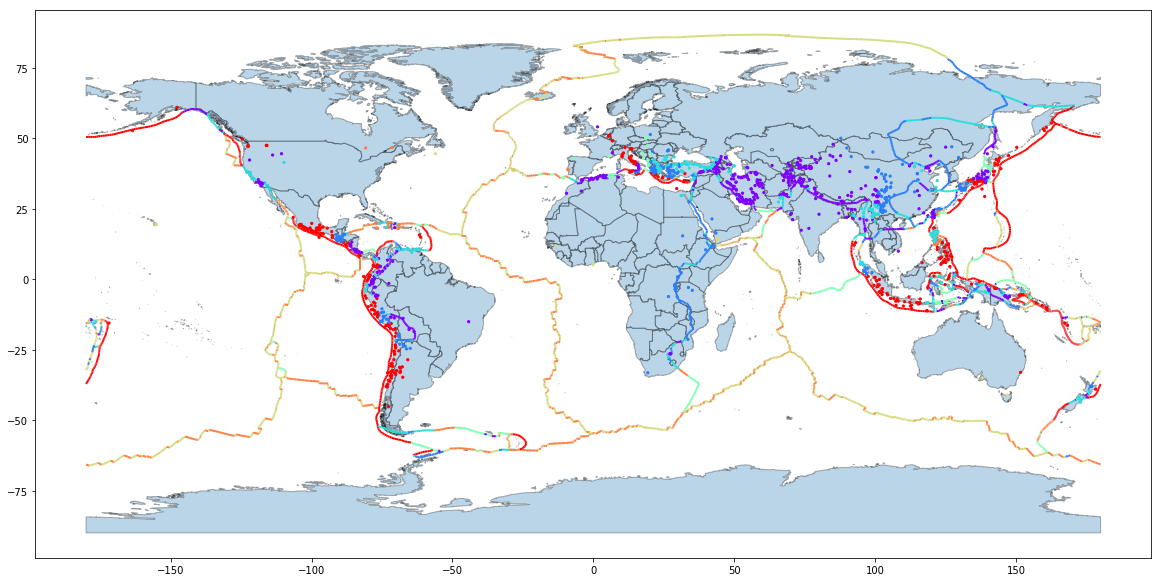

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
boundaries_gdf.plot(ax=ax, column='STEPCLASS', cmap='rainbow', lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
boundary_distances_gdf.plot(ax=ax, column='closest_plate', cmap='rainbow', markersize=5)

[Text(0,0,'OCB'),
 Text(0,0,'CCB'),
 Text(0,0,'CTF'),
 Text(0,0,'SUB'),
 Text(0,0,'CRB'),
 Text(0,0,'OSR'),
 Text(0,0,'OTF')]

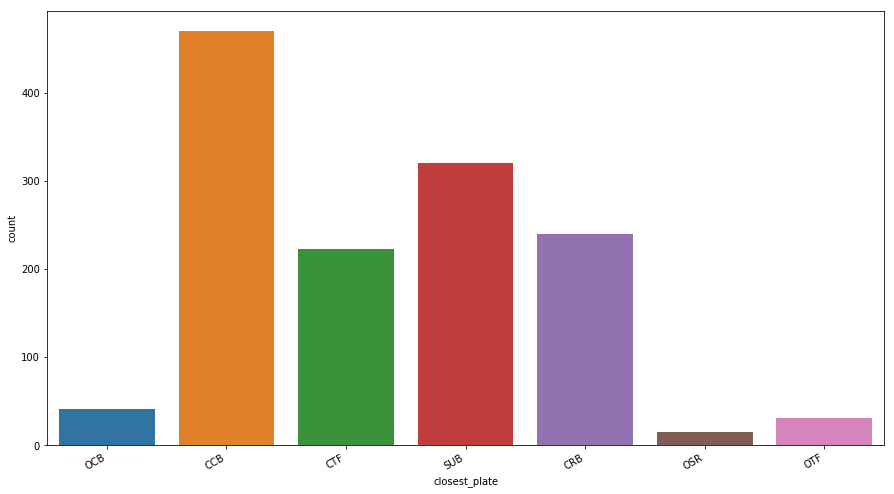

In [50]:
plt.subplots(figsize=(15, 8))
closest_plate_plot = sns.countplot(quake_plate_dist["closest_plate"])
closest_plate_plot.set_xticklabels(labels=quake_plate_dist["closest_plate"].unique(), rotation=30, ha='right')

In [51]:
# The count between the plate types and the dist df do not always match up. So, you need a way to make up for 
# the missing data.
quakes_closest = dict(quake_plate_dist["closest_plate"].value_counts())
plate_types = dict(boundaries_gdf['STEPCLASS'].value_counts())

type_counts = list()
for key, value in plate_types.items():
    key = key.strip()
    compare = {'type': key, 'plate': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 15, 'plate': 1875, 'type': 'OSR'},
 {'earthquakes': 31, 'plate': 1147, 'type': 'OTF'},
 {'earthquakes': 320, 'plate': 1129, 'type': 'SUB'},
 {'earthquakes': 240, 'plate': 474, 'type': 'CRB'},
 {'earthquakes': 223, 'plate': 457, 'type': 'CTF'},
 {'earthquakes': 470, 'plate': 401, 'type': 'CCB'},
 {'earthquakes': 41, 'plate': 341, 'type': 'OCB'}]

In [52]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = [plate_type['type'] for plate_type in type_counts]

dist_count = np.array([plate_type['earthquakes'] for plate_type in type_counts])
plate_count = np.array([plate_type['plate'] for plate_type in type_counts])

normalized_dist = np.divide(dist_count, plate_count)

Text(0,0.5,'normalized distance')

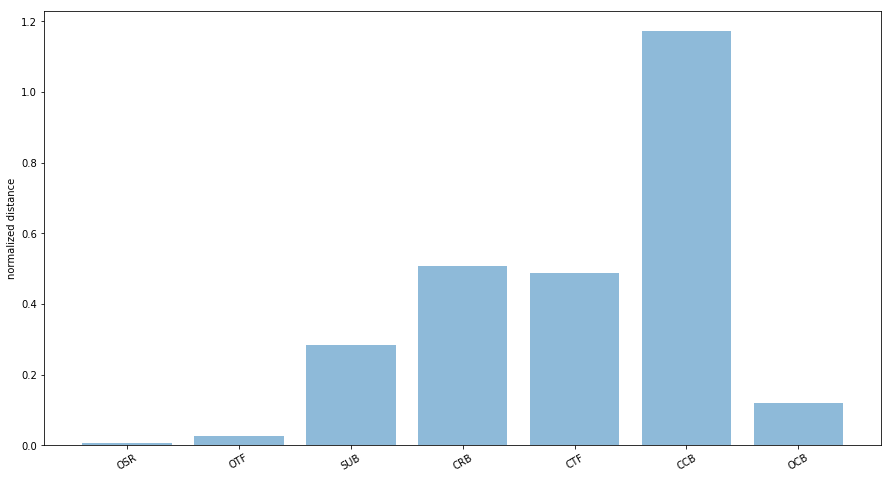

In [53]:
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

In [54]:
def total_boundary_length(geoseries):
    lengths = []
    for line in geoseries:
        length = line.length
        lengths.append(length)
        total_length = np.sum(lengths)
    return total_length

In [55]:
sub_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("SUB")].geometry
ccb_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("CCB")].geometry
crb_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("CRB")].geometry
ctf_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("CTF")].geometry
ocb_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("OCB")].geometry
osr_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("OSR")].geometry
otf_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("OTF")].geometry

In [56]:
dict_list = [sub_geo, ccb_geo, crb_geo, ctf_geo, ocb_geo, osr_geo, otf_geo]

boundaries_length = []

for geoseries in dict_list:
    total_length = total_boundary_length(geoseries)
    boundaries_length.append(total_length)
    
boundaries_length

[510.15978396960389,
 227.16539713527419,
 277.45574462724835,
 282.76180162839489,
 175.70936107173887,
 810.41473295295373,
 539.2965768111593]

In [57]:
quake_plate_dist["closest_plate"].value_counts()

CCB    470
SUB    320
CRB    240
CTF    223
OCB     41
OTF     31
OSR     15
Name: closest_plate, dtype: int64

In [58]:
bound_dist_count = np.array([320, 470, 240, 223, 41, 15, 31])
bound_length = np.array(boundaries_length)

In [59]:
norm_bound_dist = np.divide(bound_dist_count, bound_length)
norm_bound_dist

array([ 0.62725446,  2.06897708,  0.86500281,  0.78864966,  0.23333987,
        0.01850904,  0.05748229])

Text(0,0.5,'normalized distance to closest boundary')

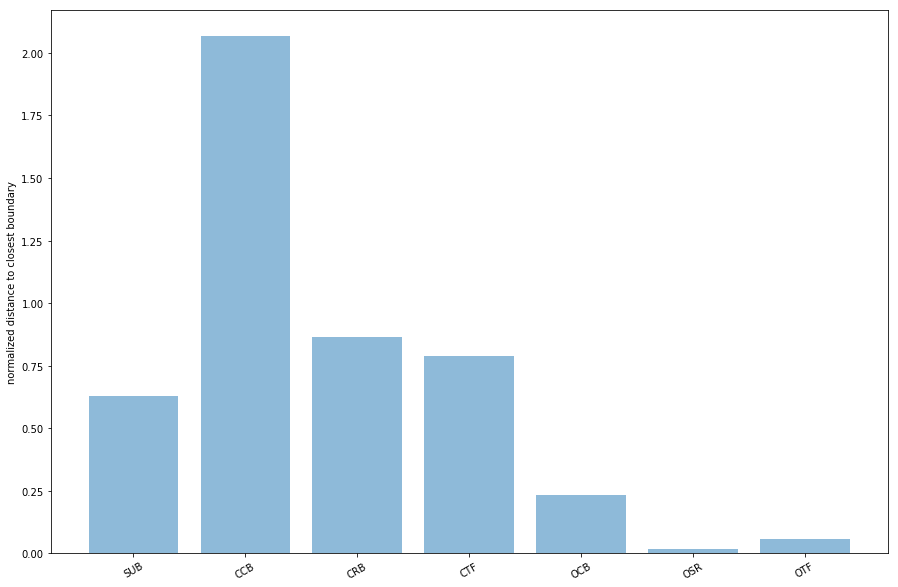

In [60]:
objects = ('SUB', 'CCB', 'CRB', 'CTF', 'OCB', 'OSR', 'OTF')
y_pos = np.arange(len(objects))
performance = norm_bound_dist
 
plt.figure(figsize=(15,10))
plt.bar(y_pos, performance, alpha=0.5)
plt.xticks(y_pos, objects, rotation = 30)
plt.ylabel('normalized distance to closest boundary')

Stratovolcanoes are tall conical mountains composed of lava flows and other ejecta in alternate layers, the strata that gives rise to the name. Stratovolcanoes are also known as composite volcanoes because they are created from multiple structures during different kinds of eruptions. Strato/composite volcanoes are made of cinders, ash, and lava. Cinders and ash pile on top of each other, lava flows on top of the ash, where it cools and hardens, and then the process repeats. Classic examples include Mount Fuji in Japan, Mayon Volcano in the Philippines, and Mount Vesuvius and Stromboli in Italy. (https://en.wikipedia.org/wiki/Volcano)

Shield volcanoes, so named for their broad, shield-like profiles, are formed by the eruption of low-viscosity lava that can flow a great distance from a vent. They generally do not explode catastrophically. Since low-viscosity magma is typically low in silica, shield volcanoes are more common in oceanic than continental settings. The Hawaiian volcanic chain is a series of shield cones, and they are common in Iceland, as well. (https://en.wikipedia.org/wiki/Volcano)

Cinder cones result from eruptions of mostly small pieces of scoria and pyroclastics (both resemble cinders, hence the name of this volcano type) that build up around the vent. These can be relatively short-lived eruptions that produce a cone-shaped hill perhaps 30 to 400 meters high. Most cinder cones erupt only once. Cinder cones may form as flank vents on larger volcanoes, or occur on their own. Parícutin in Mexico and Sunset Crater in Arizona are examples of cinder cones. In New Mexico, Caja del Rio is a volcanic field of over 60 cinder cones. (https://en.wikipedia.org/wiki/Volcano)

Submarine volcanoes are common features of the ocean floor. In shallow water, active volcanoes disclose their presence by blasting steam and rocky debris high above the ocean's surface. In the ocean's deep, the tremendous weight of the water above prevents the explosive release of steam and gases; however, they can be detected by hydrophones and discoloration of water because of volcanic gases. Pillow lava is a common eruptive product of submarine volcanoes and is characterized by thick sequences of discontinuous pillow-shaped masses which form under water. Even large submarine eruptions may not disturb the ocean surface due to the rapid cooling effect and increased buoyancy of water (as compared to air) which often causes volcanic vents to form steep pillars on the ocean floor. Hydrothermal vents are common near these volcanoes, and some support peculiar ecosystems based on dissolved minerals. Over time, the formations created by submarine volcanoes may become so large that they break the ocean surface as new islands or floating pumice rafts. (https://en.wikipedia.org/wiki/Volcano)

A fissure vent is a linear volcanic vent through which lava erupts, usually without any explosive activity. The vent is often a few meters wide and may be many kilometers long. Fissure vents can cause large flood basalts which run first in lava channels and later in lava tubes. After some time the eruption builds up spatter resp. ash cones and may concentrate on one or some of them. Small fissure vents may not be easily discernible from the air, but the crater rows (see Laki) or the canyons (see Eldgjá) built up by some of them are. (https://en.wikipedia.org/wiki/Fissure_vent)

A caldera is a large cauldron-like depression that forms following the evacuation of a magma chamber/reservoir. When large volumes of magma are erupted over a short time, structural support for the crust above the magma chamber is lost. The ground surface then collapses downward into the partially emptied magma chamber, leaving a massive depression at the surface (from one to dozens of kilometers in diameter). Although sometimes described as a crater, the feature is actually a type of sinkhole, as it is formed through subsidence and collapse rather than an explosion or impact. Only seven known caldera-forming collapses have occurred since the start of the 20th century, most recently at Bárðarbunga volcano in Iceland. (https://en.wikipedia.org/wiki/Caldera)

A complex volcano, also called a compound volcano, is mixed landform consisting of related volcanic centers and their associated lava flows and pyroclastic rock. They may form due to changes in eruptive habit or in the location of the principal vent area on a particular volcano. Stratovolcanoes can also form a large caldera that gets filled in by a lava dome, or else multiple small cinder cones, lava domes and craters may develop on the caldera's rim. (https://en.wikipedia.org/wiki/Complex_volcano)

A volcanic field is an area of the Earth's crust that is prone to localized volcanic activity. They usually contain 10 to 100 volcanoes such as cinder cones and are usually in clusters. Lava flows may also occur. They may occur as a monogenetic volcanic field or a polygenetic volcanic field. (https://en.wikipedia.org/wiki/Volcanic_field)

Lava domes (Dome) are built by slow eruptions of highly viscous lava. They are sometimes formed within the crater of a previous volcanic eruption, as in the case of Mount Saint Helens, but can also form independently, as in the case of Lassen Peak. Like stratovolcanoes, they can produce violent, explosive eruptions, but their lava generally does not flow far from the originating vent. (https://en.wikipedia.org/wiki/Volcano)

A somma volcano is a volcanic caldera that has been partially filled by a new central cone. The name comes from Mount Somma, a stratovolcano in southern Italy with a summit caldera in which the upper cone of Mount Vesuvius has grown. (https://en.wikipedia.org/wiki/Somma_volcano)

A maar is a broad, low-relief volcanic crater caused by a phreatomagmatic eruption (an explosion which occurs when groundwater comes into contact with hot lava or magma). A maar characteristically fills with water to form a relatively shallow crater lake which may also be called a maar.[1] The name comes from a Moselle Franconian dialect word used for the circular lakes of the Daun area of Germany.[2] Maars are shallow, flat-floored craters that scientists interpret as having formed above diatremes as a result of a violent expansion of magmatic gas or steam; deep erosion of a maar presumably would expose a diatreme. Maars range in size from 60 to 8,000 m (200 to 26,250 ft) across and from 10 to 200 m (33 to 656 ft) deep; most maars commonly fill with water to form natural lakes. Most maars have low rims composed of a mixture of loose fragments of volcanic rocks and rocks torn from the walls of the diatreme. (https://en.wikipedia.org/wiki/Maar)

Pyroclastic cones are the most abundant of volcanic structures. These small cones, named from a combination of the Greek words for fire (pyro) and broken (klastos), are built of fragmental material. They are found both as subsidiary features on larger stratovolcanoes and shield volcanoes or as independent volcanic structures. Pyroclastic cones typically range from a few tens of meters to a few hundred meters in height and are most often formed during single eruptions, when explosively ejected material accumulates around the vent. The slopes of pyroclastic cones consequently approach the angle of repose of its constituent materials. Pyroclastic cones, also known as cinder cones or scoria cones, can form rapidly, but remain active for long periods of time. Parícutin, the famous volcano born in Mexican cornfield in 1943, reached 80% of its 424 m height during its first year, but remained active for 9 years. Tuff cones are a variety of pyroclastic cone formed by more energetic explosions involving groundwater that extensively fragment ejecta, producing finer-grained ash deposits; they typically have steeper slopes and wider craters than cinder cones. (http://volcano.si.edu/learn_galleries.cfm?p=6)

A tuff ring is a related type of small monogenetic volcano that is also produced by phreatic (hydrovolcanic) explosions directly associated with magma brought to the surface through a conduit from a deep-seated magma reservoir. . They are characterized by rims that have a low, broad topographic profiles and gentle topographic slopes that are 25 degrees or less. The maximum thickness of the pyroclastic debris comprising the rim of a typical tuff ring is generally thin, less than 50 meters (160 ft) to 100 meters (330 ft) thick. The pyroclastic materials that comprise their rim consist primarily of relatively fresh and unaltered, distinctly and thin-bedded volcanic surge and air fall deposits. Their rims also can contain variable amounts of local country rock (bedrock) blasted out of their crater. In contrast to tuff cones, the crater of a tuff ring generally has been excavated below the existing ground surface. As a result, water commonly fills a tuff ring’s crater to form a lake once eruptions cease. (https://en.wikipedia.org/wiki/Volcanic_cone)

A volcanic plug, also called a volcanic neck or lava neck, is a volcanic object created when magma hardens within a vent on an active volcano. When present, a plug can cause an extreme build-up of pressure if rising volatile-charged magma is trapped beneath it, and this can sometimes lead to an explosive eruption. Glacial erosion can lead to exposure of the plug on one side, while a long slope of material remains on the opposite side. Such landforms are called crag and tail. If a plug is preserved, erosion may remove the surrounding rock while the erosion-resistant plug remains, producing a distinctive upstanding landform. (https://en.wikipedia.org/wiki/Volcanic_plug)